<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/AUDUSD/AUDUSD_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AUDUSD=X"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close  Volume
Date                                                         
2009-01-01  0.7055  0.7138  0.6919  0.7050     0.7050       0
2009-01-02  0.7050  0.7120  0.6925  0.7093     0.7093       0
2009-01-05  0.7156  0.7194  0.7067  0.7143     0.7143       0
2009-01-06  0.7140  0.7264  0.7040  0.7204     0.7204       0
2009-01-07  0.7200  0.7260  0.7099  0.7103     0.7103       0
...            ...     ...     ...     ...        ...     ...
2018-12-26  0.7049  0.7072  0.7033  0.7046     0.7046       0
2018-12-27  0.7073  0.7078  0.7018  0.7075     0.7075       0
2018-12-28  0.7034  0.7069  0.7031  0.7035     0.7035       0
2018-12-31  0.7043  0.7073  0.7036  0.7045     0.7045       0
2019-01-01  0.7042  0.7110  0.7015  0.7042     0.7042       0

[2604 rows x 6 columns]

Open         High          Low        Close    Adj Close  Volume
count  2604.000000  2604.000000  2604.000000  2604.000000  2604.000000  2604.0
mean      0.866171     0.870247     0.862117     0.866226     0.866226     0.0
std       0.121669     0.121901     0.121360     0.121630     0.121630     0.0
min       0.629700     0.636200     0.625300     0.629500     0.629500     0.0
25%       0.757300     0.760875     0.754500     0.757475     0.757475     0.0
50%       0.868000     0.873300     0.864600     0.868800     0.868800     0.0
75%       0.978025     0.985550     0.972850     0.977925     0.977925     0.0
max       1.103500     1.108100     1.100500     1.103500     1.103500     0.0

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  0.6483  0.6572  0.6418  0.6542     0.6542   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  0.643956  0.633754 -0.663018  0.648022  0.645818  0.648313     0.64450     0.64330  0.630320  0.643900  0.651069  0.642550  0.645847  0.643900  0.650167  0.644458                0.656112                 0.643900                0.631688                0.662218                 0.643900                0.625582                0.668324                 0.643900                0.619476                0.674430                 0.643900                0.613370  0.645818  0.649919  0.643824                0.658030                 0.645818                0.633606                0.664136                 0.645818                0.627500                0.670242                 0.645818                0.621394                0.676348                 0.645818                0.615288   
2009-03-13  0.6542  0.6601  0.6524  0.6584     0.6584   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  0.644678  0.634027 -0.661633  0.652503  0.648614  0.649264     0.64660     0.64475  0.632470  0.646463  0.656183  0.644700  0.649069  0.646463  0.656300  0.644518                0.660954                 0.646463                0.631971                0.668199                 0.646463                0.624726                0.675445                 0.646463                0.617480                0.682690                 0.646463                0.610235  0.648614  0.656193  0.644051                0.663105                 0.648614                0.634123                0.670351                 0.648614                0.626877                0.677596                 0.648614                0.619632                0.684842                 0.648614                0.612386   
2009-03-16  0.6567  0.

Open         High          Low        Close    Adj Close          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter        week      weekday  weekday_name  weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000    2554.000000   2554.000000     2554.000000     2554.000000       2554.000000  2554.000000  2554.000000  2554.00000  2554.000000   2554.000000  2554.00000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000             2554.000000              2554.000000             2554.000000             2554.000000              2554.000000             2554.000000             2554.000000              2554.000000             2554.000000             2554.000000              2554.000000             2554.000000  2554.000000  2554.000000  2554.000000             2554.000000              2554.000000             2554.000000             2554.000000              2554.000000             2554.000000             2554.000000   
mean      0.870181     0.874201     0.866218     0.870256     0.870256    15.766249     2.000000   185.829287      30.467502      0.033281        0.966719        0.010963          0.989037     6.612373     2.536022    26.99491     2.000000      1.999217    26.99491     0.870154     0.869770    -0.003715     0.870263     0.870169     0.870076     0.870045     0.869882     0.869528     0.870172     0.870259     0.870173     0.870201     0.870172     0.870250     0.869979                0.882410                 0.870172                0.857934                0.888529                 0.870172                0.851815                0.894648                 0.870172                0.845696                0.900767                 0.870172                0.839577     0.870169     0.870243     0.870009                0.882407                 0.870169                0.857931                0.888526                 0.870169                0.851812                0.894645   
std       0.119346     0.119687     0.118873     0.119274     0.119274     8.806032     1.415044   104.391452       0.781645      0.179405        0.179405        0.104150          0.104150     3.413772     1.107816    14.92812     1.415044      1.414490    14.92812     0.119095     0.119065     0.877857     0.119353     0.119106     0.119349     0.119088     0.118936     0.119270     0.119205     0.119324     0.119250     0.119191     0.119205     0.119259     0.119141                0.120940                 0.119205                0.117850                0.121945                 0.119205                0.117319                0.123038                 0.119205                0.116888                0.124218                 0.119205                0.116557     0.119106     0.119226     0.119149                0.120842                 0.119106                0.117751                0.121847                 0.119106                0.117220                0.122941   
min       0.648300     0.657200     0.641800     0.654200     0.654200     1.000000     0.000000     1

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  0.000000  0.000000  0.000000  0.000000   0.000000   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  0.000000  0.000000  0.203542  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000                0.000000                 0.000000                0.001271                0.000000                 0.000000                0.013016                0.000000                 0.000000                0.027599                0.000000                 0.000000                0.049823  0.000000  0.000000  0.000000                0.000000                 0.000000                0.000000                0.000000                 0.000000                0.009351                0.000000                 0.000000                0.023766                0.000000                 0.000000   
2009-03-13  0.012961  0.006432  0.023109  0.009348   0.009348   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  0.001617  0.000614  0.204175  0.009872  0.006245  0.002135    0.004675    0.003218  0.004501  0.005693  0.011280  0.004735  0.007137  0.005693  0.013609  0.000136                0.010213                 0.005693                0.001905                0.011987                 0.005693                0.011118                0.013591                 0.005693                0.023222                0.015050                 0.005693                0.043113  0.006245  0.013905  0.000516                0.011033                 0.006245                0.001163                0.012816                 0.006245                0.007958                0.014424                 0.006245                0.019865                0.015882                 0.006245   
2009-03-16  0.018453  0.015081  0.028995  0.012019   0.012019   16          0         75

138122

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         4 hours 58 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 3 days
H2O cluster name:           H2O_from_python_unknownUser_8gijzd
H2O cluster total nodes:    1
H2O cluster free memory:    8.43 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_151253_mod...  0.815084  0.617706              0.278656  0.465279  0.216485
1  DeepLearning_grid_1_AutoML_20190822_151253_mod...  0.809221  0.532891              0.260305  0.426393  0.181811
2  DeepLearning_grid_1_AutoML_20190822_151253_mod...  0.805008  0.564604              0.243237  0.427208  0.182506
3  DeepLearning_grid_1_AutoML_20190822_151253_mod...  0.804397  0.587603              0.299908  0.449032  0.201630
4  DeepLearning_grid_1_AutoML_20190822_151253_mod...  0.798779  0.596830              0.257771  0.453171  0.205364
5  DeepLearning_grid_1_AutoML_20190822_151253_mod...  0.797893  0.601990              0.322076  0.455867  0.207814
6  DeepLearning_grid_1_AutoML_20190822_151253_mod...  0.790107  0.557795              0.307176  0.437395  0.191314
7  DeepLearning_grid_1_AutoML_20190822_151253_mod...  0.756824  0.727479              0.335542  0.487184  0.237348
8              DeepLearning_1_AutoML_20190822_151253  0.737466  0.861395              0.345191  0.566906  0.321383
9  DeepLearning_grid_1_AutoML_20190822_151253_mod...  0.712550  1.424605              0.341374  0.535921  0.287212

variable  relative_importance  scaled_importance  percentage
0           CDLGRAVESTONEDOJI             1.000000           1.000000    0.006197
1            CDLDRAGONFLYDOJI             0.821469           0.821469    0.005091
2                   CDLTAKURI             0.778017           0.778017    0.004822
3                STOCHF_fastk             0.738010           0.738010    0.004574
4                      ULTOSC             0.732235           0.732235    0.004538
...                       ...                  ...                ...         ...
1021  BBANDS_upperband_14_4_4             0.109247           0.109247    0.000677
1022                MAVP_14_2             0.108199           0.108199    0.000671
1023       CDLSEPARATINGLINES             0.094326           0.094326    0.000585
1024               CDL3INSIDE             0.093312           0.093312    0.000578
1025             CDLTASUKIGAP             0.093238           0.093238    0.000578

[1026 rows x 4 columns]

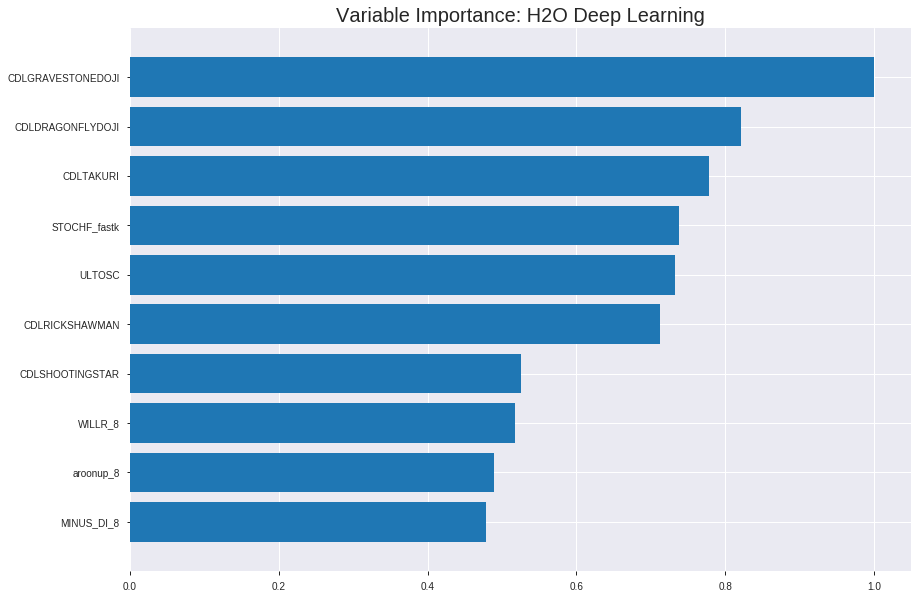

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_151253_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18004752456807396
RMSE: 0.42432007325611404
LogLoss: 0.537263839278908
Mean Per-Class Error: 0.27398701145472204
AUC: 0.8133216685787157
pr_auc: 0.8143003294469574
Gini: 0.6266433371574314
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2631429617600855: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      387  466   0.5463   (466.0/853.0)
1      74   860   0.0792   (74.0/934.0)
Total  461  1326  0.3022   (540.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.263143     0.761062  297
max f2                       0.125656     0.868656  347
max f0point5                 0.7328       0.759008  114
max accuracy                 0.557362     0.724119  185
max precision                0.999578     1         0
max recall                   0.00400229   1         396
max specificity              0.999578     1         0
max absolute_mcc             0.7328       0.456913  114
max min_per_class_accuracy   0.550476     0.719486  188
max mean_per_class_accuracy  0.620351     0.726013  159

Gains/Lift Table: Avg response rate: 52.27 %, avg score: 53.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.999326           1.91328   1.91328            1                0.99959    1                           0.99959             0.0192719       0.0192719                  91.3276   91.3276
    2        0.0201455                   0.998448           1.80698   1.86013            0.944444         0.998897   0.972222                    0.999244            0.0182013       0.0374732                  80.6983   86.013
    3        0.0302182                   0.997163           1.91328   1.87785            1                0.997807   0.981481                    0.998765            0.0192719       0.0567452                  91.3276   87.7845
    4        0.040291                    0.996255           1.80698   1.86013            0.944444         0.996748   0.972222                    0.998261            0.0182013       0.0749465                  80.6983   86.013
    5        0.0503637                   0.995013           1.91328   1.87076            1                0.995532   0.977778                    0.997715            0.0192719       0.0942184                  91.3276   87.0759
    6        0.100168                    0.980212           1.87028   1.87052            0.977528         0.988277   0.977654                    0.993022            0.0931478       0.187366                   87.0281   87.0521
    7        0.149972                    0.942531           1.63381   1.79191            0.853933         0.96297    0.936567                    0.983042            0.0813704       0.268737                   63.3809   79.1912
    8        0.200336                    0.892003           1.67943   1.76363            0.877778         0.916265   0.921788                    0.966255            0.0845824       0.353319                   67.9431   76.3635
    9        0.299944                    0.777776           1.41883   1.64913            0.741573         0.8392     0.86194                     0.924061            0.141328        0.494647                   41.8834   64.913
    10       0.400112                    0.666456           1.133     1.51992            0.592179         0.722468   0.794406                    0.873592            0.11349         0.608137                   13.3002   51.9917
    11       0.50028                     0.557693           1.06887   1.42961            0.558659         0.613711   0.747204                    0.821558            0.107066        0.715203                   6.88694   42.9607
    12       0.599888                    0.432908           0.859899  1.33501            0.449438         0.495659   0.697761                    0.767444            0.0856531       0.800857                   -14.0101  33.501
    13       0.700056                    0.314729           0.833718  1.26328            0.435754         0.383742   0.660272                    0.712542            0.0835118       0.884368                   -16.6282  26.3282
    14       0.799664                    0.19131            0.666422  1.18894            0.348315         0.250661   0.621414                    0.655009            0.0663812       0.950749                   -33.3578  18.8936
    15       0.899832                    0.0527325          0.384793  1.09942            0.201117         0.127695   0.574627                    0.596309            0.0385439       0.989293                   -61.5207  9.94199
    16       1                           3.22494e-06        0.106887  1                  0.0558659        0.0160461  0.522664                    0.5



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19786344860734426
RMSE: 0.4448184445449
LogLoss: 0.5842696813011431
Mean Per-Class Error: 0.26129201680672276
AUC: 0.8085377533366288
pr_auc: 0.826392809018437
Gini: 0.6170755066732576
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6583712993087363: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      160  78   0.3277   (78.0/238.0)
1      56   216  0.2059   (56.0/272.0)
Total  216  294  0.2627   (134.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.658371     0.763251  212
max f2                       0.228972     0.866321  348
max f0point5                 0.783177     0.777154  137
max accuracy                 0.658371     0.737255  212
max precision                0.999662     1         0
max recall                   0.0355395    1         397
max specificity              0.999662     1         0
max absolute_mcc             0.783177     0.482365  137
max min_per_class_accuracy   0.704278     0.718487  185
max mean_per_class_accuracy  0.751047     0.738708  155

Gains/Lift Table: Avg response rate: 53.33 %, avg score: 65.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117647                   0.998901           1.875     1.875              1                0.999394  1                           0.999394            0.0220588       0.0220588                  87.5       87.5
    2        0.0215686                   0.997308           1.875     1.875              1                0.998034  1                           0.998776            0.0183824       0.0404412                  87.5       87.5
    3        0.0313725                   0.993892           1.875     1.875              1                0.995982  1                           0.997903            0.0183824       0.0588235                  87.5       87.5
    4        0.0411765                   0.992949           1.875     1.875              1                0.993447  1                           0.996842            0.0183824       0.0772059                  87.5       87.5
    5        0.0509804                   0.991536           1.875     1.875              1                0.992455  1                           0.995998            0.0183824       0.0955882                  87.5       87.5
    6        0.1                         0.982548           1.725     1.80147            0.92             0.987059  0.960784                    0.991616            0.0845588       0.180147                   72.5       80.1471
    7        0.15098                     0.955125           1.65865   1.75325            0.884615         0.967038  0.935065                    0.983317            0.0845588       0.264706                   65.8654    75.3247
    8        0.2                         0.917958           1.5       1.69118            0.8              0.938866  0.901961                    0.972422            0.0735294       0.338235                   50         69.1176
    9        0.3                         0.859942           1.47059   1.61765            0.784314         0.886867  0.862745                    0.943904            0.147059        0.485294                   47.0588    61.7647
    10       0.4                         0.777371           1.32353   1.54412            0.705882         0.81971   0.823529                    0.912855            0.132353        0.617647                   32.3529    54.4118
    11       0.5                         0.712279           0.882353  1.41176            0.470588         0.7415    0.752941                    0.878584            0.0882353       0.705882                   -11.7647   41.1765
    12       0.6                         0.635771           0.992647  1.34191            0.529412         0.677648  0.715686                    0.845095            0.0992647       0.805147                   -0.735294  34.1912
    13       0.7                         0.543892           0.735294  1.25525            0.392157         0.59456   0.669468                    0.809304            0.0735294       0.878676                   -26.4706   25.5252
    14       0.8                         0.405079           0.551471  1.16728            0.294118         0.472864  0.622549                    0.767249            0.0551471       0.933824                   -44.8529   16.7279
    15       0.9                         0.205484           0.514706  1.09477            0.27451          0.30713   0.583878                    0.716125            0.0514706       0.985294                   -48.5294   9.47712
    16       1                           0.015831           0.147059  1                  0.0784314        0.11434   0.533333                    0.655946       


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 15:14:51  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 15:14:54  1 min 59.058 sec  400 obs/sec       0.639619  1             1143       0.61337          7.36353             -0.507992      0.629421        0.240809           1.07143          0.391158                         0.68313            16.1107               -0.875           0.5               0                    1.00074            0.466667
    2019-08-22 15:15:09  2 min 14.378 sec  414 obs/sec       3.90151   6             6972       0.558912         1.69356             -0.252101      0.619708        0.474103           1.91328          0.387801                         0.682964           4.6273                -0.874089        0.744593          0.743765             1.875              0.321569
    2019-08-22 15:15:24  2 min 28.686 sec  426 obs/sec       7.10464   11            12696      0.501002         0.777126            -0.00607851    0.694544        0.676822           1.91328          0.352546                         0.599209           1.19343               -0.442618        0.725161          0.755837             1.875              0.352941
    2019-08-22 15:15:38  2 min 42.820 sec  436 obs/sec       10.404    16            18592      0.478802         0.65218             0.0811071      0.704155        0.713601           1.91328          0.370453                         0.521295           0.759844              -0.0918483       0.732799          0.766551             1.875              0.335294
    2019-08-22 15:15:54  2 min 58.864 sec  446 obs/sec       14.3039   22            25561      0.51011          0.851871            -0.0429911     0.696003        0.687262           1.91328          0.357583                         0.626576           1.39724               -0.577401        0.758087          0.787634             1.875              0.3
    2019-08-22 15:16:09  3 min 14.293 sec  455 obs/sec       18.1891   28            32504      0.47796          0.691774            0.0843358      0.738472        0.757293           1.91328          0.356463                         0.489619           0.690207              0.0368133        0.784239          0.819646             1.875              0.292157
    2019-08-22 15:16:23  3 min 28.306 sec  454 obs/sec       21.3973   33            38237      0.490742         0.771651            0.0347048      0.782687        0.738787           1.80698          0.359821                         0.580883           1.23156               -0.355728        0.811063          0.806591             1.875              0.260784
    2019-08-22 15:16:38  3 min 42.807 sec  464 obs/sec       25.2832   39            45181      0.50533          0.811546            -0.0235351     0.713019        0.725951           1.80698          0.37437                          0.532871           0.838385              -0.140879        0.807874          0.830103             1.875              0.262745
    2019-08-22 15:16:52  3 m

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDLGRAVESTONEDOJI        1.0                    1.0                  0.0061974638315295365
CDLDRAGONFLYDOJI         0.8214688897132874     0.8214688897132874   0.0050910237327248245
CDLTAKURI                0.7780174016952515     0.7780174016952515   0.004821734707306908
STOCHF_fastk             0.7380101680755615     0.7380101680755615   0.004573791323949326
ULTOSC                   0.7322354316711426     0.7322354316711426   0.004538002603946324
---                      ---                    ---                  ---
BBANDS_upperband_14_4_4  0.1092468872666359     0.1092468872666359   0.0006770536325421606
MAVP_14_2                0.1081988736987114     0.1081988736987114   0.0006705586063599963
CDLSEPARATINGLINES       0.09432563930749893    0.09432563930749893  0.0005845797379941253
CDL3INSIDE               0.09331177920103073    0.09331177920103073  0.000578296376654058
CDLTASUKIGAP             0.0932384803891182     0.0932384803891182   0.000577842109918336


See the whole table with table.as_data_frame()


('accuracy', 0.74609375)

('F1', 0.7428571428571429)

('auc', 0.8150839694656489)

('logloss', 0.6177059436402699)

('mean_per_class_error', 0.2554198473282443)

('rmse', 0.4652791222921782)

('mse', 0.21648466164097974)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


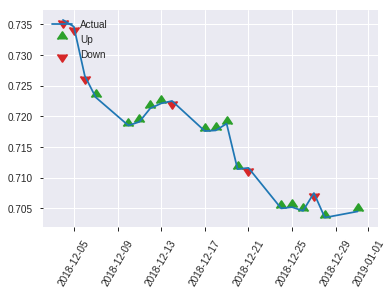


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21648466164097974
RMSE: 0.4652791222921782
LogLoss: 0.6177059436402699
Mean Per-Class Error: 0.2554198473282443
AUC: 0.8150839694656489
pr_auc: 0.8175907597673354
Gini: 0.6301679389312977
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6568028571254773: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      80   51   0.3893   (51.0/131.0)
1      21   104  0.168    (21.0/125.0)
Total  101  155  0.2812   (72.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.656803     0.742857  154
max f2                       0.266854     0.858726  221
max f0point5                 0.827506     0.773196  89
max accuracy                 0.827506     0.746094  89
max precision                0.999834     1         0
max recall                   0.203636     1         228
max specificity              0.999834     1         0
max absolute_mcc             0.827506     0.508278  89
max min_per_class_accuracy   0.733481     0.717557  126
max mean_per_class_accuracy  0.787174     0.74458   109

Gains/Lift Table: Avg response rate: 48.83 %, avg score: 66.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.996343           2.048     2.048              1                0.998659  1                           0.998659            0.024           0.024                      104.8     104.8
    2        0.0234375                   0.99551            2.048     2.048              1                0.995758  1                           0.997208            0.024           0.048                      104.8     104.8
    3        0.03125                     0.994079           2.048     2.048              1                0.994792  1                           0.996604            0.016           0.064                      104.8     104.8
    4        0.0429688                   0.993655           2.048     2.048              1                0.993964  1                           0.995884            0.024           0.088                      104.8     104.8
    5        0.0507812                   0.992758           1.024     1.89046            0.5              0.993016  0.923077                    0.995443            0.008           0.096                      2.4       89.0462
    6        0.101562                    0.984479           2.048     1.96923            1                0.988408  0.961538                    0.991926            0.104           0.2                        104.8     96.9231
    7        0.152344                    0.95181            1.89046   1.94297            0.923077         0.969582  0.948718                    0.984478            0.096           0.296                      89.0462   94.2974
    8        0.203125                    0.913075           1.89046   1.92985            0.923077         0.927708  0.942308                    0.970285            0.096           0.392                      89.0462   92.9846
    9        0.300781                    0.851773           1.31072   1.72883            0.64             0.881938  0.844156                    0.941601            0.128           0.52                       31.072    72.8831
    10       0.402344                    0.803766           1.18154   1.59068            0.576923         0.829521  0.776699                    0.913309            0.12            0.64                       18.1538   59.068
    11       0.5                         0.730356           0.90112   1.456              0.44             0.764559  0.710938                    0.884256            0.088           0.728                      -9.888    45.6
    12       0.601562                    0.656963           0.945231  1.36977            0.461538         0.696026  0.668831                    0.852477            0.096           0.824                      -5.47692  36.9766
    13       0.699219                    0.567199           0.65536   1.26999            0.32             0.624032  0.620112                    0.820571            0.064           0.888                      -34.464   26.9989
    14       0.800781                    0.452187           0.393846  1.15887            0.192308         0.519667  0.565854                    0.782408            0.04            0.928                      -60.6154  15.8868
    15       0.898438                    0.195009           0.73728   1.11304            0.36             0.326124  0.543478                    0.732812            0.072           1                          -26.272   11.3043
    16       1                           0.00463347         0         1                  0                0.099189  0.488281                    0.668459            0        

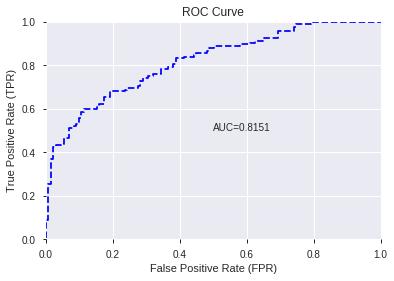

This function is available for GLM models only


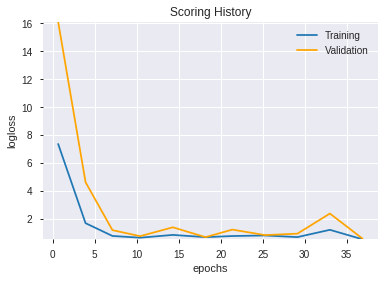

--2019-08-22 16:04:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.132.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.132.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


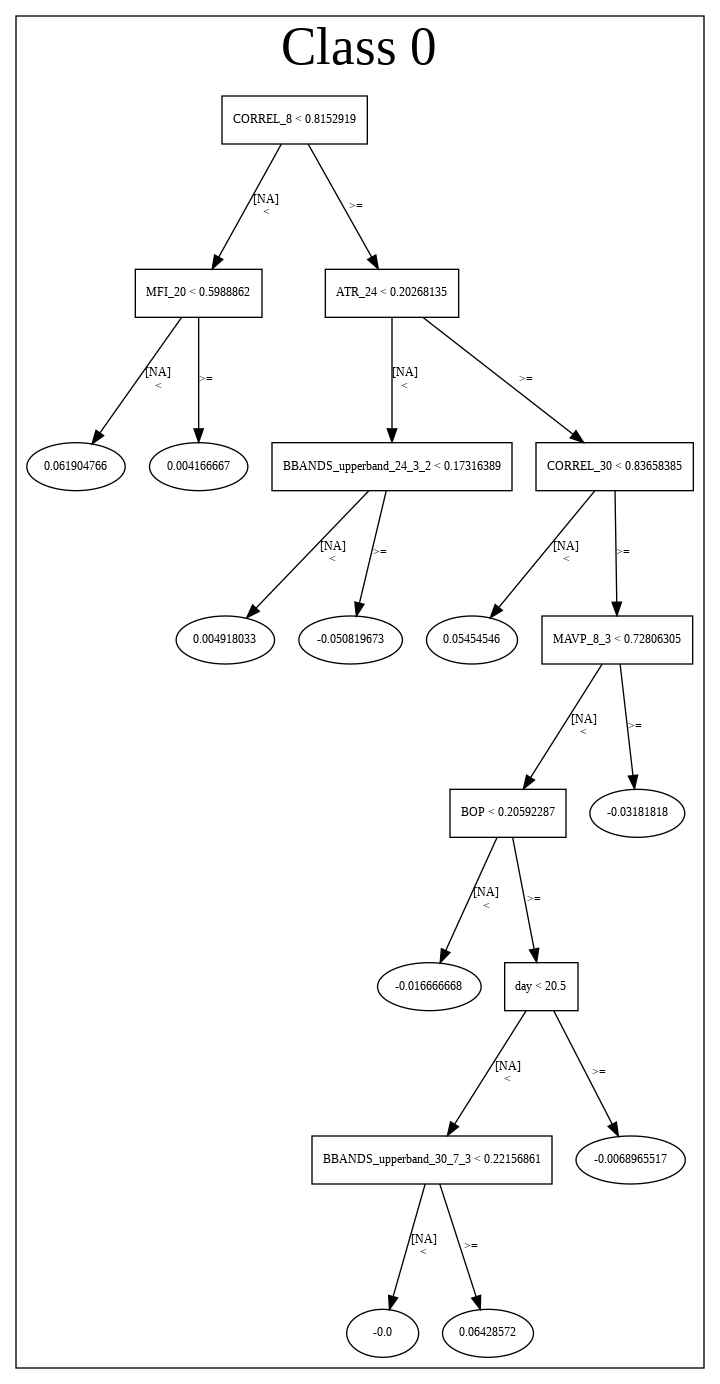

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_151253_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_151253_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_be46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_160500_model_6  0.822931  0.528121              0.259206  0.422495  0.178502
1  DeepLearning_grid_1_AutoML_20190822_160500_model_8  0.821435  0.536400              0.284641  0.424573  0.180262
2  DeepLearning_grid_1_AutoML_20190822_160500_model_9  0.818870  0.524869              0.295725  0.422602  0.178592
3               DeepLearning_1_AutoML_20190822_160500  0.813252  0.518505              0.241771  0.421117  0.177340
4  DeepLearning_grid_1_AutoML_20190822_160500_model_7  0.812031  0.580458              0.295908  0.439280  0.192967
5  DeepLearning_grid_1_AutoML_20190822_160500_model_5  0.805618  0.530526              0.318443  0.422445  0.178460
6  DeepLearning_grid_1_AutoML_20190822_160500_model_4  0.789008  0.770392              0.282656  0.486177  0.236368
7  DeepLearning_grid_1_AutoML_20190822_160500_model_3  0.778504  0.640191              0.297191  0.456475  0.208370
8  DeepLearning_grid_1_AutoML_20190822_160500_model_1  0.763664  0.639683              0.310260  0.464123  0.215410
9  DeepLearning_grid_1_AutoML_20190822_160500_model_2  0.737588  0.701910              0.374595  0.494111  0.244146

variable  relative_importance  scaled_importance  percentage
0         CDLRICKSHAWMAN             1.000000           1.000000    0.035312
1      CDLGRAVESTONEDOJI             0.916499           0.916499    0.032363
2                    SUB             0.836817           0.836817    0.029549
3                 ULTOSC             0.804918           0.804918    0.028423
4           HT_TRENDMODE             0.749790           0.749790    0.026476
5       CDLDRAGONFLYDOJI             0.717576           0.717576    0.025339
6           STOCHF_fastk             0.711257           0.711257    0.025116
7              CDLTAKURI             0.702911           0.702911    0.024821
8                WILLR_8             0.663676           0.663676    0.023436
9               WILLR_14             0.649078           0.649078    0.022920
10             CDLONNECK             0.645545           0.645545    0.022795
11     CDLLONGLEGGEDDOJI             0.641389           0.641389    0.022649
12             PLUS_DI_8             0.633343           0.633343    0.022364
13      CDLSTICKSANDWICH             0.632154           0.632154    0.022322
14               CDLDOJI             0.624582           0.624582    0.022055
15              WILLR_12             0.618982           0.618982    0.021857
16                 CCI_8             0.614411           0.614411    0.021696
17       CDLADVANCEBLOCK             0.605306           0.605306    0.021374
18           CDLBELTHOLD             0.598960           0.598960    0.021150
19             PLUS_DM_8             0.592688           0.592688    0.020929
20            PLUS_DM_12             0.571207           0.571207    0.020170
21       CDLSHOOTINGSTAR             0.552677           0.552677    0.019516
22            MINUS_DI_8             0.548240           0.548240    0.019359
23                TRANGE             0.536450           0.536450    0.018943
24  HT_PHASOR_quadrature             0.533838           0.533838    0.018851
25           CDLHIGHWAVE             0.532875           0.532875    0.018817
26    CDLCLOSINGMARUBOZU             0.526465           0.526465    0.018590
27                 month             0.513136           0.513136    0.018120
28    CDLEVENINGDOJISTAR             0.498763           0.498763    0.017612
29           MINUS_DI_12             0.498353           0.498353    0.017598
30        CDLSPINNINGTOP             0.497761           0.497761    0.017577
31             CDL2CROWS             0.496466           0.496466    0.017531
32             aroonup_8             0.483224           0.483224    0.017063
33             dayofweek             0.482803           0.482803    0.017049
34          aroondown_20             0.482701           0.482701    0.017045
35                CCI_12             0.473999           0.473999    0.016738
36          weekday_name             0.473631           0.473631    0.016725
37                   day             0.471088           0.471088    0.016635
38        STOCHRSI_fastk             0.469138           0.469138    0.016566
39                BETA_8             0.467730           0.467730    0.016516
40               weekday             0.460608           0.460608    0.016265
41          aroondown_30             0.460255           0.460255    0.016252
42     CDLINVERTEDHAMMER             0.443279           0.443279    0.015653
43            AROONOSC_8             0.441383           0.441383    0.015586
44                CCI_20             0.420909           0.420909    0.014863
45           aroondown_8             0.414569           0.414569    0.014639
46                CCI_24             0.409133           0.409133    0.014447
47             CDLHAMMER             0.409083           0.409083    0.014445
48                SAREXT             0.399979           0.399979    0.014124
49                CCI_30             0.389580           0.389580    0.013757

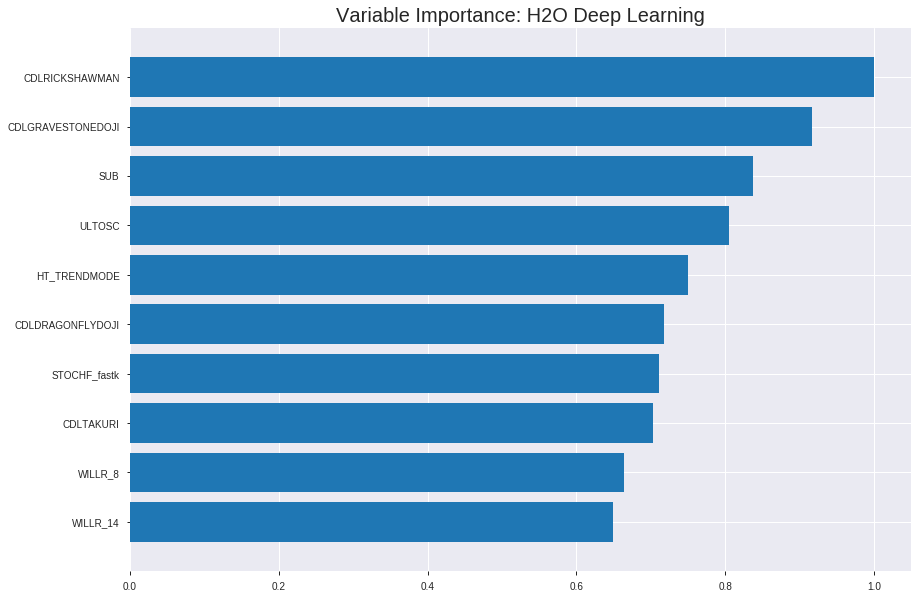

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_160500_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.16547328733205668
RMSE: 0.4067840794967973
LogLoss: 0.4884858655981072
Mean Per-Class Error: 0.2703269227389915
AUC: 0.8295002397383212
pr_auc: 0.8430663122297387
Gini: 0.6590004794766424
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48805676616178095: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      387  466   0.5463   (466.0/853.0)
1      42   892   0.045    (42.0/934.0)
Total  429  1358  0.2843   (508.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488057     0.77836   246
max f2                       0.361239     0.884282  285
max f0point5                 0.617834     0.773999  155
max accuracy                 0.512623     0.724678  225
max precision                0.997814     1         0
max recall                   0.0203794    1         384
max specificity              0.997814     1         0
max absolute_mcc             0.617834     0.479788  155
max min_per_class_accuracy   0.520782     0.716274  215
max mean_per_class_accuracy  0.573491     0.729673  179

Gains/Lift Table: Avg response rate: 52.27 %, avg score: 54.79 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.995389           1.91328    1.91328            1                0.996862   1                           0.996862            0.0192719       0.0192719                  91.3276   91.3276
    2        0.0201455                   0.994093           1.91328    1.91328            1                0.994773   1                           0.995818            0.0192719       0.0385439                  91.3276   91.3276
    3        0.0302182                   0.992626           1.80698    1.87785            0.944444         0.993473   0.981481                    0.995036            0.0182013       0.0567452                  80.6983   87.7845
    4        0.040291                    0.990253           1.91328    1.8867             1                0.991548   0.986111                    0.994164            0.0192719       0.0760171                  91.3276   88.6703
    5        0.0503637                   0.988644           1.91328    1.89202            1                0.989346   0.988889                    0.993201            0.0192719       0.0952891                  91.3276   89.2018
    6        0.100168                    0.9718             1.80579    1.84914            0.94382          0.980897   0.96648                     0.987083            0.0899358       0.185225                   80.5789   84.9144
    7        0.149972                    0.917958           1.87028    1.85616            0.977528         0.948884   0.970149                    0.974398            0.0931478       0.278373                   87.0281   85.6164
    8        0.200336                    0.819812           1.61566    1.7957             0.844444         0.869902   0.938547                    0.948128            0.0813704       0.359743                   61.5655   79.5701
    9        0.299944                    0.626902           1.49408    1.69553            0.780899         0.713826   0.886194                    0.870319            0.148822        0.508565                   49.4075   69.5534
    10       0.400112                    0.549071           1.09025    1.544              0.569832         0.584268   0.806993                    0.798706            0.109208        0.617773                   9.02468   54.4001
    11       0.50028                     0.521812           0.887162   1.41249            0.463687         0.534205   0.738255                    0.745747            0.0888651       0.706638                   -11.2838  41.2486
    12       0.599888                    0.512932           1.05338    1.35286            0.550562         0.516065   0.70709                     0.707609            0.104925        0.811563                   5.33768   35.2858
    13       0.700056                    0.509236           0.908539   1.28928            0.47486          0.511296   0.673861                    0.67952             0.0910064       0.90257                    -9.1461   28.9282
    14       0.799664                    0.410065           0.730915   1.21973            0.382022         0.483355   0.637509                    0.655085            0.0728051       0.975375                   -26.9085  21.973
    15       0.899832                    0.0691477          0.181708   1.10418            0.0949721        0.216542   0.577114                    0.606267            0.0182013       0.993576                   -81.8292  10.4179
    16       1                           0.000132527        0.0641322  1                  0.0335196        0.0239198  0.522664  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.17595496954077927
RMSE: 0.41946986726197544
LogLoss: 0.5441137089073217
Mean Per-Class Error: 0.258140756302521
AUC: 0.8180842189817104
pr_auc: 0.8336460889346704
Gini: 0.6361684379634207
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5124581762645096: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      138  100  0.4202   (100.0/238.0)
1      35   237  0.1287   (35.0/272.0)
Total  173  337  0.2647   (135.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.512458     0.778325  242
max f2                       0.270951     0.874172  317
max f0point5                 0.617355     0.77551   143
max accuracy                 0.514123     0.741176  235
max precision                0.994912     1         0
max recall                   0.000441777  1         398
max specificity              0.994912     1         0
max absolute_mcc             0.546146     0.485371  186
max min_per_class_accuracy   0.522622     0.716912  215
max mean_per_class_accuracy  0.546146     0.741859  186

Gains/Lift Table: Avg response rate: 53.33 %, avg score: 55.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.992976           1.875     1.875              1                0.993713   1                           0.993713            0.0220588       0.0220588                  87.5      87.5
    2        0.0215686                   0.990214           1.875     1.875              1                0.990913   1                           0.99244             0.0183824       0.0404412                  87.5      87.5
    3        0.0313725                   0.988942           1.875     1.875              1                0.989604   1                           0.991554            0.0183824       0.0588235                  87.5      87.5
    4        0.0411765                   0.987463           1.5       1.78571            0.8              0.988033   0.952381                    0.990716            0.0147059       0.0735294                  50        78.5714
    5        0.0509804                   0.985382           1.5       1.73077            0.8              0.986249   0.923077                    0.989857            0.0147059       0.0882353                  50        73.0769
    6        0.1                         0.964336           1.725     1.72794            0.92             0.976352   0.921569                    0.983237            0.0845588       0.172794                   72.5      72.7941
    7        0.15098                     0.938446           1.875     1.7776             1                0.956169   0.948052                    0.974097            0.0955882       0.268382                   87.5      77.7597
    8        0.2                         0.869146           1.725     1.76471            0.92             0.901267   0.941176                    0.956246            0.0845588       0.352941                   72.5      76.4706
    9        0.3                         0.677997           1.36029   1.6299             0.72549          0.764129   0.869281                    0.892207            0.136029        0.488971                   36.0294   62.9902
    10       0.4                         0.562649           1.21324   1.52574            0.647059         0.61557    0.813725                    0.823048            0.121324        0.610294                   21.3235   52.5735
    11       0.5                         0.524302           0.919118  1.40441            0.490196         0.543391   0.74902                     0.767117            0.0919118       0.702206                   -8.08824  40.4412
    12       0.6                         0.514322           1.17647   1.36642            0.627451         0.517773   0.728758                    0.725559            0.117647        0.819853                   17.6471   36.6422
    13       0.7                         0.508272           0.625     1.2605             0.333333         0.512395   0.672269                    0.695107            0.0625          0.882353                   -37.5     26.0504
    14       0.8                         0.350107           0.772059  1.19945            0.411765         0.45632    0.639706                    0.665259            0.0772059       0.959559                   -22.7941  19.9449
    15       0.9                         0.0939378          0.147059  1.08252            0.0784314        0.209255   0.577342                    0.614592            0.0147059       0.974265                   -85.2941  8.25163
    16       1                           0.000132807        0.257353  1                  0.137255         0.0330902  0.533333                    0.556442


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:09:07  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 16:09:10  2 min 17.938 sec  875 obs/sec       1.31393   1             2348       0.528361         0.937456            -0.11896       0.756304        0.734874           1.80698          0.337437                         0.508397           0.815532              -0.0384865       0.78685           0.804126             1.5625             0.319608
    2019-08-22 16:09:19  2 min 26.823 sec  1551 obs/sec      9.29435   7             16609      0.437084         0.554847            0.234258       0.798147        0.80629            1.80698          0.307219                         0.439003           0.572328              0.225666         0.802629          0.821285             1.875              0.313725
    2019-08-22 16:09:28  2 min 35.970 sec  1878 obs/sec      19.9368   15            35627      0.414379         0.503757            0.311746       0.819405        0.83136            1.91328          0.29211                          0.422163           0.546869              0.28393          0.812006          0.8308               1.875              0.296078
    2019-08-22 16:09:37  2 min 44.868 sec  2022 obs/sec      30.5059   23            54514      0.406784         0.488486            0.336744       0.8295          0.843066           1.91328          0.284275                         0.41947            0.544114              0.293038         0.818084          0.833646             1.875              0.264706
    2019-08-22 16:09:47  2 min 54.631 sec  2114 obs/sec      42.3973   32            75764      0.400787         0.476801            0.356156       0.847015        0.855657           1.91328          0.274203                         0.426456           0.572462              0.269293         0.807758          0.817631             1.875              0.276471
    2019-08-22 16:09:56  3 min  4.347 sec  2176 obs/sec      54.3553   41            97133      0.396475         0.46462             0.369937       0.863584        0.870234           1.91328          0.250699                         0.430779           0.573386              0.254404         0.80636           0.824423             1.875              0.305882
    2019-08-22 16:10:06  3 min 13.805 sec  2225 obs/sec      66.2742   50            118432     0.382772         0.437512            0.412737       0.880696        0.873289           1.91328          0.224958                         0.426233           0.56517               0.270059         0.808267          0.826467             1.875              0.305882
    2019-08-22 16:10:07  3 min 14.692 sec  2224 obs/sec      66.2742   50            118432     0.406784         0.488486            0.336744       0.8295          0.843066           1.91328          0.284275                         0.41947            0.544114              0.293038         0.818084          0.833646             1.875              0.264706

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDLRICKSHAWMAN     1.0                    1.0                  0.03531172616134812
CDLGRAVESTONEDOJI  0.9164987206459045     0.9164987206459045   0.032363151850674066
SUB                0.8368170261383057     0.8368170261383057   0.029549453674149538
ULTOSC             0.8049177527427673     0.8049177527427673   0.02842303526726031
HT_TRENDMODE       0.7497900128364563     0.7497900128364563   0.026476379611794634
---                ---                    ---                  ---
aroondown_8        0.4145691394805908     0.4145691394805908   0.014639151928284355
CCI_24             0.40913254022598267    0.40913254022598267  0.014447176224156642
CDLHAMMER          0.40908339619636536    0.40908339619636536  0.01444544086364033
SAREXT             0.3999786674976349     0.3999786674976349   0.014123937177057393
CCI_30             0.3895803391933441     0.3895803391933441   0.013756754255440483


See the whole table with table.as_data_frame()


('accuracy', 0.74609375)

('F1', 0.7598566308243728)

('auc', 0.8229312977099237)

('logloss', 0.52812126537091)

('mean_per_class_error', 0.255236641221374)

('rmse', 0.4224946024445408)

('mse', 0.17850168909477057)

deeplearning prediction progress: |███████████████████████████████████████| 100%


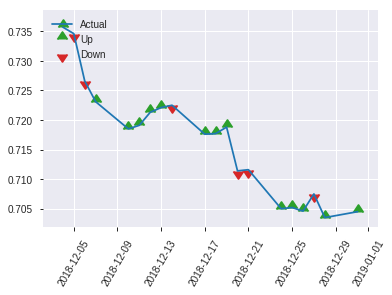


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.17850168909477057
RMSE: 0.4224946024445408
LogLoss: 0.52812126537091
Mean Per-Class Error: 0.255236641221374
AUC: 0.8229312977099237
pr_auc: 0.8105578487982469
Gini: 0.6458625954198474
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5132466633769689: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      83   48   0.3664   (48.0/131.0)
1      19   106  0.152    (19.0/125.0)
Total  102  154  0.2617   (67.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.513247     0.759857  152
max f2                       0.148489     0.862069  223
max f0point5                 0.607979     0.771971  73
max accuracy                 0.530426     0.746094  111
max precision                0.995385     1         0
max recall                   0.148489     1         223
max specificity              0.995385     1         0
max absolute_mcc             0.607979     0.497625  73
max min_per_class_accuracy   0.519013     0.728     125
max mean_per_class_accuracy  0.530426     0.744763  111

Gains/Lift Table: Avg response rate: 48.83 %, avg score: 52.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.993768           2.048     2.048              1                0.994724   1                           0.994724            0.024           0.024                      104.8     104.8
    2        0.0234375                   0.989824           2.048     2.048              1                0.9918     1                           0.993262            0.024           0.048                      104.8     104.8
    3        0.03125                     0.988828           2.048     2.048              1                0.989393   1                           0.992295            0.016           0.064                      104.8     104.8
    4        0.0429688                   0.986288           1.36533   1.86182            0.666667         0.9879     0.909091                    0.991096            0.016           0.08                       36.5333   86.1818
    5        0.0507812                   0.979167           2.048     1.89046            1                0.984279   0.923077                    0.990047            0.016           0.096                      104.8     89.0462
    6        0.101562                    0.952075           1.89046   1.89046            0.923077         0.96763    0.923077                    0.978839            0.096           0.192                      89.0462   89.0462
    7        0.152344                    0.911035           1.89046   1.89046            0.923077         0.93474    0.923077                    0.964139            0.096           0.288                      89.0462   89.0462
    8        0.203125                    0.784955           1.89046   1.89046            0.923077         0.843701   0.923077                    0.93403             0.096           0.384                      89.0462   89.0462
    9        0.300781                    0.597803           1.47456   1.75543            0.72             0.66489    0.857143                    0.846647            0.144           0.528                      47.456    75.5429
    10       0.402344                    0.538098           1.10277   1.59068            0.538462         0.561578   0.776699                    0.774688            0.112           0.64                       10.2769   59.068
    11       0.5                         0.517655           0.90112   1.456              0.44             0.526118   0.710938                    0.726139            0.088           0.728                      -9.888    45.6
    12       0.601562                    0.513247           1.18154   1.40966            0.576923         0.515177   0.688312                    0.690522            0.12            0.848                      18.1538   40.9662
    13       0.699219                    0.493469           0.49152   1.28143            0.24             0.506376   0.625698                    0.664803            0.048           0.896                      -50.848   28.143
    14       0.800781                    0.299215           0.393846  1.16886            0.192308         0.411859   0.570732                    0.632722            0.04            0.936                      -60.6154  16.8859
    15       0.898438                    0.114972           0.65536   1.11304            0.32             0.187949   0.543478                    0.584378            0.064           1                          -34.464   11.3043
    16       1                           0.00834781         0         1                  0                0.0427929  0.488281                    0.529373  

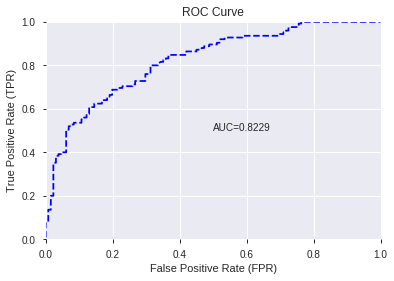

This function is available for GLM models only


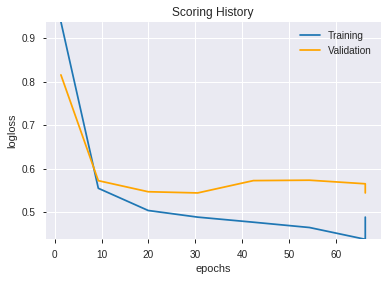

--2019-08-22 16:15:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


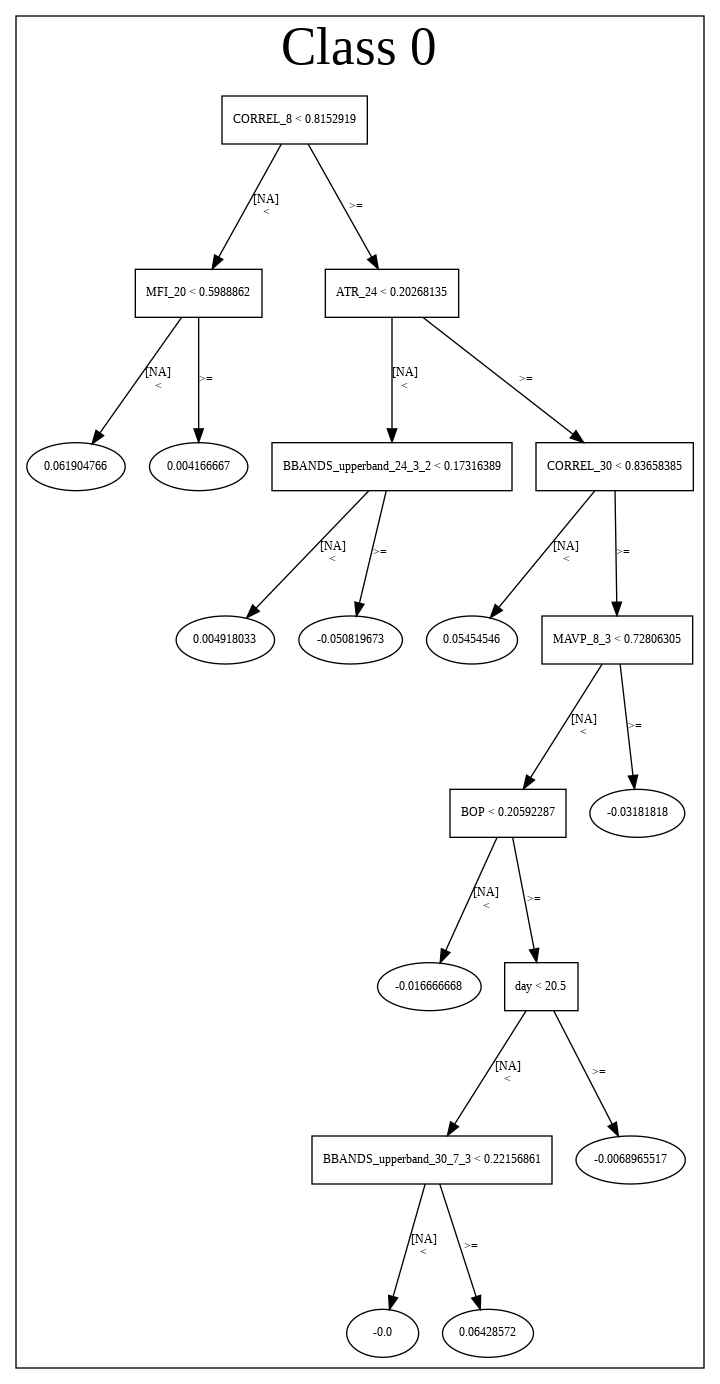

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_160500_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_160500_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_be46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLRICKSHAWMAN',
 'CDLGRAVESTONEDOJI',
 'SUB',
 'ULTOSC',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'STOCHF_fastk',
 'CDLTAKURI',
 'WILLR_8',
 'WILLR_14',
 'CDLONNECK',
 'CDLLONGLEGGEDDOJI',
 'PLUS_DI_8',
 'CDLSTICKSANDWICH',
 'CDLDOJI',
 'WILLR_12',
 'CCI_8',
 'CDLADVANCEBLOCK',
 'CDLBELTHOLD',
 'PLUS_DM_8',
 'PLUS_DM_12',
 'CDLSHOOTINGSTAR',
 'MINUS_DI_8',
 'TRANGE',
 'HT_PHASOR_quadrature',
 'CDLHIGHWAVE',
 'CDLCLOSINGMARUBOZU',
 'month',
 'CDLEVENINGDOJISTAR',
 'MINUS_DI_12',
 'CDLSPINNINGTOP',
 'CDL2CROWS',
 'aroonup_8',
 'dayofweek',
 'aroondown_20',
 'CCI_12',
 'weekday_name',
 'day',
 'STOCHRSI_fastk',
 'BETA_8',
 'weekday',
 'aroondown_30',
 'CDLINVERTEDHAMMER',
 'AROONOSC_8',
 'CCI_20',
 'aroondown_8',
 'CCI_24',
 'CDLHAMMER',
 'SAREXT',
 'CCI_30']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_161535_model_1  0.827847  0.509278              0.265924  0.413262  0.170786

variable  relative_importance  scaled_importance  percentage
0               WILLR_14             1.051667           1.000000    0.097763
1             MINUS_DI_8             1.012960           0.963194    0.094165
2            MINUS_DI_12             0.945384           0.898938    0.087883
3       CDLDRAGONFLYDOJI             0.702343           0.667838    0.065290
4                  CCI_8             0.626836           0.596040    0.058271
5                WILLR_8             0.624388           0.593712    0.058043
6                 CCI_12             0.565593           0.537806    0.052578
7      CDLGRAVESTONEDOJI             0.562144           0.534527    0.052257
8                 CCI_30             0.430167           0.409033    0.039988
9      CDLLONGLEGGEDDOJI             0.358262           0.340661    0.033304
10             CDLONNECK             0.325339           0.309355    0.030244
11      CDLSTICKSANDWICH             0.260652           0.247847    0.024230
12             CDLTAKURI             0.252813           0.240393    0.023502
13          STOCHF_fastk             0.236454           0.224837    0.021981
14          aroondown_30             0.194338           0.184790    0.018066
15        STOCHRSI_fastk             0.155107           0.147487    0.014419
16          aroondown_20             0.147866           0.140601    0.013746
17             CDL2CROWS             0.144937           0.137817    0.013473
18             aroonup_8             0.142629           0.135622    0.013259
19                CCI_20             0.142591           0.135586    0.013255
20               CDLDOJI             0.136012           0.129330    0.012644
21            PLUS_DM_12             0.134771           0.128150    0.012528
22                CCI_24             0.128839           0.122509    0.011977
23        CDLRICKSHAWMAN             0.127753           0.121476    0.011876
24    CDLEVENINGDOJISTAR             0.120472           0.114553    0.011199
25                TRANGE             0.114120           0.108514    0.010609
26                ULTOSC             0.110620           0.105186    0.010283
27  HT_PHASOR_quadrature             0.109505           0.104126    0.010180
28       CDLSHOOTINGSTAR             0.098597           0.093753    0.009166
29           CDLBELTHOLD             0.098195           0.093371    0.009128
30                   SUB             0.074538           0.070876    0.006929
31                 month             0.068944           0.065556    0.006409
32           aroondown_8             0.065323           0.062113    0.006072
33          HT_TRENDMODE             0.061794           0.058758    0.005744
34             PLUS_DM_8             0.056912           0.054116    0.005291
35            AROONOSC_8             0.046615           0.044325    0.004333
36                   day             0.044852           0.042649    0.004169
37        CDLSPINNINGTOP             0.042920           0.040811    0.003990
38                BETA_8             0.036655           0.034854    0.003407
39             CDLHAMMER             0.036456           0.034665    0.003389
40             PLUS_DI_8             0.034830           0.033118    0.003238
41       CDLADVANCEBLOCK             0.028297           0.026907    0.002630
42           CDLHIGHWAVE             0.025339           0.024094    0.002356
43             dayofweek             0.018403           0.017499    0.001711
44          weekday_name             0.017871           0.016993    0.001661
45               weekday             0.015335           0.014581    0.001425
46    CDLCLOSINGMARUBOZU             0.008170           0.007769    0.000760
47     CDLINVERTEDHAMMER             0.006838           0.006502    0.000636
48              WILLR_12             0.003768           0.003583    0.000350
49                SAREXT             0.002100           0.001997    0.000195

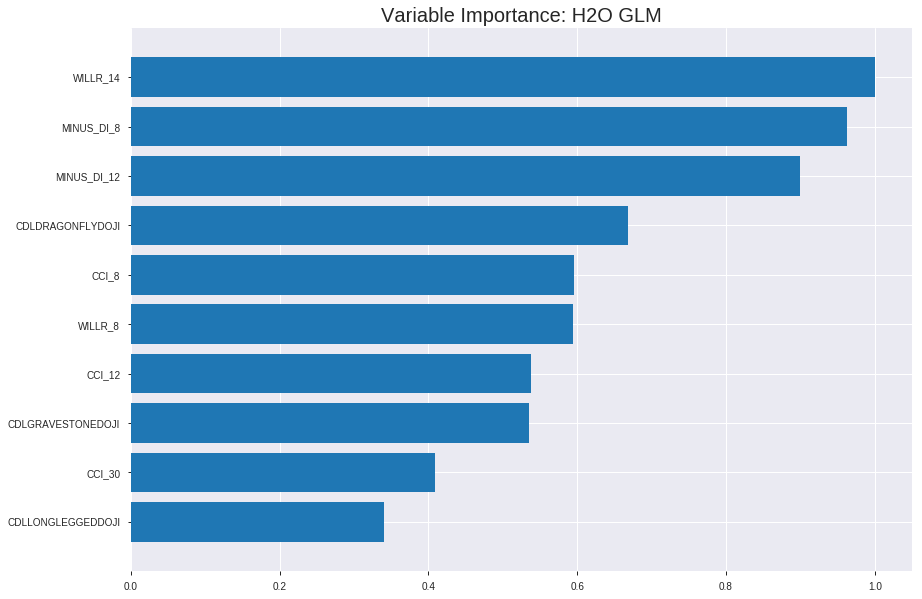

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_161535_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1803224086359544
RMSE: 0.4246438609422658
LogLoss: 0.5319505773918987
Null degrees of freedom: 1786
Residual degrees of freedom: 1736
Null deviance: 2473.635248547511
Residual deviance: 1901.191363598646
AIC: 2003.191363598646
AUC: 0.802272995423634
pr_auc: 0.8106887168597395
Gini: 0.6045459908472679
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39581545540348984: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      442  411   0.4818   (411.0/853.0)
1      111  823   0.1188   (111.0/934.0)
Total  553  1234  0.2921   (522.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395815     0.759225  259
max f2                       0.250412     0.866142  315
max f0point5                 0.587617     0.74026   166
max accuracy                 0.455898     0.72244   233
max precision                0.999785     1         0
max recall                   0.0395821    1         389
max specificity              0.999785     1         0
max absolute_mcc             0.455898     0.447092  233
max min_per_class_accuracy   0.532951     0.70985   197
max mean_per_class_accuracy  0.478202     0.718002  222

Gains/Lift Table: Avg response rate: 52.27 %, avg score: 52.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.97601            1.91328   1.91328            1                0.990426   1                           0.990426            0.0192719       0.0192719                  91.3276   91.3276
    2        0.0201455                   0.970586           1.80698   1.86013            0.944444         0.973404   0.972222                    0.981915            0.0182013       0.0374732                  80.6983   86.013
    3        0.0302182                   0.961699           1.91328   1.87785            1                0.966294   0.981481                    0.976708            0.0192719       0.0567452                  91.3276   87.7845
    4        0.040291                    0.95161            1.80698   1.86013            0.944444         0.956487   0.972222                    0.971653            0.0182013       0.0749465                  80.6983   86.013
    5        0.0503637                   0.943022           1.80698   1.8495             0.944444         0.948459   0.966667                    0.967014            0.0182013       0.0931478                  80.6983   84.95
    6        0.100168                    0.904539           1.78429   1.81708            0.932584         0.924164   0.949721                    0.945709            0.0888651       0.182013                   78.4291   81.7078
    7        0.149972                    0.846413           1.6983    1.77763            0.88764          0.880453   0.929104                    0.924038            0.0845824       0.266595                   69.8301   77.7634
    8        0.200336                    0.770506           1.4881    1.70485            0.777778         0.805596   0.891061                    0.894262            0.0749465       0.341542                   48.8104   70.4847
    9        0.299944                    0.660756           1.33284   1.58131            0.696629         0.709007   0.826493                    0.832741            0.132762        0.474304                   33.2844   58.1309
    10       0.400112                    0.591669           1.2292    1.49316            0.642458         0.624771   0.78042                     0.780675            0.123126        0.59743                    22.92     49.3158
    11       0.50028                     0.536421           1.05818   1.40607            0.553073         0.563162   0.734899                    0.737124            0.105996        0.703426                   5.81807   40.6065
    12       0.599888                    0.466558           1.02113   1.34215            0.533708         0.502775   0.701493                    0.698212            0.101713        0.805139                   2.11306   34.2149
    13       0.700056                    0.389048           0.769586  1.26022            0.402235         0.429333   0.658673                    0.659739            0.0770878       0.882227                   -23.0414  26.0224
    14       0.799664                    0.282748           0.666422  1.18626            0.348315         0.341694   0.620014                    0.620123            0.0663812       0.948608                   -33.3578  18.6258
    15       0.899832                    0.110508           0.363416  1.09466            0.189944         0.200828   0.572139                    0.573447            0.0364026       0.985011                   -63.6584  9.46605
    16       1                           0.00188892         0.149642  1                  0.0782123        0.0664606  0.522664                    0.5



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1681447536362341
RMSE: 0.41005457397306777
LogLoss: 0.5059887325216125
Null degrees of freedom: 509
Residual degrees of freedom: 459
Null deviance: 704.9746584600862
Residual deviance: 516.1085071720448
AIC: 618.1085071720448
AUC: 0.8270514087988137
pr_auc: 0.8335480155019573
Gini: 0.6541028175976273
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.325418302056258: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      112  126  0.5294   (126.0/238.0)
1      13   259  0.0478   (13.0/272.0)
Total  125  385  0.2725   (139.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.325418     0.788432  295
max f2                       0.325418     0.879158  295
max f0point5                 0.659028     0.775862  126
max accuracy                 0.474319     0.752941  230
max precision                0.999864     1         0
max recall                   0.0537924    1         388
max specificity              0.999864     1         0
max absolute_mcc             0.472568     0.505261  232
max min_per_class_accuracy   0.538209     0.735294  194
max mean_per_class_accuracy  0.474319     0.746586  230

Gains/Lift Table: Avg response rate: 53.33 %, avg score: 53.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117647                   0.986546           1.875     1.875              1                0.992806   1                           0.992806            0.0220588       0.0220588                  87.5       87.5
    2        0.0215686                   0.977523           1.5       1.70455            0.8              0.980751   0.909091                    0.987327            0.0147059       0.0367647                  50         70.4545
    3        0.0313725                   0.963355           1.875     1.75781            1                0.967287   0.9375                      0.981064            0.0183824       0.0551471                  87.5       75.7812
    4        0.0411765                   0.95375            1.875     1.78571            1                0.958025   0.952381                    0.975579            0.0183824       0.0735294                  87.5       78.5714
    5        0.0509804                   0.948524           1.875     1.80288            1                0.95091    0.961538                    0.970835            0.0183824       0.0919118                  87.5       80.2885
    6        0.1                         0.914792           1.65      1.72794            0.88             0.933442   0.921569                    0.952505            0.0808824       0.172794                   65         72.7941
    7        0.15098                     0.868699           1.80288   1.75325            0.961538         0.899655   0.935065                    0.93466             0.0919118       0.264706                   80.2885    75.3247
    8        0.2                         0.785347           1.725     1.74632            0.92             0.828788   0.931373                    0.908711            0.0845588       0.349265                   72.5       74.6324
    9        0.3                         0.671046           1.47059   1.65441            0.784314         0.722471   0.882353                    0.846631            0.147059        0.496324                   47.0588    65.4412
    10       0.4                         0.60402            0.992647  1.48897            0.529412         0.63642    0.794118                    0.794078            0.0992647       0.595588                   -0.735294  48.8971
    11       0.5                         0.542972           1.17647   1.42647            0.627451         0.568453   0.760784                    0.748953            0.117647        0.713235                   17.6471    42.6471
    12       0.6                         0.485174           1.06618   1.36642            0.568627         0.516502   0.728758                    0.710211            0.106618        0.819853                   6.61765    36.6422
    13       0.7                         0.395703           0.808824  1.28676            0.431373         0.44067    0.686275                    0.671705            0.0808824       0.900735                   -19.1176   28.6765
    14       0.8                         0.283992           0.588235  1.19945            0.313725         0.333161   0.639706                    0.629387            0.0588235       0.959559                   -41.1765   19.9449
    15       0.9                         0.12877            0.220588  1.09069            0.117647         0.192644   0.581699                    0.58086             0.0220588       0.981618                   -77.9412   9.06863
    16       1                           0.0191098          0.183824  1                  0.0980392        0.0730329  0.533333     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 16:15:35  0.000 sec   2            .16E2     49            1.366039883928515   1.3636263787019691
     2019-08-22 16:15:35  0.011 sec   4            .98E1     49            1.3560805601627095  1.3533814389501653
     2019-08-22 16:15:35  0.025 sec   6            .61E1     50            1.3415563770121373  1.3384148468373367
     2019-08-22 16:15:35  0.040 sec   8            .38E1     51            1.3214017826775297  1.3175867754764772
     2019-08-22 16:15:36  0.051 sec   10           .23E1     51            1.295231614295407   1.2904409829020878
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 16:15:36  0.285 sec   47           .17E-3    51            1.0639598133531876  1.0126724002639929
     2019-08-22 16:15:36  0.291 sec   48           .11E-3    51            1.0639269570728664  1.012362695829084
     2019-08-22 16:15:36  0.297 sec   49           .66E-4    51            1.0639117085132723  1.0121610033648631
     2019-08-22 16:15:36  0.303 sec   50           .41E-4    51            1.0639048237563422  1.012057293810678
     2019-08-22 16:15:36  0.310 sec   51           .25E-4    51            1.0639011547837973  1.0119774650432252


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.765625)

('F1', 0.7628865979381444)

('auc', 0.8278473282442748)

('logloss', 0.5092781748533575)

('mean_per_class_error', 0.23487022900763366)

('rmse', 0.4132624095418588)

('mse', 0.170785819140343)

glm prediction progress: |████████████████████████████████████████████████| 100%


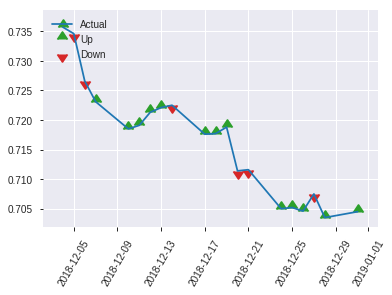


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.170785819140343
RMSE: 0.4132624095418588
LogLoss: 0.5092781748533575
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 355.96216876159656
Residual deviance: 260.750425524919
AIC: 362.750425524919
AUC: 0.8278473282442748
pr_auc: 0.8117149252345969
Gini: 0.6556946564885495
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39452096307065043: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      76   55   0.4198   (55.0/131.0)
1      14   111  0.112    (14.0/125.0)
Total  90   166  0.2695   (69.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394521     0.762887  165
max f2                       0.255112     0.853659  196
max f0point5                 0.551211     0.769231  114
max accuracy                 0.551211     0.765625  114
max precision                0.993016     1         0
max recall                   0.0877205    1         232
max specificity              0.993016     1         0
max absolute_mcc             0.551211     0.531765  114
max min_per_class_accuracy   0.522319     0.748092  126
max mean_per_class_accuracy  0.545743     0.76513   120

Gains/Lift Table: Avg response rate: 48.83 %, avg score: 50.79 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.970575           2.048      2.048              1                0.988453   1                           0.988453            0.024           0.024                      104.8     104.8
    2        0.0234375                   0.957414           2.048      2.048              1                0.959533   1                           0.973993            0.024           0.048                      104.8     104.8
    3        0.03125                     0.955053           2.048      2.048              1                0.956107   1                           0.969522            0.016           0.064                      104.8     104.8
    4        0.0429688                   0.952551           1.36533    1.86182            0.666667         0.953744   0.909091                    0.965219            0.016           0.08                       36.5333   86.1818
    5        0.0507812                   0.951089           2.048      1.89046            1                0.951632   0.923077                    0.963128            0.016           0.096                      104.8     89.0462
    6        0.101562                    0.914371           1.89046    1.89046            0.923077         0.93734    0.923077                    0.950234            0.096           0.192                      89.0462   89.0462
    7        0.152344                    0.870486           1.89046    1.89046            0.923077         0.896219   0.923077                    0.932229            0.096           0.288                      89.0462   89.0462
    8        0.203125                    0.729988           1.41785    1.77231            0.692308         0.797271   0.865385                    0.89849             0.072           0.36                       41.7846   77.2308
    9        0.300781                    0.658098           1.55648    1.70223            0.76             0.695669   0.831169                    0.832639            0.152           0.512                      55.648    70.2234
    10       0.402344                    0.589418           1.33908    1.61056            0.653846         0.624546   0.786408                    0.780111            0.136           0.648                      33.9077   61.0563
    11       0.5                         0.521355           1.06496    1.504              0.52             0.554051   0.734375                    0.735958            0.104           0.752                      6.496     50.4
    12       0.601562                    0.450868           0.787692   1.38306            0.384615         0.483329   0.675325                    0.693307            0.08            0.832                      -21.2308  38.3065
    13       0.699219                    0.355141           0.73728    1.29287            0.36             0.395777   0.631285                    0.651752            0.072           0.904                      -26.272   29.2872
    14       0.800781                    0.227696           0.551385   1.19883            0.269231         0.293361   0.585366                    0.606298            0.056           0.96                       -44.8615  19.8829
    15       0.898438                    0.0984097          0.32768    1.10414            0.16             0.16861    0.53913                     0.558723            0.032           0.992                      -67.232   10.4139
    16       1                           0.00831939         0.0787692  1                  0.0384615        0.0579576  0.488281          

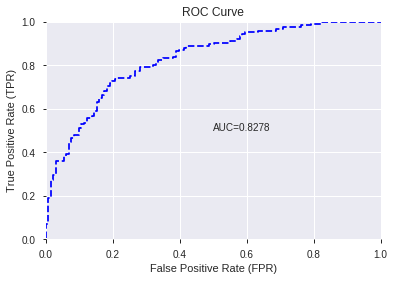

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


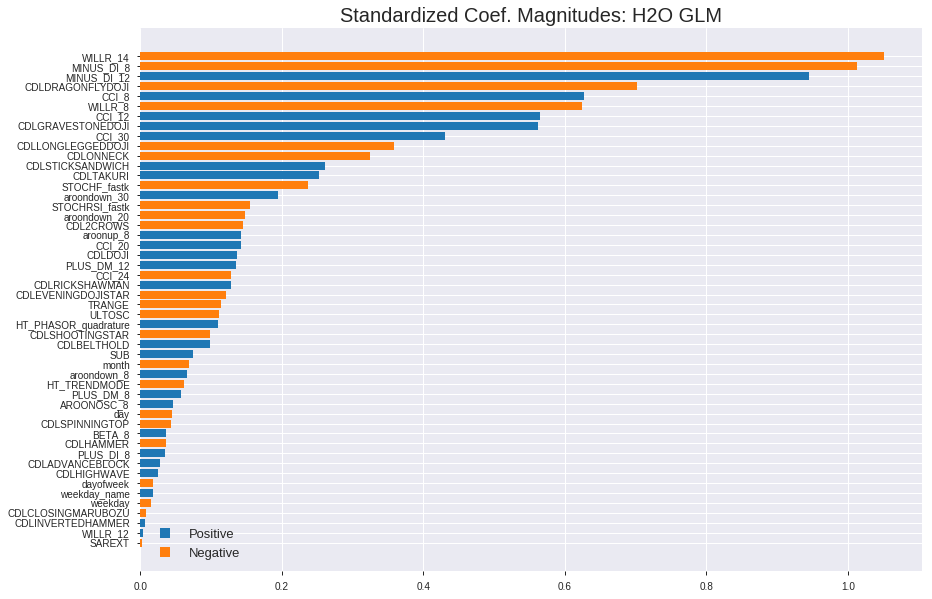

'log_likelihood'
--2019-08-22 16:15:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.129.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.129.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


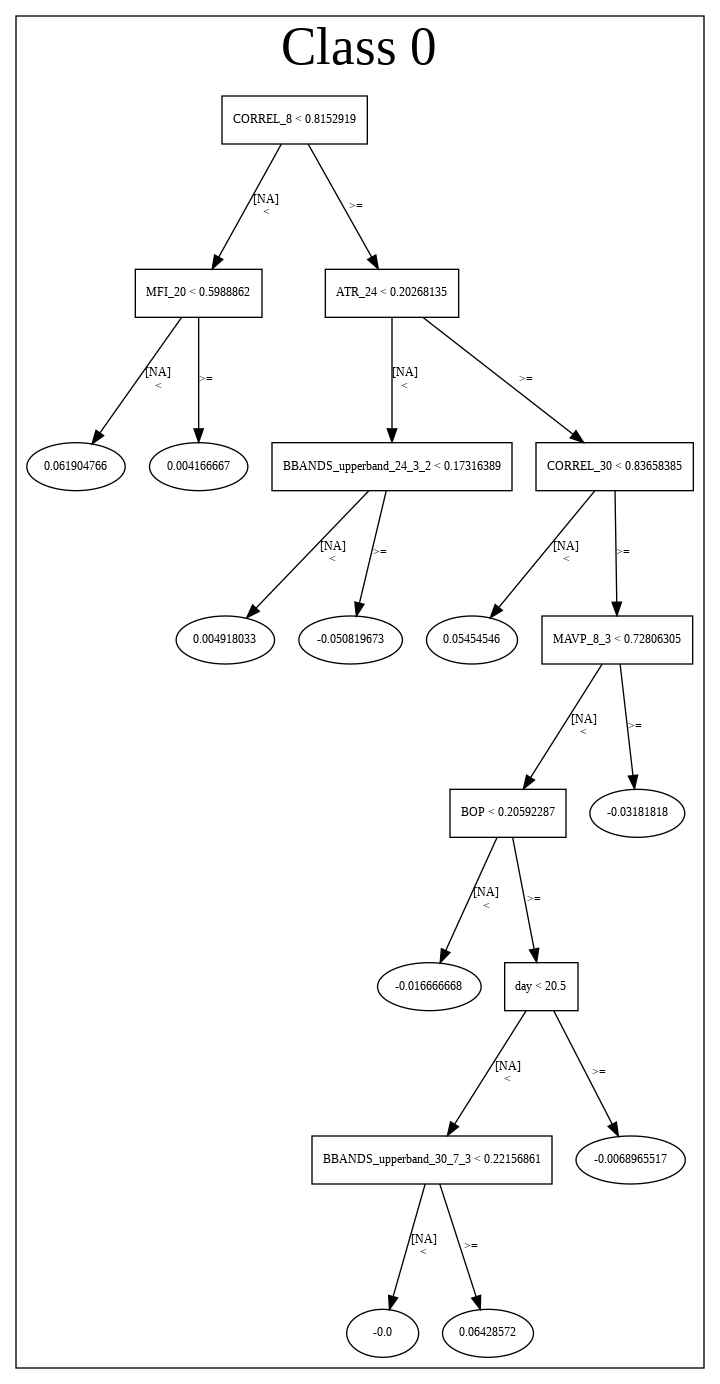

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_161535_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_161535_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_be46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['WILLR_14',
 'MINUS_DI_8',
 'MINUS_DI_12',
 'CDLDRAGONFLYDOJI',
 'CCI_8',
 'WILLR_8',
 'CCI_12',
 'CDLGRAVESTONEDOJI',
 'CCI_30',
 'CDLLONGLEGGEDDOJI',
 'CDLONNECK',
 'CDLSTICKSANDWICH',
 'CDLTAKURI',
 'STOCHF_fastk',
 'aroondown_30',
 'STOCHRSI_fastk',
 'aroondown_20',
 'CDL2CROWS',
 'aroonup_8',
 'CCI_20',
 'CDLDOJI',
 'PLUS_DM_12',
 'CCI_24',
 'CDLRICKSHAWMAN',
 'CDLEVENINGDOJISTAR',
 'TRANGE',
 'ULTOSC',
 'HT_PHASOR_quadrature',
 'CDLSHOOTINGSTAR',
 'CDLBELTHOLD',
 'SUB',
 'month',
 'aroondown_8',
 'HT_TRENDMODE',
 'PLUS_DM_8',
 'AROONOSC_8',
 'day',
 'CDLSPINNINGTOP',
 'BETA_8',
 'CDLHAMMER',
 'PLUS_DI_8',
 'CDLADVANCEBLOCK',
 'CDLHIGHWAVE',
 'dayofweek',
 'weekday_name',
 'weekday',
 'CDLCLOSINGMARUBOZU',
 'CDLINVERTEDHAMMER',
 'WILLR_12',
 'SAREXT']

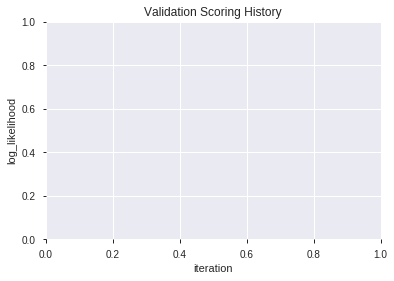

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_161547_model_3  0.829740  0.509613              0.231053  0.411819  0.169595
1               XGBoost_3_AutoML_20190822_161547  0.823511  0.518831              0.249038  0.416134  0.173167
2  XGBoost_grid_1_AutoML_20190822_161547_model_7  0.819481  0.519320              0.242504  0.417191  0.174048
3               XGBoost_2_AutoML_20190822_161547  0.819420  0.522482              0.242321  0.418113  0.174819
4  XGBoost_grid_1_AutoML_20190822_161547_model_4  0.818137  0.525022              0.249038  0.419808  0.176239
5               XGBoost_1_AutoML_20190822_161547  0.817160  0.522998              0.274840  0.418801  0.175394
6  XGBoost_grid_1_AutoML_20190822_161547_model_2  0.817038  0.517887              0.263939  0.418151  0.174851
7  XGBoost_grid_1_AutoML_20190822_161547_model_5  0.814168  0.528149              0.266473  0.422007  0.178090
8  XGBoost_grid_1_AutoML_20190822_161547_model_6  0.810992  0.526874              0.251939  0.421620  0.177763
9  XGBoost_grid_1_AutoML_20190822_161547_model_1  0.810137  0.530217              0.317710  0.422372  0.178398

variable  relative_importance  scaled_importance  percentage
0       CDLDRAGONFLYDOJI           963.265869           1.000000    0.108873
1      CDLGRAVESTONEDOJI           953.486633           0.989848    0.107768
2           STOCHF_fastk           558.168091           0.579454    0.063087
3                  CCI_8           525.514648           0.545555    0.059396
4                WILLR_8           467.885406           0.485728    0.052883
5                 ULTOSC           394.221985           0.409256    0.044557
6   HT_PHASOR_quadrature           314.354706           0.326343    0.035530
7               WILLR_14           310.578094           0.322422    0.035103
8                    SUB           267.379578           0.277576    0.030221
9             PLUS_DM_12           256.412079           0.266190    0.028981
10             PLUS_DI_8           250.301620           0.259847    0.028290
11                BETA_8           247.781937           0.257231    0.028006
12              WILLR_12           246.375992           0.255772    0.027847
13            MINUS_DI_8           231.041626           0.239852    0.026114
14                CCI_12           225.621567           0.234226    0.025501
15             CDLTAKURI           216.436676           0.224690    0.024463
16                CCI_20           207.822876           0.215748    0.023489
17             PLUS_DM_8           205.001526           0.212819    0.023170
18           MINUS_DI_12           200.870728           0.208531    0.022703
19                TRANGE           181.329407           0.188244    0.020495
20                CCI_24           170.281403           0.176775    0.019246
21                   day           149.701691           0.155411    0.016920
22                SAREXT           149.408371           0.155106    0.016887
23           aroondown_8           138.524750           0.143807    0.015657
24                CCI_30           132.415695           0.137465    0.014966
25            AROONOSC_8           109.889336           0.114080    0.012420
26          aroondown_30           109.767113           0.113953    0.012406
27                 month            97.392303           0.101106    0.011008
28          aroondown_20            83.870255           0.087069    0.009479
29             aroonup_8            73.671265           0.076481    0.008327
30        STOCHRSI_fastk            69.720139           0.072379    0.007880
31             dayofweek            60.966232           0.063291    0.006891
32        CDLRICKSHAWMAN            60.864433           0.063185    0.006879
33          weekday_name            44.665562           0.046369    0.005048
34               CDLDOJI            43.614555           0.045278    0.004930
35          HT_TRENDMODE            40.002483           0.041528    0.004521
36        CDLSPINNINGTOP            26.230686           0.027231    0.002965
37               weekday            17.879087           0.018561    0.002021
38           CDLBELTHOLD            13.019975           0.013516    0.001472
39     CDLLONGLEGGEDDOJI            11.860369           0.012313    0.001341
40       CDLSHOOTINGSTAR             9.844506           0.010220    0.001113
41           CDLHIGHWAVE             8.805771           0.009142    0.000995
42    CDLCLOSINGMARUBOZU             1.337208           0.001388    0.000151

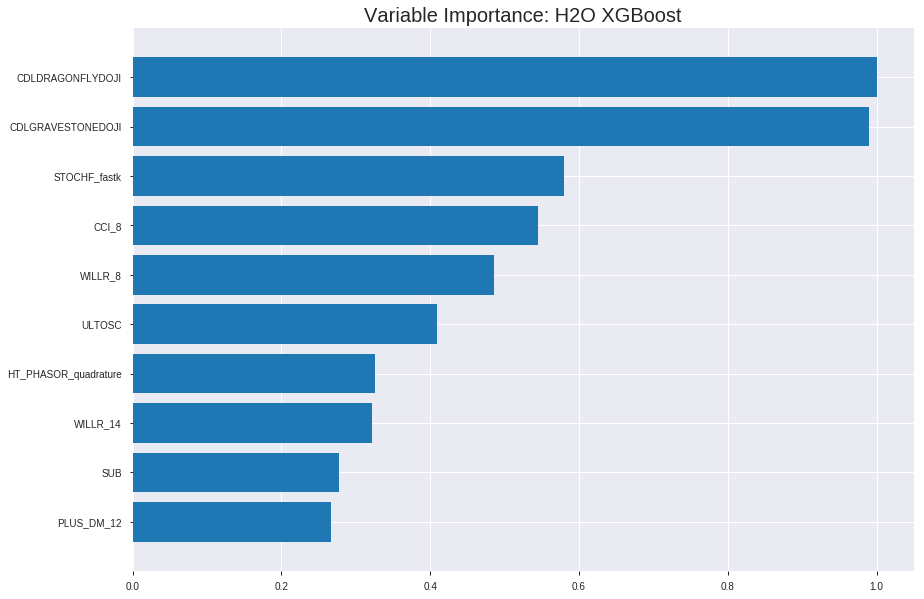

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_161547_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1250733973288607
RMSE: 0.3536571748584506
LogLoss: 0.4038126274061981
Mean Per-Class Error: 0.14872562137411482
AUC: 0.9325011108293941
pr_auc: 0.9349931743783477
Gini: 0.8650022216587883
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4789296090602875: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      677  176   0.2063   (176.0/853.0)
1      91   843   0.0974   (91.0/934.0)
Total  768  1019  0.1494   (267.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.47893      0.863287  218
max f2                       0.38155      0.913568  265
max f0point5                 0.572623     0.873131  178
max accuracy                 0.511625     0.851707  203
max precision                0.96998      1         0
max recall                   0.165495     1         349
max specificity              0.96998      1         0
max absolute_mcc             0.511625     0.702738  203
max min_per_class_accuracy   0.518989     0.845824  199
max mean_per_class_accuracy  0.511625     0.851274  203

Gains/Lift Table: Avg response rate: 52.27 %, avg score: 52.32 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.958332           1.91328    1.91328            1                0.965524   1                           0.965524            0.0192719       0.0192719                  91.3276   91.3276
    2        0.0201455                   0.952114           1.91328    1.91328            1                0.954498   1                           0.960011            0.0192719       0.0385439                  91.3276   91.3276
    3        0.0302182                   0.946724           1.91328    1.91328            1                0.950003   1                           0.956675            0.0192719       0.0578158                  91.3276   91.3276
    4        0.040291                    0.941924           1.91328    1.91328            1                0.944559   1                           0.953646            0.0192719       0.0770878                  91.3276   91.3276
    5        0.0503637                   0.936067           1.91328    1.91328            1                0.939433   1                           0.950803            0.0192719       0.0963597                  91.3276   91.3276
    6        0.100168                    0.886796           1.91328    1.91328            1                0.915018   1                           0.933011            0.0952891       0.191649                   91.3276   91.3276
    7        0.149972                    0.830224           1.91328    1.91328            1                0.858099   1                           0.908134            0.0952891       0.286938                   91.3276   91.3276
    8        0.200336                    0.780013           1.87076    1.90259            0.977778         0.802847   0.994413                    0.881665            0.0942184       0.381156                   87.0759   90.2588
    9        0.299944                    0.68756            1.7198     1.84189            0.898876         0.727605   0.962687                    0.830503            0.171306        0.552463                   71.9799   84.1885
    10       0.400112                    0.610604           1.54986    1.76878            0.810056         0.647346   0.924476                    0.78465             0.155246        0.707709                   54.9861   76.8777
    11       0.50028                     0.532009           1.20782    1.65646            0.631285         0.572162   0.865772                    0.742105            0.120985        0.828694                   20.7822   65.6461
    12       0.599888                    0.454701           0.935141   1.53669            0.488764         0.49289    0.803172                    0.700724            0.0931478       0.921842                   -6.48594  53.6689
    13       0.700056                    0.374039           0.513057   1.39022            0.268156         0.416122   0.726619                    0.660001            0.0513919       0.973233                   -48.6943  39.0222
    14       0.799664                    0.273603           0.193477   1.24115            0.101124         0.327738   0.648705                    0.618614            0.0192719       0.992505                   -80.6523  24.1153
    15       0.899832                    0.127642           0.0748209  1.11132            0.0391061        0.202491   0.580846                    0.572292            0.00749465      1                          -92.5179  11.1318
    16       1                           0.0280903          0          1                  0                0.0821902  0.522664 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.17070411463686347
RMSE: 0.4131635446610258
LogLoss: 0.5138289257711642
Mean Per-Class Error: 0.24290966386554624
AUC: 0.826031883341572
pr_auc: 0.8278240144127861
Gini: 0.6520637666831439
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44579872488975525: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      149  89   0.3739   (89.0/238.0)
1      39   233  0.1434   (39.0/272.0)
Total  188  322  0.251    (128.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.445799     0.784512  249
max f2                       0.172457     0.87281   354
max f0point5                 0.610568     0.786364  157
max accuracy                 0.552362     0.754902  187
max precision                0.970297     1         0
max recall                   0.090478     1         382
max specificity              0.970297     1         0
max absolute_mcc             0.552362     0.513289  187
max min_per_class_accuracy   0.530437     0.747899  201
max mean_per_class_accuracy  0.552362     0.75709   187

Gains/Lift Table: Avg response rate: 53.33 %, avg score: 53.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.962475           1.875     1.875              1                0.967523  1                           0.967523            0.0220588       0.0220588                  87.5      87.5
    2        0.0215686                   0.94817            1.5       1.70455            0.8              0.953393  0.909091                    0.9611              0.0147059       0.0367647                  50        70.4545
    3        0.0313725                   0.943747           1.875     1.75781            1                0.945011  0.9375                      0.956072            0.0183824       0.0551471                  87.5      75.7812
    4        0.0411765                   0.937638           1.5       1.69643            0.8              0.9414    0.904762                    0.952579            0.0147059       0.0698529                  50        69.6429
    5        0.0509804                   0.936025           1.875     1.73077            1                0.936594  0.923077                    0.949505            0.0183824       0.0882353                  87.5      73.0769
    6        0.1                         0.897632           1.8       1.76471            0.96             0.916068  0.941176                    0.933114            0.0882353       0.176471                   80        76.4706
    7        0.15098                     0.844137           1.73077   1.75325            0.923077         0.877307  0.935065                    0.91427             0.0882353       0.264706                   73.0769   75.3247
    8        0.2                         0.796881           1.575     1.70956            0.84             0.824467  0.911765                    0.89226             0.0772059       0.341912                   57.5      70.9559
    9        0.3                         0.712531           1.36029   1.59314            0.72549          0.74451   0.849673                    0.84301             0.136029        0.477941                   36.0294   59.3137
    10       0.4                         0.61352            1.47059   1.5625             0.784314         0.661114  0.833333                    0.797536            0.147059        0.625                      47.0588   56.25
    11       0.5                         0.539242           1.06618   1.46324            0.568627         0.576912  0.780392                    0.753411            0.106618        0.731618                   6.61765   46.3235
    12       0.6                         0.46594            0.955882  1.37868            0.509804         0.506372  0.735294                    0.712238            0.0955882       0.827206                   -4.41176  37.8676
    13       0.7                         0.390368           0.588235  1.26576            0.313725         0.430661  0.67507                     0.672013            0.0588235       0.886029                   -41.1765  26.5756
    14       0.8                         0.281356           0.698529  1.19485            0.372549         0.339097  0.637255                    0.630398            0.0698529       0.955882                   -30.1471  19.4853
    15       0.9                         0.157797           0.330882  1.09886            0.176471         0.220619  0.586057                    0.584867            0.0330882       0.988971                   -66.9118  9.88562
    16       1                           0.0430739          0.110294  1                  0.0588235        0.1019    0.533333                    0.536571            0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:15:55  2.296 sec   0                  0.5              0.693147            0.5             0                  1                0.477336                         0.5                0.693147              0.5               0                    1                  0.466667
    2019-08-22 16:15:55  2.359 sec   5                  0.473619         0.641237            0.806795        0.802979           1.91328          0.294348                         0.473822           0.641629              0.792102          0.803509             1.875              0.329412
    2019-08-22 16:15:55  2.404 sec   10                 0.455084         0.60487             0.840174        0.852294           1.91328          0.259653                         0.457865           0.610176              0.80741           0.817715             1.5625             0.298039
    2019-08-22 16:15:55  2.452 sec   15                 0.441037         0.576647            0.844158        0.858215           1.91328          0.252938                         0.444821           0.584115              0.821483          0.831462             1.5625             0.276471
    2019-08-22 16:15:55  2.508 sec   20                 0.430813         0.555223            0.847292        0.861268           1.91328          0.256855                         0.437773           0.568799              0.816802          0.833695             1.875              0.264706
    2019-08-22 16:15:55  2.563 sec   25                 0.422181         0.536739            0.85516         0.867997           1.91328          0.249021                         0.431632           0.555144              0.820502          0.834788             1.875              0.256863
    2019-08-22 16:15:55  2.618 sec   30                 0.413682         0.519105            0.86442         0.874722           1.91328          0.238948                         0.426545           0.544127              0.822711          0.831589             1.875              0.245098
    2019-08-22 16:15:55  2.675 sec   35                 0.407092         0.505501            0.871522        0.879785           1.91328          0.226637                         0.424237           0.538656              0.820432          0.828709             1.875              0.243137
    2019-08-22 16:15:55  2.736 sec   40                 0.399673         0.490951            0.88223         0.892461           1.91328          0.212087                         0.420547           0.531026              0.825677          0.833115             1.875              0.247059
    2019-08-22 16:15:55  2.798 sec   45                 0.392741         0.477272            0.889838        0.899237           1.91328          0.206491                         0.418448           0.526138              0.824997          0.826541             1.875              0.25098
    2019-08-22 16:15:55  2.865 sec   50                 0.387718         0.467071            0.895205        0.904575           1.91328          0.195299                         0.416534           0.521664              0.82726           0.834322             1.875              0.24902
    2019-08-22 16:15:55  2.938 sec   55                 0.382322         0.456445            0.900607        0.906397           1.91328          0.185227                         0.414491           0.517455              0.829446          0.8

Variable Importances: 


variable            relative_importance    scaled_importance     percentage
------------------  ---------------------  --------------------  ---------------------
CDLDRAGONFLYDOJI    963.265869140625       1.0                   0.10887331999941575
CDLGRAVESTONEDOJI   953.4866333007812      0.9898478331339942    0.10776801988752564
STOCHF_fastk        558.1680908203125      0.5794538233959028    0.06308706153946707
CCI_8               525.5146484375         0.5455551424305487    0.059396399599167975
WILLR_8             467.8854064941406      0.4857282101270372    0.05288284285390438
---                 ---                    ---                   ---
CDLBELTHOLD         13.019974708557129     0.013516491267538486  0.0014715852790400264
CDLLONGLEGGEDDOJI   11.860368728637695     0.012312663729297178  0.0013405205782449714
CDLSHOOTINGSTAR     9.84450626373291       0.010219926376625032  0.0011126773147727667
CDLHIGHWAVE         8.805770874023438      0.009141578826912534  0.0009952740369223321
CDLCLOSINGMARUBOZU  1.3372077941894531     0.001388202195290527  0.000151138181831757


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.76953125)

('F1', 0.7591836734693876)

('auc', 0.8297404580152672)

('logloss', 0.5096134426401036)

('mean_per_class_error', 0.23105343511450382)

('rmse', 0.41181857399727645)

('mse', 0.16959453788915027)

xgboost prediction progress: |████████████████████████████████████████████| 100%


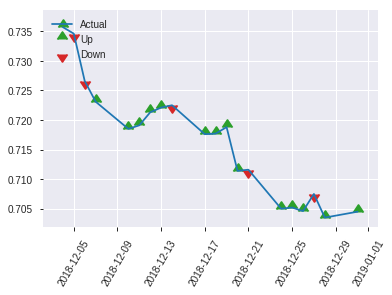


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.16959453788915027
RMSE: 0.41181857399727645
LogLoss: 0.5096134426401036
Mean Per-Class Error: 0.23105343511450382
AUC: 0.8297404580152672
pr_auc: 0.8037659019917374
Gini: 0.6594809160305344
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5293722152709961: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      104  27   0.2061   (27.0/131.0)
1      32   93   0.256    (32.0/125.0)
Total  136  120  0.2305   (59.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.529372     0.759184  119
max f2                       0.198976     0.861111  219
max f0point5                 0.598339     0.780952  99
max accuracy                 0.529372     0.769531  119
max precision                0.965118     1         0
max recall                   0.151852     1         226
max specificity              0.965118     1         0
max absolute_mcc             0.529372     0.538799  119
max min_per_class_accuracy   0.518042     0.755725  126
max mean_per_class_accuracy  0.529372     0.768947  119

Gains/Lift Table: Avg response rate: 48.83 %, avg score: 50.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.952862           2.048     2.048              1                0.96101    1                           0.96101             0.024           0.024                      104.8     104.8
    2        0.0234375                   0.936882           1.36533   1.70667            0.666667         0.943787   0.833333                    0.952399            0.016           0.04                       36.5333   70.6667
    3        0.03125                     0.930904           1.024     1.536              0.5              0.933155   0.75                        0.947588            0.008           0.048                      2.4       53.6
    4        0.0429688                   0.917559           2.048     1.67564            1                0.925032   0.818182                    0.941436            0.024           0.072                      104.8     67.5636
    5        0.0507812                   0.913222           2.048     1.73292            1                0.914302   0.846154                    0.937262            0.016           0.088                      104.8     73.2923
    6        0.101562                    0.864167           2.048     1.89046            1                0.891914   0.923077                    0.914588            0.104           0.192                      104.8     89.0462
    7        0.152344                    0.812657           1.89046   1.89046            0.923077         0.837777   0.923077                    0.888985            0.096           0.288                      89.0462   89.0462
    8        0.203125                    0.754255           1.73292   1.85108            0.846154         0.775134   0.903846                    0.860522            0.088           0.376                      73.2923   85.1077
    9        0.300781                    0.681398           1.47456   1.72883            0.72             0.714655   0.844156                    0.813163            0.144           0.52                       47.456    72.8831
    10       0.402344                    0.595866           1.41785   1.65033            0.692308         0.630613   0.805825                    0.767082            0.144           0.664                      41.7846   65.033
    11       0.5                         0.515646           1.06496   1.536              0.52             0.546391   0.75                        0.723979            0.104           0.768                      6.496     53.6
    12       0.601562                    0.420215           0.630154  1.38306            0.307692         0.466907   0.675325                    0.680577            0.064           0.832                      -36.9846  38.3065
    13       0.699219                    0.3544             0.8192    1.30431            0.4              0.391686   0.636872                    0.640229            0.08            0.912                      -18.08    30.4313
    14       0.800781                    0.257994           0.393846  1.18884            0.192308         0.308609   0.580488                    0.59817             0.04            0.952                      -60.6154  18.8839
    15       0.898438                    0.129407           0.49152   1.11304            0.24             0.20411    0.543478                    0.555337            0.048           1                          -50.848   11.3043
    16       1                           0.0327624          0         1                  0                0.0793875  0.488281                    0.506999

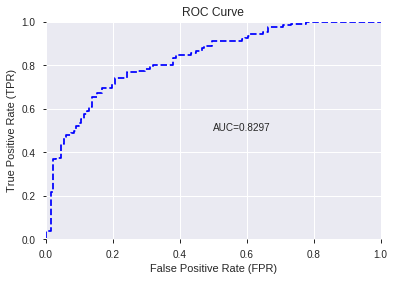

This function is available for GLM models only


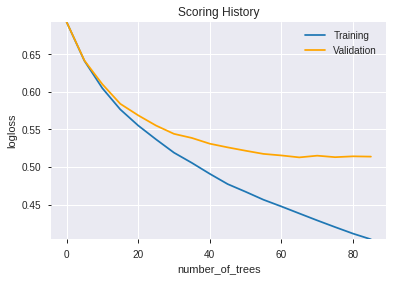

--2019-08-22 16:16:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.98.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.98.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

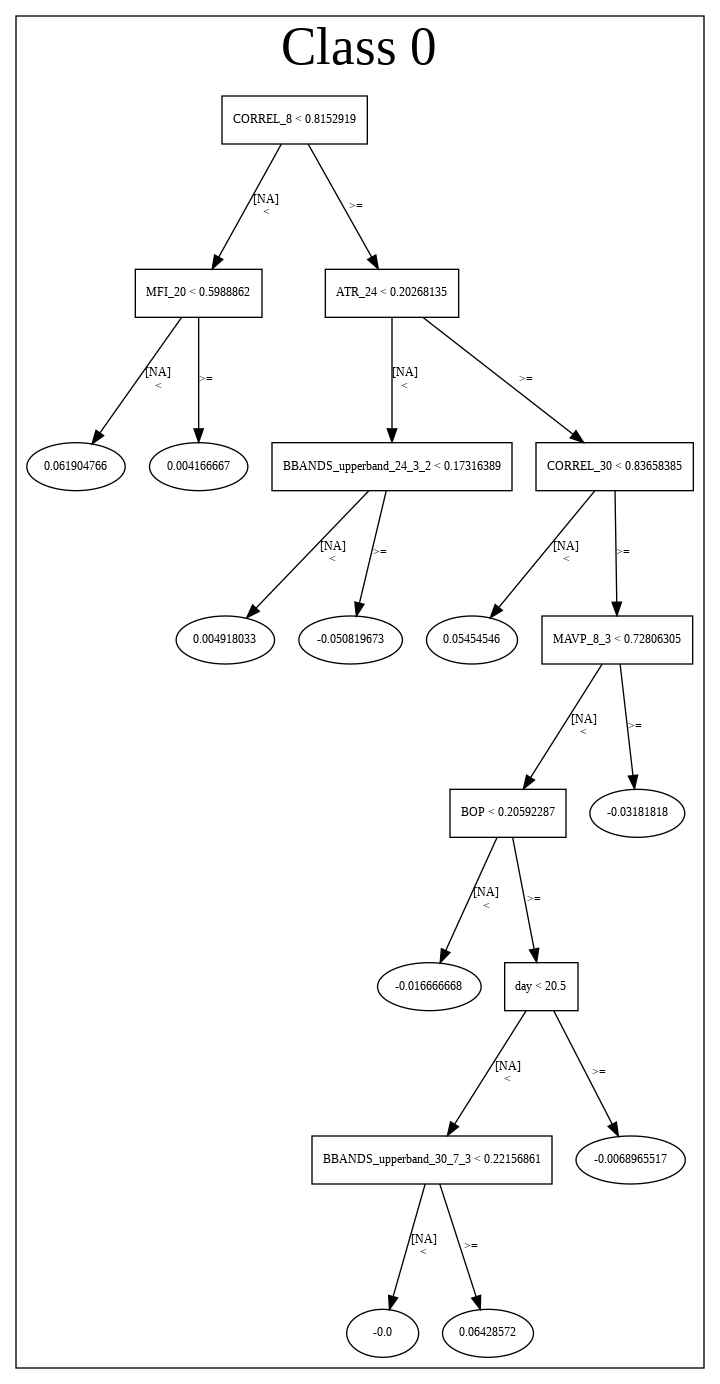

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_161547_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_161547_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_be46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'STOCHF_fastk',
 'CCI_8',
 'WILLR_8',
 'ULTOSC',
 'HT_PHASOR_quadrature',
 'WILLR_14',
 'SUB',
 'PLUS_DM_12',
 'PLUS_DI_8',
 'BETA_8',
 'WILLR_12',
 'MINUS_DI_8',
 'CCI_12',
 'CDLTAKURI',
 'CCI_20',
 'PLUS_DM_8',
 'MINUS_DI_12',
 'TRANGE',
 'CCI_24',
 'day',
 'SAREXT',
 'aroondown_8',
 'CCI_30',
 'AROONOSC_8',
 'aroondown_30',
 'month',
 'aroondown_20',
 'aroonup_8',
 'STOCHRSI_fastk',
 'dayofweek',
 'CDLRICKSHAWMAN',
 'weekday_name',
 'CDLDOJI',
 'HT_TRENDMODE',
 'CDLSPINNINGTOP',
 'weekday',
 'CDLBELTHOLD',
 'CDLLONGLEGGEDDOJI',
 'CDLSHOOTINGSTAR',
 'CDLHIGHWAVE',
 'CDLCLOSINGMARUBOZU']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190822_161614_model_1  0.824427  0.51888              0.281374  0.413352  0.17086

variable  relative_importance  scaled_importance  percentage
0                  MINUS_DI_8             0.648231           1.000000    0.012729
1           CDLGRAVESTONEDOJI             0.521956           0.805200    0.010249
2                    SAR_0.24             0.514857           0.794249    0.010110
3                    WILLR_14             0.506951           0.782054    0.009954
4                      CCI_12             0.496294           0.765613    0.009745
...                       ...                  ...                ...         ...
1021                CORREL_20             0.000160           0.000247    0.000003
1022  BBANDS_lowerband_12_2_2             0.000128           0.000197    0.000003
1023                MAVP_12_0             0.000090           0.000138    0.000002
1024  BBANDS_upperband_20_3_4             0.000087           0.000134    0.000002
1025  BBANDS_lowerband_12_1_2             0.000059           0.000091    0.000001

[1026 rows x 4 columns]

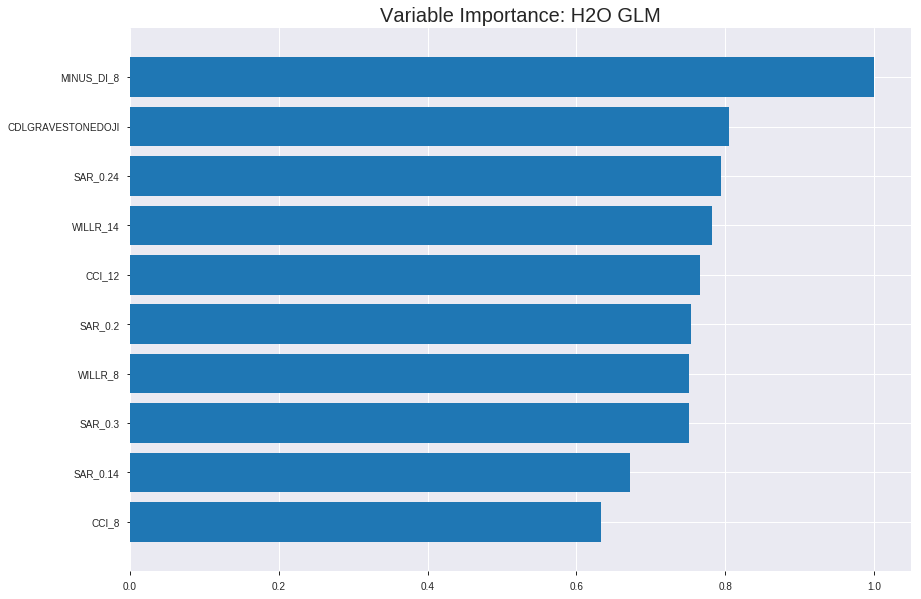

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_161614_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1599673492717832
RMSE: 0.3999591845073484
LogLoss: 0.48244237223460534
Null degrees of freedom: 1786
Residual degrees of freedom: 760
Null deviance: 2473.635248547511
Residual deviance: 1724.2490383664797
AIC: 3778.24903836648
AUC: 0.8469283370695694
pr_auc: 0.8564033386475778
Gini: 0.6938566741391388
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4821019739474865: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      599  254   0.2978   (254.0/853.0)
1      168  766   0.1799   (168.0/934.0)
Total  767  1020  0.2361   (422.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.482102     0.784033  216
max f2                       0.156547     0.874597  340
max f0point5                 0.5652       0.791258  180
max accuracy                 0.525359     0.771125  197
max precision                0.997901     1         0
max recall                   0.0404316    1         385
max specificity              0.997901     1         0
max absolute_mcc             0.542216     0.541869  190
max min_per_class_accuracy   0.525359     0.76905   197
max mean_per_class_accuracy  0.542216     0.771211  190

Gains/Lift Table: Avg response rate: 52.27 %, avg score: 52.27 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.98299            1.91328    1.91328            1                0.989404   1                           0.989404            0.0192719       0.0192719                  91.3276   91.3276
    2        0.0201455                   0.976487           1.91328    1.91328            1                0.979452   1                           0.984428            0.0192719       0.0385439                  91.3276   91.3276
    3        0.0302182                   0.969835           1.80698    1.87785            0.944444         0.973324   0.981481                    0.980727            0.0182013       0.0567452                  80.6983   87.7845
    4        0.040291                    0.963534           1.91328    1.8867             1                0.966619   0.986111                    0.9772              0.0192719       0.0760171                  91.3276   88.6703
    5        0.0503637                   0.954598           1.80698    1.87076            0.944444         0.959696   0.977778                    0.973699            0.0182013       0.0942184                  80.6983   87.0759
    6        0.100168                    0.916059           1.80579    1.83846            0.94382          0.934403   0.960894                    0.954161            0.0899358       0.184154                   80.5789   83.8455
    7        0.149972                    0.865699           1.7413     1.80619            0.910112         0.890843   0.94403                     0.933134            0.0867238       0.270878                   74.1296   80.619
    8        0.200336                    0.800537           1.72195    1.78501            0.9              0.831235   0.932961                    0.907517            0.0867238       0.357602                   72.1949   78.5012
    9        0.299944                    0.709189           1.52632    1.6991             0.797753         0.751541   0.88806                     0.855719            0.152034        0.509636                   52.6321   69.9104
    10       0.400112                    0.621141           1.19713    1.57344            0.625698         0.663274   0.822378                    0.80754             0.119914        0.62955                    19.7134   57.3436
    11       0.50028                     0.538906           1.28264    1.51521            0.670391         0.580273   0.791946                    0.762036            0.12848         0.75803                    28.2643   51.5212
    12       0.599888                    0.452601           0.773909   1.39212            0.404494         0.495245   0.727612                    0.717737            0.0770878       0.835118                   -22.6091  39.2123
    13       0.700056                    0.347808           0.748209   1.29999            0.391061         0.399638   0.679456                    0.672221            0.0749465       0.910064                   -25.1791  29.9988
    14       0.799664                    0.234578           0.548186   1.20634            0.286517         0.295532   0.630511                    0.6253              0.0546039       0.964668                   -45.1814  20.6341
    15       0.899832                    0.103528           0.277906   1.10299            0.145251         0.168939   0.576493                    0.574498            0.0278373       0.992505                   -72.2094  10.2989
    16       1                           0.00117149         0.0748209  1                  0.0391061        0.0570191  0.522664  



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.17048698588327119
RMSE: 0.41290069736350793
LogLoss: 0.5176716839186875
Null degrees of freedom: 509
Residual degrees of freedom: -517
Null deviance: 704.9746584600862
Residual deviance: 528.0251175970612
AIC: 2582.025117597061
AUC: 0.8238924246169056
pr_auc: 0.8326520252565635
Gini: 0.6477848492338112
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30263227545931914: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      115  123  0.5168   (123.0/238.0)
1      20   252  0.0735   (20.0/272.0)
Total  135  375  0.2804   (143.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.302632     0.77898   288
max f2                       0.218546     0.875499  319
max f0point5                 0.712847     0.779221  123
max accuracy                 0.461381     0.752941  225
max precision                0.999145     1         0
max recall                   0.0190672    1         395
max specificity              0.999145     1         0
max absolute_mcc             0.45415      0.502635  227
max min_per_class_accuracy   0.52855      0.738971  203
max mean_per_class_accuracy  0.461381     0.749475  225

Gains/Lift Table: Avg response rate: 53.33 %, avg score: 52.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.991811           1.875     1.875              1                0.995673   1                           0.995673            0.0220588       0.0220588                  87.5      87.5
    2        0.0215686                   0.980639           1.5       1.70455            0.8              0.985436   0.909091                    0.99102             0.0147059       0.0367647                  50        70.4545
    3        0.0313725                   0.976208           1.875     1.75781            1                0.978513   0.9375                      0.987111            0.0183824       0.0551471                  87.5      75.7812
    4        0.0411765                   0.966128           1.875     1.78571            1                0.972079   0.952381                    0.983532            0.0183824       0.0735294                  87.5      78.5714
    5        0.0509804                   0.954043           1.875     1.80288            1                0.958861   0.961538                    0.978788            0.0183824       0.0919118                  87.5      80.2885
    6        0.1                         0.925232           1.65      1.72794            0.88             0.942726   0.921569                    0.96111             0.0808824       0.172794                   65        72.7941
    7        0.15098                     0.883744           1.80288   1.75325            0.961538         0.90352    0.935065                    0.941664            0.0919118       0.264706                   80.2885   75.3247
    8        0.2                         0.834323           1.575     1.70956            0.84             0.8573     0.911765                    0.920987            0.0772059       0.341912                   57.5      70.9559
    9        0.3                         0.732263           1.58088   1.66667            0.843137         0.781721   0.888889                    0.874565            0.158088        0.5                        58.0882   66.6667
    10       0.4                         0.641531           1.10294   1.52574            0.588235         0.684971   0.813725                    0.827166            0.110294        0.610294                   10.2941   52.5735
    11       0.5                         0.549157           1.06618   1.43382            0.568627         0.595021   0.764706                    0.780737            0.106618        0.716912                   6.61765   43.3824
    12       0.6                         0.432574           1.02941   1.36642            0.54902          0.485533   0.728758                    0.731537            0.102941        0.819853                   2.94118   36.6422
    13       0.7                         0.341341           0.772059  1.28151            0.411765         0.383343   0.683473                    0.681795            0.0772059       0.897059                   -22.7941  28.1513
    14       0.8                         0.231113           0.588235  1.19485            0.313725         0.282742   0.637255                    0.631913            0.0588235       0.955882                   -41.1765  19.4853
    15       0.9                         0.112175           0.257353  1.09069            0.137255         0.164138   0.581699                    0.579938            0.0257353       0.981618                   -74.2647  9.06863
    16       1                           0.0118719          0.183824  1                  0.0980392        0.0565623  0.533333                    0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 16:16:17  0.000 sec   2            .16E2     1006          1.3590486237556825  1.3588164575263049
     2019-08-22 16:16:19  2.097 sec   4            .11E2     1023          1.3510883530082374  1.3510313172613155
     2019-08-22 16:16:21  4.042 sec   6            .83E1     1027          1.3408655904908031  1.3410146192756125
     2019-08-22 16:16:23  6.001 sec   8            .61E1     1027          1.3279645655532943  1.328406071463648
     2019-08-22 16:16:25  7.975 sec   10           .44E1     1027          1.3121237775261336  1.312917085319787
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 16:17:08  50.995 sec  52           .56E-2    1027          0.9791240114057445  1.0357941760411848
     2019-08-22 16:17:10  53.018 sec  54           .41E-2    1027          0.9719209987063302  1.0353467130818559
     2019-08-22 16:17:12  55.010 sec  56           .3E-2     1027          0.964884744469211   1.035343367837375
     2019-08-22 16:17:14  57.013 sec  58           .22E-2    1027          0.9580423821012798  1.0355705918056108
     2019-08-22 16:17:16  59.051 sec  60           .16E-2    1027          0.9512368010881334  1.0356796248402564


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.765625)

('F1', 0.7508532423208192)

('auc', 0.8244274809160306)

('logloss', 0.518880063580758)

('mean_per_class_error', 0.237618320610687)

('rmse', 0.4133523192624512)

('mse', 0.1708601398396474)

glm prediction progress: |████████████████████████████████████████████████| 100%


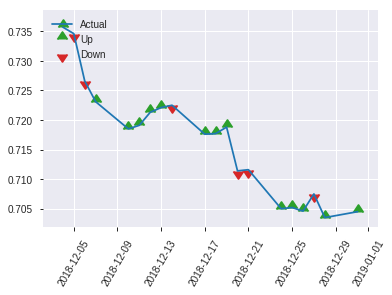


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1708601398396474
RMSE: 0.4133523192624512
LogLoss: 0.518880063580758
Null degrees of freedom: 255
Residual degrees of freedom: -771
Null deviance: 355.96216876159656
Residual deviance: 265.6665925533481
AIC: 2319.666592553348
AUC: 0.8244274809160306
pr_auc: 0.8118389076793262
Gini: 0.6488549618320612
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30133529499434886: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      73   58   0.4427   (58.0/131.0)
1      15   110  0.12     (15.0/125.0)
Total  88   168  0.2852   (73.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.301335     0.750853  167
max f2                       0.171597     0.856115  194
max f0point5                 0.597697     0.800416  88
max accuracy                 0.597697     0.765625  88
max precision                0.996558     1         0
max recall                   0.0200763    1         249
max specificity              0.996558     1         0
max absolute_mcc             0.597697     0.550424  88
max min_per_class_accuracy   0.438477     0.728     121
max mean_per_class_accuracy  0.588528     0.762382  90

Gains/Lift Table: Avg response rate: 48.83 %, avg score: 45.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.972814           2.048     2.048              1                0.987892   1                           0.987892            0.024           0.024                      104.8     104.8
    2        0.0234375                   0.96521            2.048     2.048              1                0.967531   1                           0.977711            0.024           0.048                      104.8     104.8
    3        0.03125                     0.958044           1.024     1.792              0.5              0.962894   0.875                       0.974007            0.008           0.056                      2.4       79.2
    4        0.0429688                   0.9433             2.048     1.86182            1                0.948755   0.909091                    0.96712             0.024           0.08                       104.8     86.1818
    5        0.0507812                   0.941579           2.048     1.89046            1                0.942636   0.923077                    0.963353            0.016           0.096                      104.8     89.0462
    6        0.101562                    0.908782           1.89046   1.89046            0.923077         0.925968   0.923077                    0.94466             0.096           0.192                      89.0462   89.0462
    7        0.152344                    0.844982           1.89046   1.89046            0.923077         0.875383   0.923077                    0.921568            0.096           0.288                      89.0462   89.0462
    8        0.203125                    0.753747           1.73292   1.85108            0.846154         0.805366   0.903846                    0.892518            0.088           0.376                      73.2923   85.1077
    9        0.300781                    0.647812           1.6384    1.78203            0.8              0.696843   0.87013                     0.828987            0.16            0.536                      63.84     78.2026
    10       0.402344                    0.521996           1.18154   1.63045            0.576923         0.583407   0.796117                    0.766996            0.12            0.656                      18.1538   63.0447
    11       0.5                         0.425259           0.8192    1.472              0.4              0.47437    0.71875                     0.709842            0.08            0.736                      -18.08    47.2
    12       0.601562                    0.36445            0.866462  1.36977            0.423077         0.39144    0.668831                    0.656086            0.088           0.824                      -13.3538  36.9766
    13       0.699219                    0.238683           0.65536   1.26999            0.32             0.303821   0.620112                    0.606887            0.064           0.888                      -34.464   26.9989
    14       0.800781                    0.141056           0.630154  1.18884            0.307692         0.183087   0.580488                    0.553137            0.064           0.952                      -36.9846  18.8839
    15       0.898438                    0.0712785          0.32768   1.09523            0.16             0.107453   0.534783                    0.504693            0.032           0.984                      -67.232   9.52348
    16       1                           0.00870877         0.157538  1                  0.0769231        0.0365793  0.488281                    0.45715  

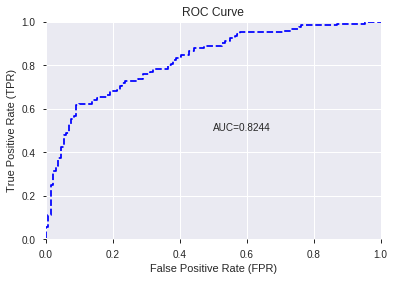

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


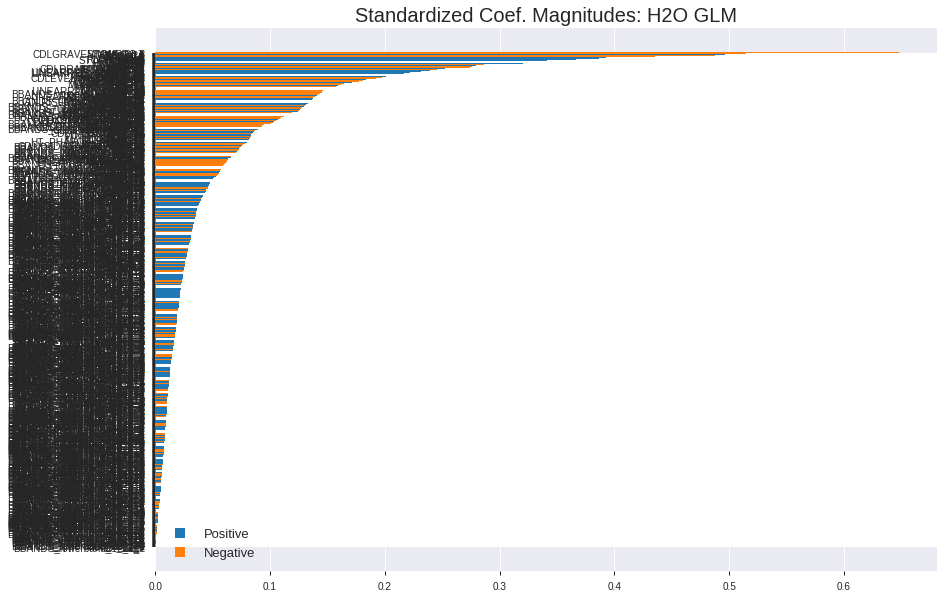

'log_likelihood'
--2019-08-22 16:17:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


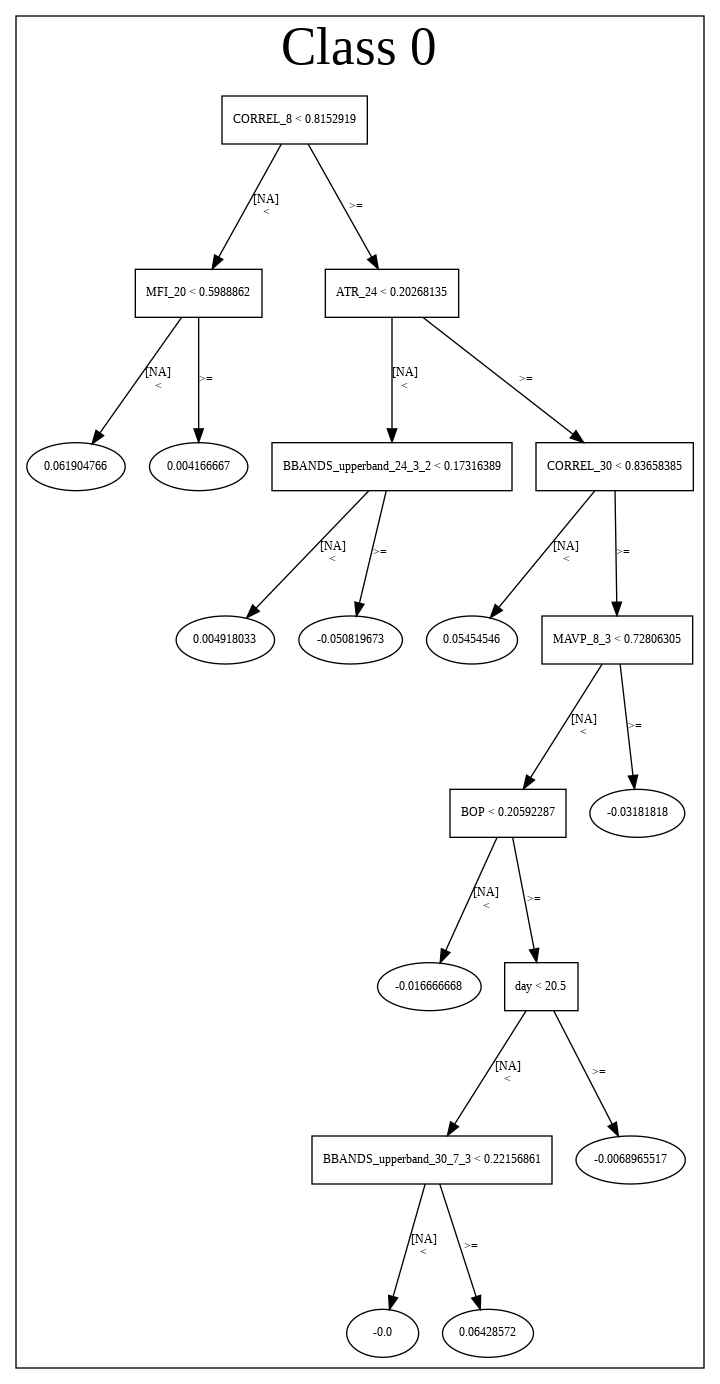

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_161614_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_161614_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_be46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

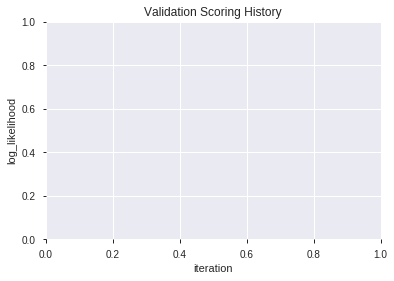

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_161744_model_5  0.834992  0.497867              0.235939  0.408839  0.167150
1               XGBoost_2_AutoML_20190822_161744  0.821679  0.519174              0.252122  0.416507  0.173478
2  XGBoost_grid_1_AutoML_20190822_161744_model_3  0.819115  0.521270              0.236855  0.417679  0.174456
3  XGBoost_grid_1_AutoML_20190822_161744_model_2  0.819115  0.517106              0.251389  0.417130  0.173997
4  XGBoost_grid_1_AutoML_20190822_161744_model_6  0.818687  0.516754              0.259939  0.416929  0.173830
5               XGBoost_1_AutoML_20190822_161744  0.815023  0.525082              0.248305  0.418201  0.174892
6               XGBoost_3_AutoML_20190822_161744  0.813374  0.519518              0.249038  0.418790  0.175385
7  XGBoost_grid_1_AutoML_20190822_161744_model_7  0.811664  0.526797              0.266656  0.421109  0.177333
8  XGBoost_grid_1_AutoML_20190822_161744_model_1  0.810992  0.525711              0.263573  0.421067  0.177297
9  XGBoost_grid_1_AutoML_20190822_161744_model_4  0.808305  0.530078              0.270840  0.422230  0.178278

variable  relative_importance  scaled_importance  percentage
0         CDLGRAVESTONEDOJI           906.149353           1.000000    0.032859
1          CDLDRAGONFLYDOJI           746.611816           0.823939    0.027074
2                    ULTOSC           554.945984           0.612422    0.020124
3              STOCHF_fastk           547.769653           0.604503    0.019863
4                 dayofyear           476.602722           0.525965    0.017283
..                      ...                  ...                ...         ...
648                  MA_8_6             0.427722           0.000472    0.000016
649                  MA_8_0             0.423098           0.000467    0.000015
650  BBANDS_upperband_8_2_2             0.414342           0.000457    0.000015
651             MIDPRICE_20             0.306964           0.000339    0.000011
652               MAVP_12_5             0.148153           0.000163    0.000005

[653 rows x 4 columns]

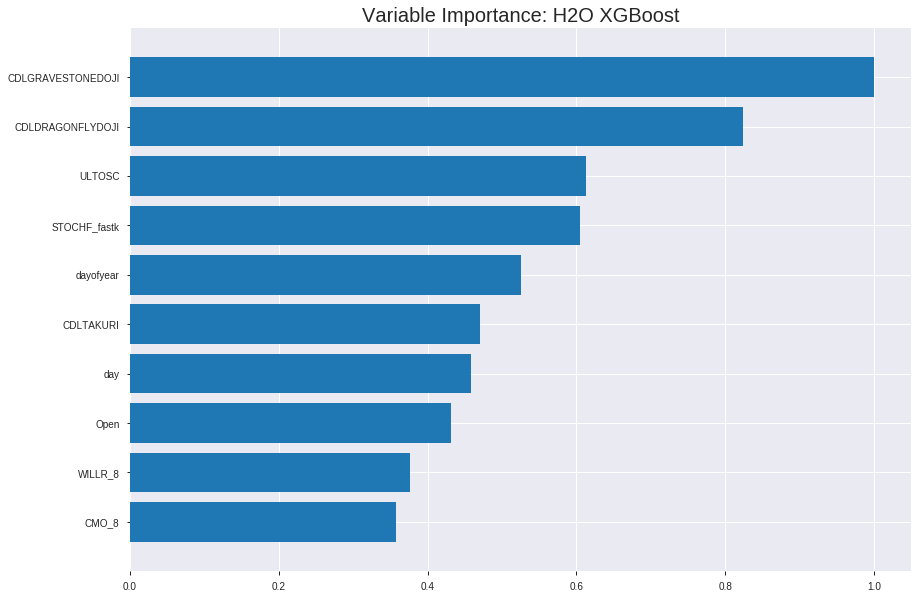

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_161744_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.014520471192510884
RMSE: 0.12050091780775317
LogLoss: 0.11025234850032686
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9978586723768736
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5498670339584351: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      853  0    0        (0.0/853.0)
1      0    934  0        (0.0/934.0)
Total  853  934  0        (0.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.549867     1        197
max f2                       0.549867     1        197
max f0point5                 0.549867     1        197
max accuracy                 0.549867     1        197
max precision                0.98267      1        0
max recall                   0.549867     1        197
max specificity              0.98267      1        0
max absolute_mcc             0.549867     1        197
max min_per_class_accuracy   0.549867     1        197
max mean_per_class_accuracy  0.549867     1        197

Gains/Lift Table: Avg response rate: 52.27 %, avg score: 52.22 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0100727                   0.978352           1.91328  1.91328            1                0.980057   1                           0.980057            0.0192719       0.0192719                  91.3276  91.3276
    2        0.0201455                   0.975328           1.91328  1.91328            1                0.976465   1                           0.978261            0.0192719       0.0385439                  91.3276  91.3276
    3        0.0302182                   0.973308           1.91328  1.91328            1                0.974466   1                           0.976996            0.0192719       0.0578158                  91.3276  91.3276
    4        0.040291                    0.97077            1.91328  1.91328            1                0.972118   1                           0.975776            0.0192719       0.0770878                  91.3276  91.3276
    5        0.0503637                   0.969235           1.91328  1.91328            1                0.970053   1                           0.974632            0.0192719       0.0963597                  91.3276  91.3276
    6        0.100168                    0.957475           1.91328  1.91328            1                0.963795   1                           0.969244            0.0952891       0.191649                   91.3276  91.3276
    7        0.149972                    0.945083           1.91328  1.91328            1                0.951674   1                           0.963409            0.0952891       0.286938                   91.3276  91.3276
    8        0.200336                    0.932318           1.91328  1.91328            1                0.938462   1                           0.957137            0.0963597       0.383298                   91.3276  91.3276
    9        0.299944                    0.902575           1.91328  1.91328            1                0.916816   1                           0.943747            0.190578        0.573876                   91.3276  91.3276
    10       0.400112                    0.867209           1.91328  1.91328            1                0.885041   1                           0.92905             0.191649        0.765525                   91.3276  91.3276
    11       0.50028                     0.777102           1.91328  1.91328            1                0.833957   1                           0.91001             0.191649        0.957173                   91.3276  91.3276
    12       0.599888                    0.169437           0.42995  1.66698            0.224719         0.333409   0.871269                    0.814268            0.0428266       1                          -57.005  66.6978
    13       0.700056                    0.1186             0        1.42846            0                0.142206   0.746603                    0.718106            0               1                          -100     42.8457
    14       0.799664                    0.0810886          0        1.25052            0                0.0999356  0.653604                    0.641105            0               1                          -100     25.0525
    15       0.899832                    0.0467332          0        1.11132            0                0.0629052  0.580846                    0.576741            0               1                          -100     11.1318
    16       1                           0.0171002          0        1                  0                0.0322401  0.522664                    0.522199            0             



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.16697245441797515
RMSE: 0.4086226308196539
LogLoss: 0.5035558841360969
Mean Per-Class Error: 0.2358193277310925
AUC: 0.832349851705388
pr_auc: 0.8392760455441535
Gini: 0.664699703410776
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.501739501953125: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      180  58   0.2437   (58.0/238.0)
1      62   210  0.2279   (62.0/272.0)
Total  242  268  0.2353   (120.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.50174      0.777778  204
max f2                       0.115184     0.876623  353
max f0point5                 0.663857     0.801527  147
max accuracy                 0.50174      0.764706  204
max precision                0.94006      0.96875   22
max recall                   0.0692915    1         369
max specificity              0.977669     0.995798  0
max absolute_mcc             0.50174      0.527872  204
max min_per_class_accuracy   0.507585     0.760504  200
max mean_per_class_accuracy  0.50174      0.764181  204

Gains/Lift Table: Avg response rate: 53.33 %, avg score: 52.45 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.967              1.5625     1.5625             0.833333         0.971339   0.833333                    0.971339            0.0183824       0.0183824                  56.25     56.25
    2        0.0215686                   0.964544           1.875      1.70455            1                0.966068   0.909091                    0.968943            0.0183824       0.0367647                  87.5      70.4545
    3        0.0313725                   0.957342           1.875      1.75781            1                0.958749   0.9375                      0.965757            0.0183824       0.0551471                  87.5      75.7812
    4        0.0411765                   0.954496           1.875      1.78571            1                0.955655   0.952381                    0.963352            0.0183824       0.0735294                  87.5      78.5714
    5        0.0509804                   0.946248           1.875      1.80288            1                0.949169   0.961538                    0.960624            0.0183824       0.0919118                  87.5      80.2885
    6        0.1                         0.927256           1.8        1.80147            0.96             0.935138   0.960784                    0.948131            0.0882353       0.180147                   80        80.1471
    7        0.15098                     0.899321           1.65865    1.75325            0.884615         0.914591   0.935065                    0.936806            0.0845588       0.264706                   65.8654   75.3247
    8        0.2                         0.84915            1.5        1.69118            0.8              0.873492   0.901961                    0.921288            0.0735294       0.338235                   50        69.1176
    9        0.3                         0.750564           1.61765    1.66667            0.862745         0.802064   0.888889                    0.881546            0.161765        0.5                        61.7647   66.6667
    10       0.4                         0.631333           1.36029    1.59007            0.72549          0.697236   0.848039                    0.835469            0.136029        0.636029                   36.0294   59.0074
    11       0.5                         0.51792            1.02941    1.47794            0.54902          0.57531    0.788235                    0.783437            0.102941        0.738971                   2.94118   47.7941
    12       0.6                         0.417626           0.772059   1.36029            0.411765         0.473305   0.72549                     0.731748            0.0772059       0.816176                   -22.7941  36.0294
    13       0.7                         0.32151            0.661765   1.2605             0.352941         0.370707   0.672269                    0.680171            0.0661765       0.882353                   -33.8235  26.0504
    14       0.8                         0.224357           0.514706   1.16728            0.27451          0.276284   0.622549                    0.629685            0.0514706       0.933824                   -48.5294  16.7279
    15       0.9                         0.0999407          0.588235   1.10294            0.313725         0.150591   0.588235                    0.576452            0.0588235       0.992647                   -41.1765  10.2941
    16       1                           0.0199525          0.0735294  1                  0.0392157        0.0567462  0.533333   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:18:25  20.898 sec  0                  0.5              0.693147            0.5             0                  1                0.477336                         0.5                0.693147              0.5               0                    1                  0.466667
    2019-08-22 16:18:26  22.135 sec  5                  0.434275         0.569               0.983646        0.976804           1.91328          0.0621153                        0.470002           0.634321              0.789321          0.796536             1.75               0.301961
    2019-08-22 16:18:27  22.809 sec  10                 0.383294         0.480685            0.995874        0.98991            1.91328          0.0302182                        0.452652           0.600229              0.804019          0.815583             1.5625             0.278431
    2019-08-22 16:18:28  23.493 sec  15                 0.338071         0.407249            0.998898        0.997957           1.91328          0.0156687                        0.440001           0.574911              0.814724          0.820223             1.5625             0.292157
    2019-08-22 16:18:28  24.199 sec  20                 0.305174         0.356215            0.999635        0.995389           1.91328          0.00895355                       0.430631           0.555366              0.81776           0.824064             1.5625             0.276471
    2019-08-22 16:18:29  24.930 sec  25                 0.278104         0.315654            0.999755        0.996564           1.91328          0.00727476                       0.42421            0.541056              0.819907          0.832391             1.5625             0.290196
    2019-08-22 16:18:30  25.627 sec  30                 0.252989         0.278792            0.999869        0.997739           1.91328          0.00615557                       0.417072           0.52581               0.828503          0.837034             1.5625             0.235294
    2019-08-22 16:18:31  26.284 sec  35                 0.228095         0.243239            0.999925        0.997791           1.91328          0.00391718                       0.416374           0.52289               0.823305          0.827755             1.5625             0.235294
    2019-08-22 16:18:31  27.014 sec  40                 0.206952         0.214871            0.999949        0.996743           1.91328          0.00223839                       0.412821           0.514786              0.827322          0.831256             1.5625             0.260784
    2019-08-22 16:18:32  27.758 sec  45                 0.190642         0.193473            0.999983        0.998914           1.91328          0.00223839                       0.411114           0.510279              0.828959          0.833685             1.5625             0.247059
    2019-08-22 16:18:33  28.481 sec  50                 0.174808         0.173312            0.999991        0.996779           1.91328          0.00111919                       0.411621           0.510042              0.826874          0.832793             1.5625             0.282353
    2019-08-22 16:18:34  29.267 sec  55                 0.16328          0.159227            1               0.998929           1.91328          0                                0.410925           0.508562              0.82777           0

Variable Importances: 


variable                relative_importance    scaled_importance       percentage
----------------------  ---------------------  ----------------------  ----------------------
CDLGRAVESTONEDOJI       906.1493530273438      1.0                     0.03285924564072468
CDLDRAGONFLYDOJI        746.61181640625        0.8239390271724009      0.027074014886837642
ULTOSC                  554.9459838867188      0.6124222039476233      0.020123731635348936
STOCHF_fastk            547.7696533203125      0.6045026148176074      0.019863499910752133
dayofyear               476.60272216796875     0.5259648650365332      0.017282808698626046
---                     ---                    ---                     ---
MA_8_6                  0.42772191762924194    0.0004720214346567382   1.551026826907303e-05
MA_8_0                  0.42309752106666565    0.00046691808547138955  1.534257606460127e-05
BBANDS_upperband_8_2_2  0.41434186697006226    0.0004572556009512034   1.5025074112252774e-05
MIDPRICE_20             0.30696386098861694    0.00033875636501100504  1.1131278610255605e-05
MAVP_12_5               0.14815309643745422    0.00016349743664495402  5.372402432345365e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.76171875)

('F1', 0.779783393501805)

('auc', 0.8349923664122137)

('logloss', 0.4978668707331875)

('mean_per_class_error', 0.23593893129770993)

('rmse', 0.40883929328590424)

('mse', 0.1671495677345176)

xgboost prediction progress: |████████████████████████████████████████████| 100%


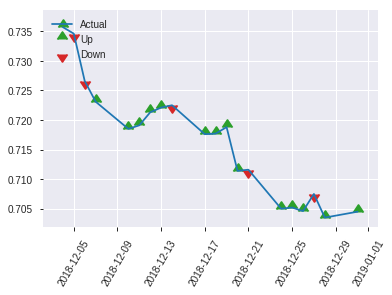


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1671495677345176
RMSE: 0.40883929328590424
LogLoss: 0.4978668707331875
Mean Per-Class Error: 0.23593893129770993
AUC: 0.8349923664122137
pr_auc: 0.8289199747169744
Gini: 0.6699847328244275
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3875926733016968: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      87   44   0.3359   (44.0/131.0)
1      17   108  0.136    (17.0/125.0)
Total  104  152  0.2383   (61.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.387593     0.779783  151
max f2                       0.130112     0.864714  216
max f0point5                 0.754881     0.760095  73
max accuracy                 0.387593     0.761719  151
max precision                0.966426     1         0
max recall                   0.043585     1         238
max specificity              0.966426     1         0
max absolute_mcc             0.387593     0.53751   151
max min_per_class_accuracy   0.49969      0.748092  126
max mean_per_class_accuracy  0.387593     0.764061  151

Gains/Lift Table: Avg response rate: 48.83 %, avg score: 49.37 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.961362           2.048      2.048              1                0.964918   1                           0.964918            0.024           0.024                      104.8     104.8
    2        0.0234375                   0.95661            2.048      2.048              1                0.958003   1                           0.961461            0.024           0.048                      104.8     104.8
    3        0.03125                     0.952174           2.048      2.048              1                0.954008   1                           0.959597            0.016           0.064                      104.8     104.8
    4        0.0429688                   0.947046           2.048      2.048              1                0.949679   1                           0.956892            0.024           0.088                      104.8     104.8
    5        0.0507812                   0.941171           2.048      2.048              1                0.943382   1                           0.954814            0.016           0.104                      104.8     104.8
    6        0.101562                    0.902439           2.048      2.048              1                0.928095   1                           0.941454            0.104           0.208                      104.8     104.8
    7        0.152344                    0.863253           1.57538    1.89046            0.769231         0.882442   0.923077                    0.921784            0.08            0.288                      57.5385   89.0462
    8        0.203125                    0.823856           1.73292    1.85108            0.846154         0.845768   0.903846                    0.90278             0.088           0.376                      73.2923   85.1077
    9        0.300781                    0.741273           1.47456    1.72883            0.72             0.784397   0.844156                    0.864344            0.144           0.52                       47.456    72.8831
    10       0.402344                    0.589372           1.18154    1.59068            0.576923         0.658367   0.776699                    0.812349            0.12            0.64                       18.1538   59.068
    11       0.5                         0.486886           1.14688    1.504              0.56             0.537262   0.734375                    0.758621            0.112           0.752                      14.688    50.4
    12       0.601562                    0.377476           1.10277    1.43626            0.538462         0.422452   0.701299                    0.701865            0.112           0.864                      10.2769   43.626
    13       0.699219                    0.275951           0.4096     1.29287            0.2              0.320964   0.631285                    0.648667            0.04            0.904                      -59.04    29.2872
    14       0.800781                    0.180807           0.630154   1.20882            0.307692         0.230796   0.590244                    0.595669            0.064           0.968                      -36.9846  20.882
    15       0.898438                    0.0736066          0.24576    1.10414            0.12             0.125317   0.53913                     0.544544            0.024           0.992                      -75.424   10.4139
    16       1                           0.025555           0.0787692  1                  0.0384615        0.0439951  0.488281                   

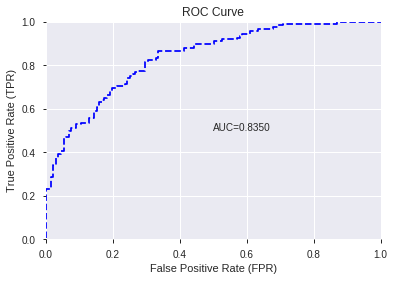

This function is available for GLM models only


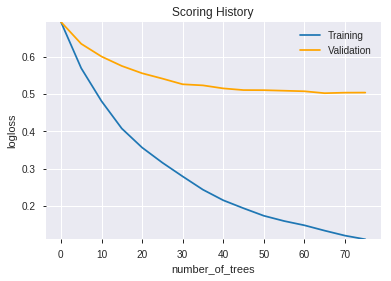

--2019-08-22 16:18:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.238.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.238.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

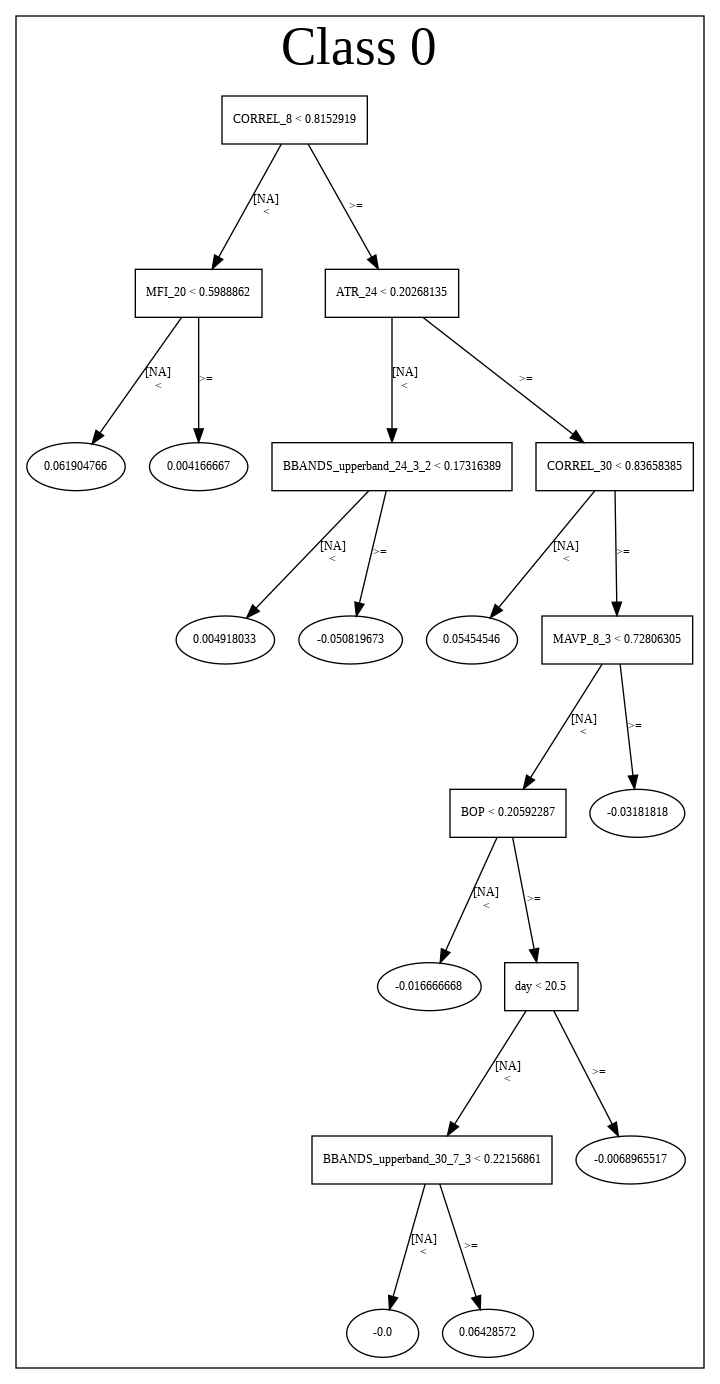

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_161744_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_161744_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_be46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_161858_model_8  0.828702  0.543546              0.249405  0.426368  0.181790
1  DeepLearning_grid_1_AutoML_20190822_161858_model_6  0.820031  0.529142              0.245405  0.421237  0.177441
2  DeepLearning_grid_1_AutoML_20190822_161858_model_9  0.813130  0.535354              0.278473  0.423957  0.179740
3  DeepLearning_grid_1_AutoML_20190822_161858_model_5  0.807817  0.535925              0.306626  0.423379  0.179250
4               DeepLearning_1_AutoML_20190822_161858  0.800183  0.601308              0.301557  0.458508  0.210229
5  DeepLearning_grid_1_AutoML_20190822_161858_model_1  0.793466  0.621785              0.282656  0.449876  0.202389
6  DeepLearning_grid_1_AutoML_20190822_161858_model_4  0.783389  0.652806              0.279939  0.456162  0.208084
7  DeepLearning_grid_1_AutoML_20190822_161858_model_3  0.781313  0.635411              0.305740  0.459282  0.210940
8  DeepLearning_grid_1_AutoML_20190822_161858_model_2  0.775939  0.692929              0.329527  0.476732  0.227273
9  DeepLearning_grid_1_AutoML_20190822_161858_model_7  0.767206  0.612926              0.311542  0.462758  0.214145

variable  relative_importance  scaled_importance  percentage
0         CDLRICKSHAWMAN             1.000000           1.000000    0.037149
1                    SUB             0.794247           0.794247    0.029505
2      CDLLONGLEGGEDDOJI             0.773276           0.773276    0.028726
3                CDLDOJI             0.762974           0.762974    0.028344
4                 ULTOSC             0.726124           0.726124    0.026975
5           HT_TRENDMODE             0.725262           0.725262    0.026943
6                WILLR_8             0.692757           0.692757    0.025735
7               WILLR_14             0.675688           0.675688    0.025101
8              PLUS_DI_8             0.628550           0.628550    0.023350
9               WILLR_12             0.625649           0.625649    0.023242
10          STOCHF_fastk             0.611532           0.611532    0.022718
11                 CCI_8             0.610829           0.610829    0.022692
12     CDLGRAVESTONEDOJI             0.601355           0.601355    0.022340
13                 month             0.588552           0.588552    0.021864
14  HT_PHASOR_quadrature             0.585772           0.585772    0.021761
15           CDLBELTHOLD             0.565936           0.565936    0.021024
16                TRANGE             0.565718           0.565718    0.021016
17                CCI_12             0.550432           0.550432    0.020448
18             PLUS_DM_8             0.543384           0.543384    0.020186
19      CDLDRAGONFLYDOJI             0.541531           0.541531    0.020117
20          weekday_name             0.516919           0.516919    0.019203
21    CDLCLOSINGMARUBOZU             0.515894           0.515894    0.019165
22       CDLSHOOTINGSTAR             0.508718           0.508718    0.018898
23     CDLINVERTEDHAMMER             0.507584           0.507584    0.018856
24          aroondown_20             0.506346           0.506346    0.018810
25                BETA_8             0.500132           0.500132    0.018579
26             aroonup_8             0.494474           0.494474    0.018369
27             CDLTAKURI             0.494220           0.494220    0.018360
28                   day             0.493220           0.493220    0.018323
29            PLUS_DM_12             0.491603           0.491603    0.018263
30             dayofweek             0.487754           0.487754    0.018120
31             CDLONNECK             0.485360           0.485360    0.018031
32        CDLSPINNINGTOP             0.483810           0.483810    0.017973
33                SAREXT             0.482061           0.482061    0.017908
34           aroondown_8             0.474919           0.474919    0.017643
35            MINUS_DI_8             0.473896           0.473896    0.017605
36           CDLHIGHWAVE             0.470374           0.470374    0.017474
37      CDLSTICKSANDWICH             0.463269           0.463269    0.017210
38               weekday             0.461955           0.461955    0.017161
39          aroondown_30             0.458902           0.458902    0.017048
40        STOCHRSI_fastk             0.446490           0.446490    0.016587
41             CDLHAMMER             0.430625           0.430625    0.015997
42            AROONOSC_8             0.417598           0.417598    0.015513
43             CDL2CROWS             0.416926           0.416926    0.015488
44           MINUS_DI_12             0.409683           0.409683    0.015219
45                CCI_20             0.390521           0.390521    0.014507
46    CDLEVENINGDOJISTAR             0.385021           0.385021    0.014303
47                CCI_24             0.374457           0.374457    0.013911
48       CDLADVANCEBLOCK             0.361491           0.361491    0.013429
49                CCI_30             0.344920           0.344920    0.012813

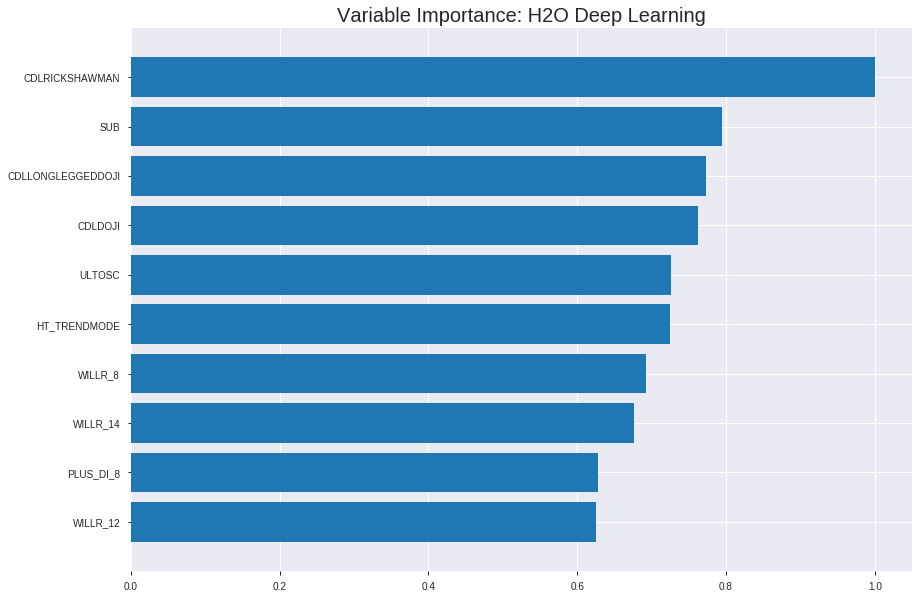

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_161858_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.16726455381321945
RMSE: 0.40897989414299996
LogLoss: 0.48605772996628777
Mean Per-Class Error: 0.2644891063408903
AUC: 0.8338726399582278
pr_auc: 0.8548301275028709
Gini: 0.6677452799164556
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5232356726036811: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      363  490   0.5744   (490.0/853.0)
1      29   905   0.031    (29.0/934.0)
Total  392  1395  0.2904   (519.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.523236     0.777158  230
max f2                       0.45675      0.883147  253
max f0point5                 0.603538     0.778689  167
max accuracy                 0.540845     0.731393  217
max precision                0.999851     1         0
max recall                   0.182484     1         332
max specificity              0.999851     1         0
max absolute_mcc             0.603538     0.487494  167
max min_per_class_accuracy   0.541953     0.724839  215
max mean_per_class_accuracy  0.576401     0.735511  184

Gains/Lift Table: Avg response rate: 52.27 %, avg score: 57.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100727                   0.998478           1.91328   1.91328            1                0.999181   1                           0.999181            0.0192719       0.0192719                  91.3276    91.3276
    2        0.0201455                   0.997469           1.91328   1.91328            1                0.998048   1                           0.998615            0.0192719       0.0385439                  91.3276    91.3276
    3        0.0302182                   0.99656            1.91328   1.91328            1                0.99703    1                           0.998087            0.0192719       0.0578158                  91.3276    91.3276
    4        0.040291                    0.995503           1.91328   1.91328            1                0.995998   1                           0.997564            0.0192719       0.0770878                  91.3276    91.3276
    5        0.0503637                   0.993804           1.91328   1.91328            1                0.994793   1                           0.99701             0.0192719       0.0963597                  91.3276    91.3276
    6        0.100168                    0.982908           1.87028   1.8919             0.977528         0.989122   0.988827                    0.993088            0.0931478       0.189507                   87.0281    89.1899
    7        0.149972                    0.949034           1.87028   1.88472            0.977528         0.967338   0.985075                    0.984537            0.0931478       0.282655                   87.0281    88.472
    8        0.200336                    0.845204           1.74321   1.84914            0.911111         0.8956     0.96648                     0.962178            0.0877944       0.37045                    74.3207    84.9144
    9        0.299944                    0.635589           1.39734   1.6991             0.730337         0.729446   0.88806                     0.88489             0.139186        0.509636                   39.7337    69.9104
    10       0.400112                    0.560987           1.09025   1.54668            0.569832         0.59079    0.808392                    0.811262            0.109208        0.618844                   9.02468    54.6676
    11       0.50028                     0.542682           0.994049  1.43603            0.519553         0.549337   0.750559                    0.758819            0.0995717       0.718415                   -0.595146  43.6027
    12       0.758254                    0.537619           0.892309  1.25104            0.466377         0.538101   0.653875                    0.683726            0.230193        0.948608                   -10.7691   25.1043
    13       0.799664                    0.488191           0.646377  1.21973            0.337838         0.51938    0.637509                    0.675215            0.0267666       0.975375                   -35.3623   21.973
    14       0.899832                    0.162025           0.24584   1.11132            0.128492         0.329158   0.580846                    0.636693            0.0246253       1                          -75.416    11.1318
    15       1                           0.00216518         0         1                  0                0.0593621  0.522664                    0.578863            0               1                          -100       0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.17931392276460173
RMSE: 0.42345474700917185
LogLoss: 0.5360565600402214
Mean Per-Class Error: 0.2457983193277311
AUC: 0.8248347132970836
pr_auc: 0.8462714477480144
Gini: 0.6496694265941672
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5376185731103372: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      117  121  0.5084   (121.0/238.0)
1      21   251  0.0772   (21.0/272.0)
Total  138  372  0.2784   (142.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.537619     0.779503  263
max f2                       0.432512     0.872326  298
max f0point5                 0.577086     0.788745  194
max accuracy                 0.546717     0.75098   228
max precision                0.999964     1         0
max recall                   0.0434128    1         383
max specificity              0.999964     1         0
max absolute_mcc             0.546717     0.508274  228
max min_per_class_accuracy   0.539722     0.739496  249
max mean_per_class_accuracy  0.546717     0.754202  228

Gains/Lift Table: Avg response rate: 53.33 %, avg score: 58.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.998068           1.875     1.875              1                0.999123   1                           0.999123            0.0220588       0.0220588                  87.5      87.5
    2        0.0215686                   0.996615           1.875     1.875              1                0.99728    1                           0.998285            0.0183824       0.0404412                  87.5      87.5
    3        0.0313725                   0.995814           1.875     1.875              1                0.996296   1                           0.997663            0.0183824       0.0588235                  87.5      87.5
    4        0.0411765                   0.993943           1.875     1.875              1                0.994847   1                           0.996993            0.0183824       0.0772059                  87.5      87.5
    5        0.0509804                   0.991222           1.875     1.875              1                0.992529   1                           0.996135            0.0183824       0.0955882                  87.5      87.5
    6        0.1                         0.981138           1.725     1.80147            0.92             0.98714    0.960784                    0.991725            0.0845588       0.180147                   72.5      80.1471
    7        0.15098                     0.956426           1.73077   1.7776             0.923077         0.969757   0.948052                    0.984308            0.0882353       0.268382                   73.0769   77.7597
    8        0.2                         0.883901           1.65      1.74632            0.88             0.924295   0.931373                    0.969599            0.0808824       0.349265                   65        74.6324
    9        0.3                         0.69253            1.36029   1.61765            0.72549          0.776045   0.862745                    0.905081            0.136029        0.485294                   36.0294   61.7647
    10       0.4                         0.575165           1.43382   1.57169            0.764706         0.635273   0.838235                    0.837629            0.143382        0.628676                   43.3824   57.1691
    11       0.5                         0.543299           1.02941   1.46324            0.54902          0.555936   0.780392                    0.78129             0.102941        0.731618                   2.94118   46.3235
    12       0.729412                    0.537619           0.833333  1.26512            0.444444         0.538066   0.674731                    0.704792            0.191176        0.922794                   -16.6667  26.5121
    13       0.8                         0.431438           0.520833  1.19945            0.277778         0.50113    0.639706                    0.686822            0.0367647       0.959559                   -47.9167  19.9449
    14       0.9                         0.192705           0.147059  1.08252            0.0784314        0.301774   0.577342                    0.644039            0.0147059       0.974265                   -85.2941  8.25163
    15       1                           0.00760098         0.257353  1                  0.137255         0.0778834  0.533333                    0.587423            0.0257353       1                          -74.2647  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:25:23  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 16:25:25  1 min 23.378 sec  639 obs/sec       0.660884  1             1181       0.462885         0.611713            0.141185       0.777347        0.798135           1.80698          0.341914                         0.46058            0.606939              0.147675         0.787475          0.809971             1.875              0.331373
    2019-08-22 16:25:39  1 min 37.395 sec  989 obs/sec       8.06435   12            14411      0.4219           0.519298            0.286535       0.80998         0.829489           1.91328          0.295467                         0.424809           0.539678              0.274928         0.81976           0.837847             1.875              0.280392
    2019-08-22 16:25:53  1 min 51.276 sec  1105 obs/sec      16.7773   25            29981      0.411919         0.495908            0.319892       0.823348        0.838943           1.91328          0.288752                         0.420593           0.537937              0.289248         0.821544          0.840028             1.875              0.282353
    2019-08-22 16:26:07  2 min  4.991 sec  1183 obs/sec      26.1701   39            46766      0.40898          0.486058            0.329564       0.833873        0.85483            1.91328          0.290431                         0.423455           0.536057              0.279542         0.824835          0.846271             1.875              0.278431
    2019-08-22 16:26:20  2 min 18.170 sec  1236 obs/sec      35.563    53            63551      0.397187         0.453344            0.36767        0.839048        0.831386           1.91328          0.296586                         0.420762           0.5717                0.288677         0.825669          0.831882             1.875              0.239216
    2019-08-22 16:26:33  2 min 31.331 sec  1272 obs/sec      44.967    67            80356      0.385432         0.428769            0.404547       0.858643        0.785506           1.91328          0.266368                         0.427472           0.598957              0.265806         0.809673          0.835281             1.875              0.272549
    2019-08-22 16:26:48  2 min 45.745 sec  1304 obs/sec      55.6682   83            99479      0.377174         0.410531            0.429788       0.871187        0.847864           1.91328          0.258534                         0.426251           0.614233              0.269995         0.813705          0.824357             1.875              0.280392
    2019-08-22 16:26:49  2 min 47.121 sec  1303 obs/sec      55.6682   83            99479      0.40898          0.486058            0.329564       0.833873        0.85483            1.91328          0.290431                         0.423455           0.536057              0.279542         0.824835          0.846271             1.875              0.278431

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLRICKSHAWMAN      1.0                    1.0                  0.03714888430479679
SUB                 0.7942472696304321     0.7942472696304321   0.029505399928901666
CDLLONGLEGGEDDOJI   0.7732759714126587     0.7732759714126587   0.02872633959768821
CDLDOJI             0.7629740834236145     0.7629740834236145   0.028343635952662233
ULTOSC              0.7261242270469666     0.7261242270469666   0.02697470490147776
---                 ---                    ---                  ---
CCI_20              0.39052125811576843    0.39052125811576843  0.014507429036306366
CDLEVENINGDOJISTAR  0.3850210905075073     0.3850210905075073   0.014303103946170084
CCI_24              0.37445688247680664    0.37445688247680664  0.01391065540426578
CDLADVANCEBLOCK     0.3614910840988159     0.3614910840988159   0.01342899046040248
CCI_30              0.3449203073978424     0.3449203073978424   0.012813404593897394


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.75390625)

('F1', 0.751937984496124)

('auc', 0.8287022900763359)

('logloss', 0.5435457120324299)

('mean_per_class_error', 0.24687022900763367)

('rmse', 0.4263681214832157)

('mse', 0.18178977501712618)

deeplearning prediction progress: |███████████████████████████████████████| 100%


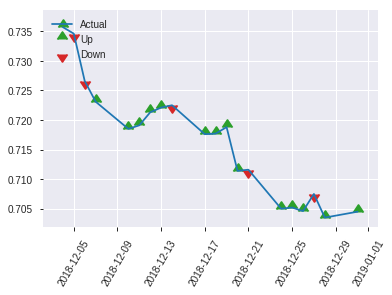


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18178977501712618
RMSE: 0.4263681214832157
LogLoss: 0.5435457120324299
Mean Per-Class Error: 0.24687022900763367
AUC: 0.8287022900763359
pr_auc: 0.815249947668584
Gini: 0.6574045801526718
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5392163968312927: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      95   36   0.2748   (36.0/131.0)
1      28   97   0.224    (28.0/125.0)
Total  123  133  0.25     (64.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.539216     0.751938  132
max f2                       0.105044     0.851499  199
max f0point5                 0.640791     0.779376  72
max accuracy                 0.544555     0.753906  115
max precision                0.998956     1         0
max recall                   0.105044     1         199
max specificity              0.998956     1         0
max absolute_mcc             0.59258      0.508742  82
max min_per_class_accuracy   0.541717     0.740458  126
max mean_per_class_accuracy  0.54444      0.75313   117

Gains/Lift Table: Avg response rate: 48.83 %, avg score: 56.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.996632           2.048     2.048              1                0.997745   1                           0.997745            0.024           0.024                      104.8     104.8
    2        0.0234375                   0.995498           1.36533   1.70667            0.666667         0.995832   0.833333                    0.996789            0.016           0.04                       36.5333   70.6667
    3        0.03125                     0.994178           2.048     1.792              1                0.995212   0.875                       0.996395            0.016           0.056                      104.8     79.2
    4        0.0429688                   0.992687           2.048     1.86182            1                0.993143   0.909091                    0.995508            0.024           0.08                       104.8     86.1818
    5        0.0507812                   0.991645           2.048     1.89046            1                0.992164   0.923077                    0.994994            0.016           0.096                      104.8     89.0462
    6        0.101562                    0.978319           1.89046   1.89046            0.923077         0.986139   0.923077                    0.990566            0.096           0.192                      89.0462   89.0462
    7        0.152344                    0.927429           1.89046   1.89046            0.923077         0.955018   0.923077                    0.978717            0.096           0.288                      89.0462   89.0462
    8        0.203125                    0.798511           1.89046   1.89046            0.923077         0.851672   0.923077                    0.946956            0.096           0.384                      89.0462   89.0462
    9        0.300781                    0.613388           1.47456   1.75543            0.72             0.691158   0.857143                    0.863904            0.144           0.528                      47.456    75.5429
    10       0.402344                    0.555795           1.18154   1.61056            0.576923         0.576886   0.786408                    0.791453            0.12            0.648                      18.1538   61.0563
    11       0.5                         0.540585           1.06496   1.504              0.52             0.546764   0.734375                    0.743662            0.104           0.752                      6.496     50.4
    12       0.664062                    0.537619           0.78019   1.32518            0.380952         0.537935   0.647059                    0.692836            0.128           0.88                       -21.981   32.5176
    13       0.699219                    0.532675           0.455111  1.28143            0.222222         0.53583    0.625698                    0.684941            0.016           0.896                      -54.4889  28.143
    14       0.800781                    0.419879           0.551385  1.18884            0.269231         0.493076   0.580488                    0.660607            0.056           0.952                      -44.8615  18.8839
    15       0.898438                    0.132997           0.32768   1.09523            0.16             0.275649   0.534783                    0.618764            0.032           0.984                      -67.232   9.52348
    16       1                           0.009601           0.157538  1                  0.0769231        0.0529833  0.488281                    0.561302

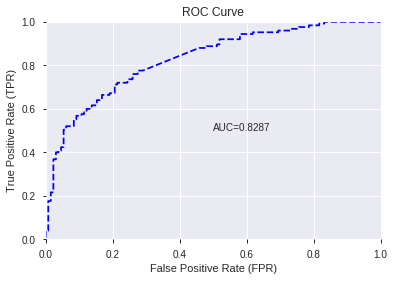

This function is available for GLM models only


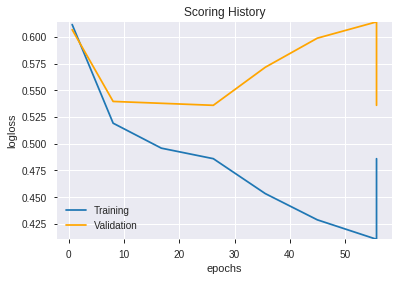

--2019-08-22 16:28:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


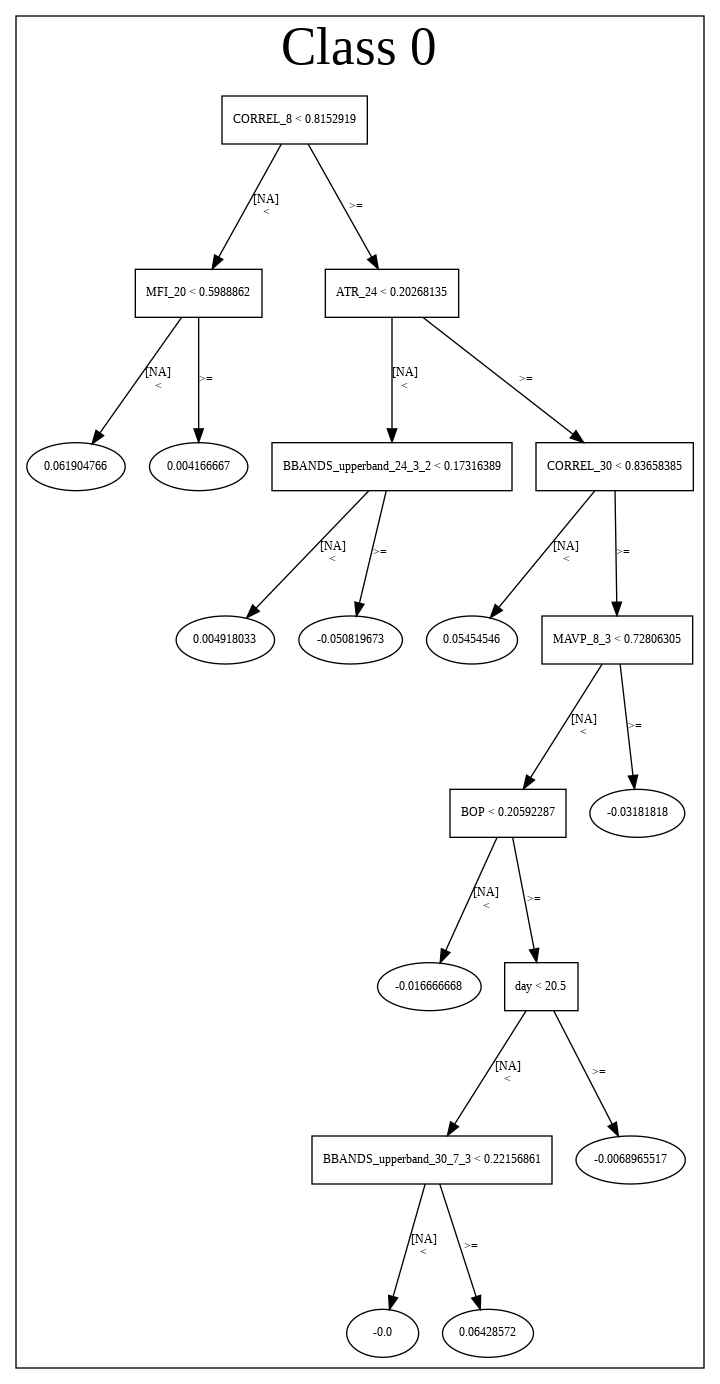

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_161858_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_161858_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_be46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLRICKSHAWMAN',
 'SUB',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'ULTOSC',
 'HT_TRENDMODE',
 'WILLR_8',
 'WILLR_14',
 'PLUS_DI_8',
 'WILLR_12',
 'STOCHF_fastk',
 'CCI_8',
 'CDLGRAVESTONEDOJI',
 'month',
 'HT_PHASOR_quadrature',
 'CDLBELTHOLD',
 'TRANGE',
 'CCI_12',
 'PLUS_DM_8',
 'CDLDRAGONFLYDOJI',
 'weekday_name',
 'CDLCLOSINGMARUBOZU',
 'CDLSHOOTINGSTAR',
 'CDLINVERTEDHAMMER',
 'aroondown_20',
 'BETA_8',
 'aroonup_8',
 'CDLTAKURI',
 'day',
 'PLUS_DM_12',
 'dayofweek',
 'CDLONNECK',
 'CDLSPINNINGTOP',
 'SAREXT',
 'aroondown_8',
 'MINUS_DI_8',
 'CDLHIGHWAVE',
 'CDLSTICKSANDWICH',
 'weekday',
 'aroondown_30',
 'STOCHRSI_fastk',
 'CDLHAMMER',
 'AROONOSC_8',
 'CDL2CROWS',
 'MINUS_DI_12',
 'CCI_20',
 'CDLEVENINGDOJISTAR',
 'CCI_24',
 'CDLADVANCEBLOCK',
 'CCI_30']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_162845_model_1  0.827847  0.509278              0.265924  0.413262  0.170786

variable  relative_importance  scaled_importance  percentage
0               WILLR_14             1.051667           1.000000    0.097763
1             MINUS_DI_8             1.012960           0.963194    0.094165
2            MINUS_DI_12             0.945384           0.898938    0.087883
3       CDLDRAGONFLYDOJI             0.702343           0.667838    0.065290
4                  CCI_8             0.626836           0.596040    0.058271
5                WILLR_8             0.624388           0.593712    0.058043
6                 CCI_12             0.565593           0.537806    0.052578
7      CDLGRAVESTONEDOJI             0.562144           0.534527    0.052257
8                 CCI_30             0.430167           0.409033    0.039988
9      CDLLONGLEGGEDDOJI             0.358262           0.340661    0.033304
10             CDLONNECK             0.325339           0.309355    0.030244
11      CDLSTICKSANDWICH             0.260652           0.247847    0.024230
12             CDLTAKURI             0.252813           0.240393    0.023502
13          STOCHF_fastk             0.236454           0.224837    0.021981
14          aroondown_30             0.194338           0.184790    0.018066
15        STOCHRSI_fastk             0.155107           0.147487    0.014419
16          aroondown_20             0.147866           0.140601    0.013746
17             CDL2CROWS             0.144937           0.137817    0.013473
18             aroonup_8             0.142629           0.135622    0.013259
19                CCI_20             0.142591           0.135586    0.013255
20               CDLDOJI             0.136012           0.129330    0.012644
21            PLUS_DM_12             0.134771           0.128150    0.012528
22                CCI_24             0.128839           0.122509    0.011977
23        CDLRICKSHAWMAN             0.127753           0.121476    0.011876
24    CDLEVENINGDOJISTAR             0.120472           0.114553    0.011199
25                TRANGE             0.114120           0.108514    0.010609
26                ULTOSC             0.110620           0.105186    0.010283
27  HT_PHASOR_quadrature             0.109505           0.104126    0.010180
28       CDLSHOOTINGSTAR             0.098597           0.093753    0.009166
29           CDLBELTHOLD             0.098195           0.093371    0.009128
30                   SUB             0.074538           0.070876    0.006929
31                 month             0.068944           0.065556    0.006409
32           aroondown_8             0.065323           0.062113    0.006072
33          HT_TRENDMODE             0.061794           0.058758    0.005744
34             PLUS_DM_8             0.056912           0.054116    0.005291
35            AROONOSC_8             0.046615           0.044325    0.004333
36                   day             0.044852           0.042649    0.004169
37        CDLSPINNINGTOP             0.042920           0.040811    0.003990
38                BETA_8             0.036655           0.034854    0.003407
39             CDLHAMMER             0.036456           0.034665    0.003389
40             PLUS_DI_8             0.034830           0.033118    0.003238
41       CDLADVANCEBLOCK             0.028297           0.026907    0.002630
42           CDLHIGHWAVE             0.025339           0.024094    0.002356
43             dayofweek             0.018403           0.017499    0.001711
44          weekday_name             0.017871           0.016993    0.001661
45               weekday             0.015335           0.014581    0.001425
46    CDLCLOSINGMARUBOZU             0.008170           0.007769    0.000760
47     CDLINVERTEDHAMMER             0.006838           0.006502    0.000636
48              WILLR_12             0.003768           0.003583    0.000350
49                SAREXT             0.002100           0.001997    0.000195

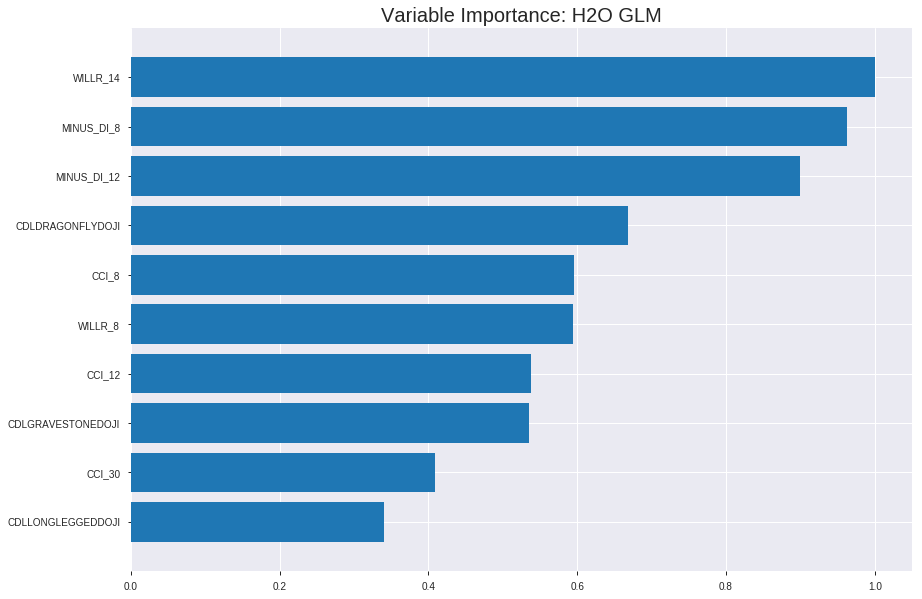

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_162845_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1803224086359544
RMSE: 0.4246438609422658
LogLoss: 0.5319505773918987
Null degrees of freedom: 1786
Residual degrees of freedom: 1736
Null deviance: 2473.635248547511
Residual deviance: 1901.191363598646
AIC: 2003.191363598646
AUC: 0.802272995423634
pr_auc: 0.8106887168597395
Gini: 0.6045459908472679
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39581545540348984: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      442  411   0.4818   (411.0/853.0)
1      111  823   0.1188   (111.0/934.0)
Total  553  1234  0.2921   (522.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395815     0.759225  259
max f2                       0.250412     0.866142  315
max f0point5                 0.587617     0.74026   166
max accuracy                 0.455898     0.72244   233
max precision                0.999785     1         0
max recall                   0.0395821    1         389
max specificity              0.999785     1         0
max absolute_mcc             0.455898     0.447092  233
max min_per_class_accuracy   0.532951     0.70985   197
max mean_per_class_accuracy  0.478202     0.718002  222

Gains/Lift Table: Avg response rate: 52.27 %, avg score: 52.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.97601            1.91328   1.91328            1                0.990426   1                           0.990426            0.0192719       0.0192719                  91.3276   91.3276
    2        0.0201455                   0.970586           1.80698   1.86013            0.944444         0.973404   0.972222                    0.981915            0.0182013       0.0374732                  80.6983   86.013
    3        0.0302182                   0.961699           1.91328   1.87785            1                0.966294   0.981481                    0.976708            0.0192719       0.0567452                  91.3276   87.7845
    4        0.040291                    0.95161            1.80698   1.86013            0.944444         0.956487   0.972222                    0.971653            0.0182013       0.0749465                  80.6983   86.013
    5        0.0503637                   0.943022           1.80698   1.8495             0.944444         0.948459   0.966667                    0.967014            0.0182013       0.0931478                  80.6983   84.95
    6        0.100168                    0.904539           1.78429   1.81708            0.932584         0.924164   0.949721                    0.945709            0.0888651       0.182013                   78.4291   81.7078
    7        0.149972                    0.846413           1.6983    1.77763            0.88764          0.880453   0.929104                    0.924038            0.0845824       0.266595                   69.8301   77.7634
    8        0.200336                    0.770506           1.4881    1.70485            0.777778         0.805596   0.891061                    0.894262            0.0749465       0.341542                   48.8104   70.4847
    9        0.299944                    0.660756           1.33284   1.58131            0.696629         0.709007   0.826493                    0.832741            0.132762        0.474304                   33.2844   58.1309
    10       0.400112                    0.591669           1.2292    1.49316            0.642458         0.624771   0.78042                     0.780675            0.123126        0.59743                    22.92     49.3158
    11       0.50028                     0.536421           1.05818   1.40607            0.553073         0.563162   0.734899                    0.737124            0.105996        0.703426                   5.81807   40.6065
    12       0.599888                    0.466558           1.02113   1.34215            0.533708         0.502775   0.701493                    0.698212            0.101713        0.805139                   2.11306   34.2149
    13       0.700056                    0.389048           0.769586  1.26022            0.402235         0.429333   0.658673                    0.659739            0.0770878       0.882227                   -23.0414  26.0224
    14       0.799664                    0.282748           0.666422  1.18626            0.348315         0.341694   0.620014                    0.620123            0.0663812       0.948608                   -33.3578  18.6258
    15       0.899832                    0.110508           0.363416  1.09466            0.189944         0.200828   0.572139                    0.573447            0.0364026       0.985011                   -63.6584  9.46605
    16       1                           0.00188892         0.149642  1                  0.0782123        0.0664606  0.522664                    0.5



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1681447536362341
RMSE: 0.41005457397306777
LogLoss: 0.5059887325216125
Null degrees of freedom: 509
Residual degrees of freedom: 459
Null deviance: 704.9746584600862
Residual deviance: 516.1085071720448
AIC: 618.1085071720448
AUC: 0.8270514087988137
pr_auc: 0.8335480155019573
Gini: 0.6541028175976273
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.325418302056258: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      112  126  0.5294   (126.0/238.0)
1      13   259  0.0478   (13.0/272.0)
Total  125  385  0.2725   (139.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.325418     0.788432  295
max f2                       0.325418     0.879158  295
max f0point5                 0.659028     0.775862  126
max accuracy                 0.474319     0.752941  230
max precision                0.999864     1         0
max recall                   0.0537924    1         388
max specificity              0.999864     1         0
max absolute_mcc             0.472568     0.505261  232
max min_per_class_accuracy   0.538209     0.735294  194
max mean_per_class_accuracy  0.474319     0.746586  230

Gains/Lift Table: Avg response rate: 53.33 %, avg score: 53.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117647                   0.986546           1.875     1.875              1                0.992806   1                           0.992806            0.0220588       0.0220588                  87.5       87.5
    2        0.0215686                   0.977523           1.5       1.70455            0.8              0.980751   0.909091                    0.987327            0.0147059       0.0367647                  50         70.4545
    3        0.0313725                   0.963355           1.875     1.75781            1                0.967287   0.9375                      0.981064            0.0183824       0.0551471                  87.5       75.7812
    4        0.0411765                   0.95375            1.875     1.78571            1                0.958025   0.952381                    0.975579            0.0183824       0.0735294                  87.5       78.5714
    5        0.0509804                   0.948524           1.875     1.80288            1                0.95091    0.961538                    0.970835            0.0183824       0.0919118                  87.5       80.2885
    6        0.1                         0.914792           1.65      1.72794            0.88             0.933442   0.921569                    0.952505            0.0808824       0.172794                   65         72.7941
    7        0.15098                     0.868699           1.80288   1.75325            0.961538         0.899655   0.935065                    0.93466             0.0919118       0.264706                   80.2885    75.3247
    8        0.2                         0.785347           1.725     1.74632            0.92             0.828788   0.931373                    0.908711            0.0845588       0.349265                   72.5       74.6324
    9        0.3                         0.671046           1.47059   1.65441            0.784314         0.722471   0.882353                    0.846631            0.147059        0.496324                   47.0588    65.4412
    10       0.4                         0.60402            0.992647  1.48897            0.529412         0.63642    0.794118                    0.794078            0.0992647       0.595588                   -0.735294  48.8971
    11       0.5                         0.542972           1.17647   1.42647            0.627451         0.568453   0.760784                    0.748953            0.117647        0.713235                   17.6471    42.6471
    12       0.6                         0.485174           1.06618   1.36642            0.568627         0.516502   0.728758                    0.710211            0.106618        0.819853                   6.61765    36.6422
    13       0.7                         0.395703           0.808824  1.28676            0.431373         0.44067    0.686275                    0.671705            0.0808824       0.900735                   -19.1176   28.6765
    14       0.8                         0.283992           0.588235  1.19945            0.313725         0.333161   0.639706                    0.629387            0.0588235       0.959559                   -41.1765   19.9449
    15       0.9                         0.12877            0.220588  1.09069            0.117647         0.192644   0.581699                    0.58086             0.0220588       0.981618                   -77.9412   9.06863
    16       1                           0.0191098          0.183824  1                  0.0980392        0.0730329  0.533333     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 16:28:45  0.000 sec   2            .16E2     49            1.366039883928515   1.3636263787019691
     2019-08-22 16:28:45  0.011 sec   4            .98E1     49            1.3560805601627095  1.3533814389501653
     2019-08-22 16:28:45  0.021 sec   6            .61E1     50            1.3415563770121373  1.3384148468373367
     2019-08-22 16:28:45  0.032 sec   8            .38E1     51            1.3214017826775297  1.3175867754764772
     2019-08-22 16:28:45  0.044 sec   10           .23E1     51            1.295231614295407   1.2904409829020878
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 16:28:46  0.254 sec   47           .17E-3    51            1.0639598133531876  1.0126724002639929
     2019-08-22 16:28:46  0.260 sec   48           .11E-3    51            1.0639269570728664  1.012362695829084
     2019-08-22 16:28:46  0.267 sec   49           .66E-4    51            1.0639117085132723  1.0121610033648631
     2019-08-22 16:28:46  0.273 sec   50           .41E-4    51            1.0639048237563422  1.012057293810678
     2019-08-22 16:28:46  0.281 sec   51           .25E-4    51            1.0639011547837973  1.0119774650432252


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.765625)

('F1', 0.7628865979381444)

('auc', 0.8278473282442748)

('logloss', 0.5092781748533575)

('mean_per_class_error', 0.23487022900763366)

('rmse', 0.4132624095418588)

('mse', 0.170785819140343)

glm prediction progress: |████████████████████████████████████████████████| 100%


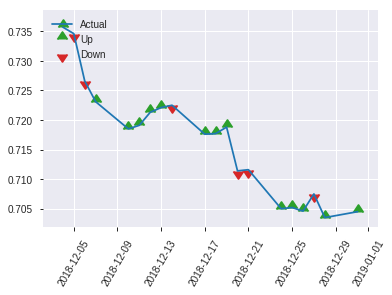


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.170785819140343
RMSE: 0.4132624095418588
LogLoss: 0.5092781748533575
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 355.96216876159656
Residual deviance: 260.750425524919
AIC: 362.750425524919
AUC: 0.8278473282442748
pr_auc: 0.8117149252345969
Gini: 0.6556946564885495
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39452096307065043: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      76   55   0.4198   (55.0/131.0)
1      14   111  0.112    (14.0/125.0)
Total  90   166  0.2695   (69.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394521     0.762887  165
max f2                       0.255112     0.853659  196
max f0point5                 0.551211     0.769231  114
max accuracy                 0.551211     0.765625  114
max precision                0.993016     1         0
max recall                   0.0877205    1         232
max specificity              0.993016     1         0
max absolute_mcc             0.551211     0.531765  114
max min_per_class_accuracy   0.522319     0.748092  126
max mean_per_class_accuracy  0.545743     0.76513   120

Gains/Lift Table: Avg response rate: 48.83 %, avg score: 50.79 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.970575           2.048      2.048              1                0.988453   1                           0.988453            0.024           0.024                      104.8     104.8
    2        0.0234375                   0.957414           2.048      2.048              1                0.959533   1                           0.973993            0.024           0.048                      104.8     104.8
    3        0.03125                     0.955053           2.048      2.048              1                0.956107   1                           0.969522            0.016           0.064                      104.8     104.8
    4        0.0429688                   0.952551           1.36533    1.86182            0.666667         0.953744   0.909091                    0.965219            0.016           0.08                       36.5333   86.1818
    5        0.0507812                   0.951089           2.048      1.89046            1                0.951632   0.923077                    0.963128            0.016           0.096                      104.8     89.0462
    6        0.101562                    0.914371           1.89046    1.89046            0.923077         0.93734    0.923077                    0.950234            0.096           0.192                      89.0462   89.0462
    7        0.152344                    0.870486           1.89046    1.89046            0.923077         0.896219   0.923077                    0.932229            0.096           0.288                      89.0462   89.0462
    8        0.203125                    0.729988           1.41785    1.77231            0.692308         0.797271   0.865385                    0.89849             0.072           0.36                       41.7846   77.2308
    9        0.300781                    0.658098           1.55648    1.70223            0.76             0.695669   0.831169                    0.832639            0.152           0.512                      55.648    70.2234
    10       0.402344                    0.589418           1.33908    1.61056            0.653846         0.624546   0.786408                    0.780111            0.136           0.648                      33.9077   61.0563
    11       0.5                         0.521355           1.06496    1.504              0.52             0.554051   0.734375                    0.735958            0.104           0.752                      6.496     50.4
    12       0.601562                    0.450868           0.787692   1.38306            0.384615         0.483329   0.675325                    0.693307            0.08            0.832                      -21.2308  38.3065
    13       0.699219                    0.355141           0.73728    1.29287            0.36             0.395777   0.631285                    0.651752            0.072           0.904                      -26.272   29.2872
    14       0.800781                    0.227696           0.551385   1.19883            0.269231         0.293361   0.585366                    0.606298            0.056           0.96                       -44.8615  19.8829
    15       0.898438                    0.0984097          0.32768    1.10414            0.16             0.16861    0.53913                     0.558723            0.032           0.992                      -67.232   10.4139
    16       1                           0.00831939         0.0787692  1                  0.0384615        0.0579576  0.488281          

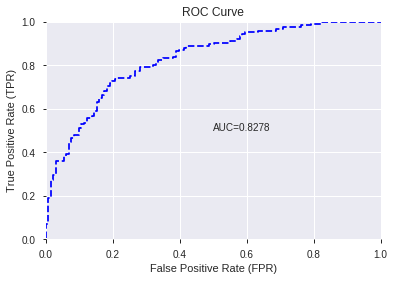

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


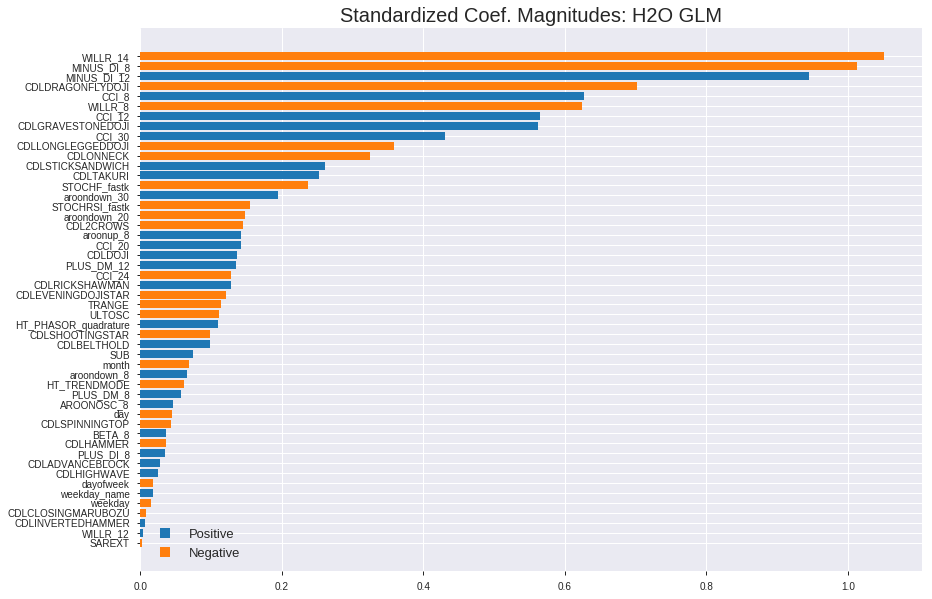

'log_likelihood'
--2019-08-22 16:28:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


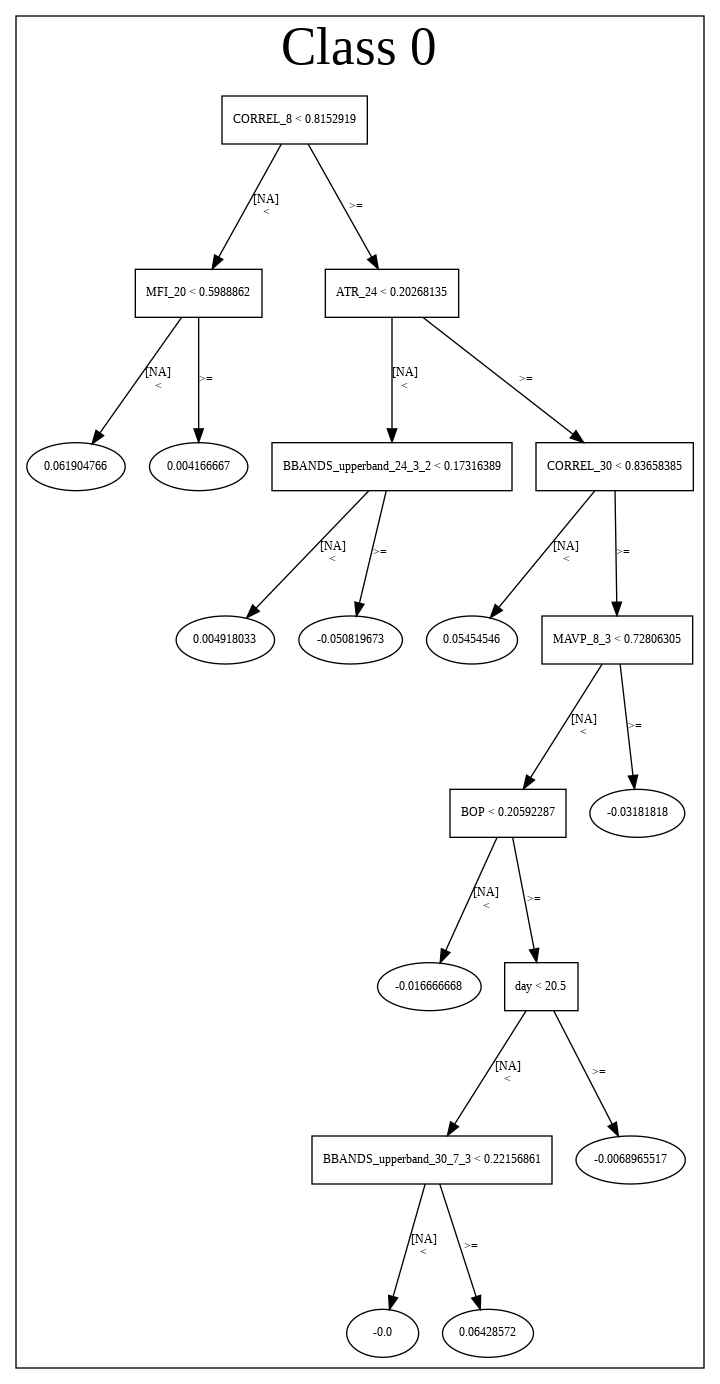

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_162845_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_162845_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_be46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['WILLR_14',
 'MINUS_DI_8',
 'MINUS_DI_12',
 'CDLDRAGONFLYDOJI',
 'CCI_8',
 'WILLR_8',
 'CCI_12',
 'CDLGRAVESTONEDOJI',
 'CCI_30',
 'CDLLONGLEGGEDDOJI',
 'CDLONNECK',
 'CDLSTICKSANDWICH',
 'CDLTAKURI',
 'STOCHF_fastk',
 'aroondown_30',
 'STOCHRSI_fastk',
 'aroondown_20',
 'CDL2CROWS',
 'aroonup_8',
 'CCI_20',
 'CDLDOJI',
 'PLUS_DM_12',
 'CCI_24',
 'CDLRICKSHAWMAN',
 'CDLEVENINGDOJISTAR',
 'TRANGE',
 'ULTOSC',
 'HT_PHASOR_quadrature',
 'CDLSHOOTINGSTAR',
 'CDLBELTHOLD',
 'SUB',
 'month',
 'aroondown_8',
 'HT_TRENDMODE',
 'PLUS_DM_8',
 'AROONOSC_8',
 'day',
 'CDLSPINNINGTOP',
 'BETA_8',
 'CDLHAMMER',
 'PLUS_DI_8',
 'CDLADVANCEBLOCK',
 'CDLHIGHWAVE',
 'dayofweek',
 'weekday_name',
 'weekday',
 'CDLCLOSINGMARUBOZU',
 'CDLINVERTEDHAMMER',
 'WILLR_12',
 'SAREXT']

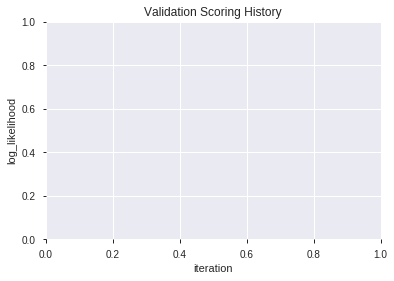

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_162856_model_3  0.829740  0.509613              0.231053  0.411819  0.169595
1               XGBoost_3_AutoML_20190822_162856  0.823511  0.518831              0.249038  0.416134  0.173167
2  XGBoost_grid_1_AutoML_20190822_162856_model_7  0.819481  0.519320              0.242504  0.417191  0.174048
3               XGBoost_2_AutoML_20190822_162856  0.819420  0.522482              0.242321  0.418113  0.174819
4  XGBoost_grid_1_AutoML_20190822_162856_model_4  0.818137  0.525022              0.249038  0.419808  0.176239
5               XGBoost_1_AutoML_20190822_162856  0.817160  0.522998              0.274840  0.418801  0.175394
6  XGBoost_grid_1_AutoML_20190822_162856_model_2  0.817038  0.517887              0.263939  0.418151  0.174851
7  XGBoost_grid_1_AutoML_20190822_162856_model_5  0.814168  0.528149              0.266473  0.422007  0.178090
8  XGBoost_grid_1_AutoML_20190822_162856_model_6  0.810992  0.526874              0.251939  0.421620  0.177763
9  XGBoost_grid_1_AutoML_20190822_162856_model_1  0.810137  0.530217              0.317710  0.422372  0.178398

variable  relative_importance  scaled_importance  percentage
0       CDLDRAGONFLYDOJI           963.265869           1.000000    0.108873
1      CDLGRAVESTONEDOJI           953.486633           0.989848    0.107768
2           STOCHF_fastk           558.168091           0.579454    0.063087
3                  CCI_8           525.514648           0.545555    0.059396
4                WILLR_8           467.885406           0.485728    0.052883
5                 ULTOSC           394.221985           0.409256    0.044557
6   HT_PHASOR_quadrature           314.354706           0.326343    0.035530
7               WILLR_14           310.578094           0.322422    0.035103
8                    SUB           267.379578           0.277576    0.030221
9             PLUS_DM_12           256.412079           0.266190    0.028981
10             PLUS_DI_8           250.301620           0.259847    0.028290
11                BETA_8           247.781937           0.257231    0.028006
12              WILLR_12           246.375992           0.255772    0.027847
13            MINUS_DI_8           231.041626           0.239852    0.026114
14                CCI_12           225.621567           0.234226    0.025501
15             CDLTAKURI           216.436676           0.224690    0.024463
16                CCI_20           207.822876           0.215748    0.023489
17             PLUS_DM_8           205.001526           0.212819    0.023170
18           MINUS_DI_12           200.870728           0.208531    0.022703
19                TRANGE           181.329407           0.188244    0.020495
20                CCI_24           170.281403           0.176775    0.019246
21                   day           149.701691           0.155411    0.016920
22                SAREXT           149.408371           0.155106    0.016887
23           aroondown_8           138.524750           0.143807    0.015657
24                CCI_30           132.415695           0.137465    0.014966
25            AROONOSC_8           109.889336           0.114080    0.012420
26          aroondown_30           109.767113           0.113953    0.012406
27                 month            97.392303           0.101106    0.011008
28          aroondown_20            83.870255           0.087069    0.009479
29             aroonup_8            73.671265           0.076481    0.008327
30        STOCHRSI_fastk            69.720139           0.072379    0.007880
31             dayofweek            60.966232           0.063291    0.006891
32        CDLRICKSHAWMAN            60.864433           0.063185    0.006879
33          weekday_name            44.665562           0.046369    0.005048
34               CDLDOJI            43.614555           0.045278    0.004930
35          HT_TRENDMODE            40.002483           0.041528    0.004521
36        CDLSPINNINGTOP            26.230686           0.027231    0.002965
37               weekday            17.879087           0.018561    0.002021
38           CDLBELTHOLD            13.019975           0.013516    0.001472
39     CDLLONGLEGGEDDOJI            11.860369           0.012313    0.001341
40       CDLSHOOTINGSTAR             9.844506           0.010220    0.001113
41           CDLHIGHWAVE             8.805771           0.009142    0.000995
42    CDLCLOSINGMARUBOZU             1.337208           0.001388    0.000151

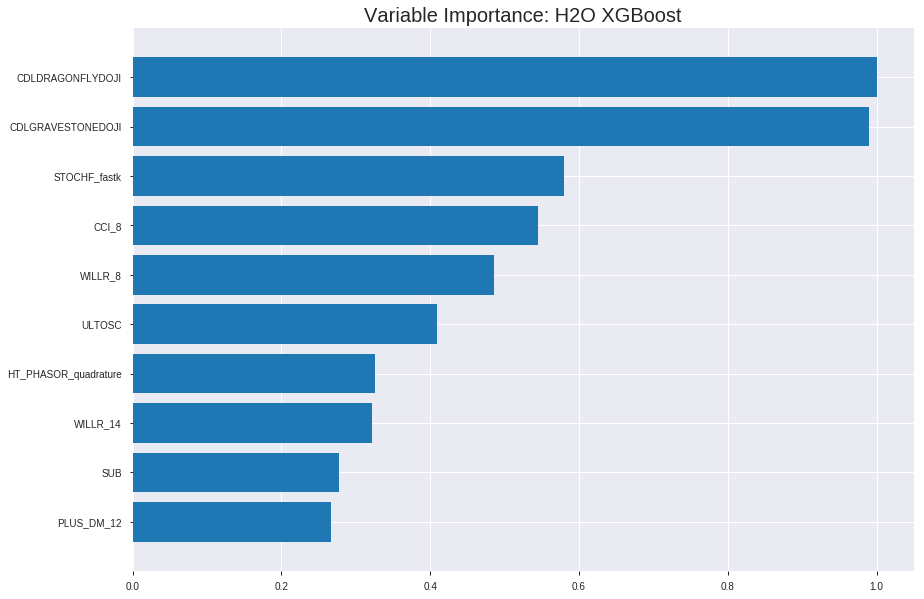

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_162856_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1250733973288607
RMSE: 0.3536571748584506
LogLoss: 0.4038126274061981
Mean Per-Class Error: 0.14872562137411482
AUC: 0.9325011108293941
pr_auc: 0.9349931743783477
Gini: 0.8650022216587883
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4789296090602875: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      677  176   0.2063   (176.0/853.0)
1      91   843   0.0974   (91.0/934.0)
Total  768  1019  0.1494   (267.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.47893      0.863287  218
max f2                       0.38155      0.913568  265
max f0point5                 0.572623     0.873131  178
max accuracy                 0.511625     0.851707  203
max precision                0.96998      1         0
max recall                   0.165495     1         349
max specificity              0.96998      1         0
max absolute_mcc             0.511625     0.702738  203
max min_per_class_accuracy   0.518989     0.845824  199
max mean_per_class_accuracy  0.511625     0.851274  203

Gains/Lift Table: Avg response rate: 52.27 %, avg score: 52.32 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.958332           1.91328    1.91328            1                0.965524   1                           0.965524            0.0192719       0.0192719                  91.3276   91.3276
    2        0.0201455                   0.952114           1.91328    1.91328            1                0.954498   1                           0.960011            0.0192719       0.0385439                  91.3276   91.3276
    3        0.0302182                   0.946724           1.91328    1.91328            1                0.950003   1                           0.956675            0.0192719       0.0578158                  91.3276   91.3276
    4        0.040291                    0.941924           1.91328    1.91328            1                0.944559   1                           0.953646            0.0192719       0.0770878                  91.3276   91.3276
    5        0.0503637                   0.936067           1.91328    1.91328            1                0.939433   1                           0.950803            0.0192719       0.0963597                  91.3276   91.3276
    6        0.100168                    0.886796           1.91328    1.91328            1                0.915018   1                           0.933011            0.0952891       0.191649                   91.3276   91.3276
    7        0.149972                    0.830224           1.91328    1.91328            1                0.858099   1                           0.908134            0.0952891       0.286938                   91.3276   91.3276
    8        0.200336                    0.780013           1.87076    1.90259            0.977778         0.802847   0.994413                    0.881665            0.0942184       0.381156                   87.0759   90.2588
    9        0.299944                    0.68756            1.7198     1.84189            0.898876         0.727605   0.962687                    0.830503            0.171306        0.552463                   71.9799   84.1885
    10       0.400112                    0.610604           1.54986    1.76878            0.810056         0.647346   0.924476                    0.78465             0.155246        0.707709                   54.9861   76.8777
    11       0.50028                     0.532009           1.20782    1.65646            0.631285         0.572162   0.865772                    0.742105            0.120985        0.828694                   20.7822   65.6461
    12       0.599888                    0.454701           0.935141   1.53669            0.488764         0.49289    0.803172                    0.700724            0.0931478       0.921842                   -6.48594  53.6689
    13       0.700056                    0.374039           0.513057   1.39022            0.268156         0.416122   0.726619                    0.660001            0.0513919       0.973233                   -48.6943  39.0222
    14       0.799664                    0.273603           0.193477   1.24115            0.101124         0.327738   0.648705                    0.618614            0.0192719       0.992505                   -80.6523  24.1153
    15       0.899832                    0.127642           0.0748209  1.11132            0.0391061        0.202491   0.580846                    0.572292            0.00749465      1                          -92.5179  11.1318
    16       1                           0.0280903          0          1                  0                0.0821902  0.522664 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.17070411463686347
RMSE: 0.4131635446610258
LogLoss: 0.5138289257711642
Mean Per-Class Error: 0.24290966386554624
AUC: 0.826031883341572
pr_auc: 0.8278240144127861
Gini: 0.6520637666831439
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44579872488975525: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      149  89   0.3739   (89.0/238.0)
1      39   233  0.1434   (39.0/272.0)
Total  188  322  0.251    (128.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.445799     0.784512  249
max f2                       0.172457     0.87281   354
max f0point5                 0.610568     0.786364  157
max accuracy                 0.552362     0.754902  187
max precision                0.970297     1         0
max recall                   0.090478     1         382
max specificity              0.970297     1         0
max absolute_mcc             0.552362     0.513289  187
max min_per_class_accuracy   0.530437     0.747899  201
max mean_per_class_accuracy  0.552362     0.75709   187

Gains/Lift Table: Avg response rate: 53.33 %, avg score: 53.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.962475           1.875     1.875              1                0.967523  1                           0.967523            0.0220588       0.0220588                  87.5      87.5
    2        0.0215686                   0.94817            1.5       1.70455            0.8              0.953393  0.909091                    0.9611              0.0147059       0.0367647                  50        70.4545
    3        0.0313725                   0.943747           1.875     1.75781            1                0.945011  0.9375                      0.956072            0.0183824       0.0551471                  87.5      75.7812
    4        0.0411765                   0.937638           1.5       1.69643            0.8              0.9414    0.904762                    0.952579            0.0147059       0.0698529                  50        69.6429
    5        0.0509804                   0.936025           1.875     1.73077            1                0.936594  0.923077                    0.949505            0.0183824       0.0882353                  87.5      73.0769
    6        0.1                         0.897632           1.8       1.76471            0.96             0.916068  0.941176                    0.933114            0.0882353       0.176471                   80        76.4706
    7        0.15098                     0.844137           1.73077   1.75325            0.923077         0.877307  0.935065                    0.91427             0.0882353       0.264706                   73.0769   75.3247
    8        0.2                         0.796881           1.575     1.70956            0.84             0.824467  0.911765                    0.89226             0.0772059       0.341912                   57.5      70.9559
    9        0.3                         0.712531           1.36029   1.59314            0.72549          0.74451   0.849673                    0.84301             0.136029        0.477941                   36.0294   59.3137
    10       0.4                         0.61352            1.47059   1.5625             0.784314         0.661114  0.833333                    0.797536            0.147059        0.625                      47.0588   56.25
    11       0.5                         0.539242           1.06618   1.46324            0.568627         0.576912  0.780392                    0.753411            0.106618        0.731618                   6.61765   46.3235
    12       0.6                         0.46594            0.955882  1.37868            0.509804         0.506372  0.735294                    0.712238            0.0955882       0.827206                   -4.41176  37.8676
    13       0.7                         0.390368           0.588235  1.26576            0.313725         0.430661  0.67507                     0.672013            0.0588235       0.886029                   -41.1765  26.5756
    14       0.8                         0.281356           0.698529  1.19485            0.372549         0.339097  0.637255                    0.630398            0.0698529       0.955882                   -30.1471  19.4853
    15       0.9                         0.157797           0.330882  1.09886            0.176471         0.220619  0.586057                    0.584867            0.0330882       0.988971                   -66.9118  9.88562
    16       1                           0.0430739          0.110294  1                  0.0588235        0.1019    0.533333                    0.536571            0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:29:04  2.544 sec   0                  0.5              0.693147            0.5             0                  1                0.477336                         0.5                0.693147              0.5               0                    1                  0.466667
    2019-08-22 16:29:04  2.607 sec   5                  0.473619         0.641237            0.806795        0.802979           1.91328          0.294348                         0.473822           0.641629              0.792102          0.803509             1.875              0.329412
    2019-08-22 16:29:04  2.674 sec   10                 0.455084         0.60487             0.840174        0.852294           1.91328          0.259653                         0.457865           0.610176              0.80741           0.817715             1.5625             0.298039
    2019-08-22 16:29:04  2.723 sec   15                 0.441037         0.576647            0.844158        0.858215           1.91328          0.252938                         0.444821           0.584115              0.821483          0.831462             1.5625             0.276471
    2019-08-22 16:29:04  2.774 sec   20                 0.430813         0.555223            0.847292        0.861268           1.91328          0.256855                         0.437773           0.568799              0.816802          0.833695             1.875              0.264706
    2019-08-22 16:29:04  2.830 sec   25                 0.422181         0.536739            0.85516         0.867997           1.91328          0.249021                         0.431632           0.555144              0.820502          0.834788             1.875              0.256863
    2019-08-22 16:29:04  2.901 sec   30                 0.413682         0.519105            0.86442         0.874722           1.91328          0.238948                         0.426545           0.544127              0.822711          0.831589             1.875              0.245098
    2019-08-22 16:29:04  2.961 sec   35                 0.407092         0.505501            0.871522        0.879785           1.91328          0.226637                         0.424237           0.538656              0.820432          0.828709             1.875              0.243137
    2019-08-22 16:29:04  3.034 sec   40                 0.399673         0.490951            0.88223         0.892461           1.91328          0.212087                         0.420547           0.531026              0.825677          0.833115             1.875              0.247059
    2019-08-22 16:29:04  3.100 sec   45                 0.392741         0.477272            0.889838        0.899237           1.91328          0.206491                         0.418448           0.526138              0.824997          0.826541             1.875              0.25098
    2019-08-22 16:29:04  3.165 sec   50                 0.387718         0.467071            0.895205        0.904575           1.91328          0.195299                         0.416534           0.521664              0.82726           0.834322             1.875              0.24902
    2019-08-22 16:29:04  3.256 sec   55                 0.382322         0.456445            0.900607        0.906397           1.91328          0.185227                         0.414491           0.517455              0.829446          0.8

Variable Importances: 


variable            relative_importance    scaled_importance     percentage
------------------  ---------------------  --------------------  ---------------------
CDLDRAGONFLYDOJI    963.265869140625       1.0                   0.10887331999941575
CDLGRAVESTONEDOJI   953.4866333007812      0.9898478331339942    0.10776801988752564
STOCHF_fastk        558.1680908203125      0.5794538233959028    0.06308706153946707
CCI_8               525.5146484375         0.5455551424305487    0.059396399599167975
WILLR_8             467.8854064941406      0.4857282101270372    0.05288284285390438
---                 ---                    ---                   ---
CDLBELTHOLD         13.019974708557129     0.013516491267538486  0.0014715852790400264
CDLLONGLEGGEDDOJI   11.860368728637695     0.012312663729297178  0.0013405205782449714
CDLSHOOTINGSTAR     9.84450626373291       0.010219926376625032  0.0011126773147727667
CDLHIGHWAVE         8.805770874023438      0.009141578826912534  0.0009952740369223321
CDLCLOSINGMARUBOZU  1.3372077941894531     0.001388202195290527  0.000151138181831757


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.76953125)

('F1', 0.7591836734693876)

('auc', 0.8297404580152672)

('logloss', 0.5096134426401036)

('mean_per_class_error', 0.23105343511450382)

('rmse', 0.41181857399727645)

('mse', 0.16959453788915027)

xgboost prediction progress: |████████████████████████████████████████████| 100%


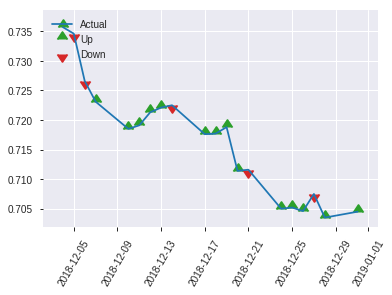


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.16959453788915027
RMSE: 0.41181857399727645
LogLoss: 0.5096134426401036
Mean Per-Class Error: 0.23105343511450382
AUC: 0.8297404580152672
pr_auc: 0.8037659019917374
Gini: 0.6594809160305344
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5293722152709961: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      104  27   0.2061   (27.0/131.0)
1      32   93   0.256    (32.0/125.0)
Total  136  120  0.2305   (59.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.529372     0.759184  119
max f2                       0.198976     0.861111  219
max f0point5                 0.598339     0.780952  99
max accuracy                 0.529372     0.769531  119
max precision                0.965118     1         0
max recall                   0.151852     1         226
max specificity              0.965118     1         0
max absolute_mcc             0.529372     0.538799  119
max min_per_class_accuracy   0.518042     0.755725  126
max mean_per_class_accuracy  0.529372     0.768947  119

Gains/Lift Table: Avg response rate: 48.83 %, avg score: 50.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.952862           2.048     2.048              1                0.96101    1                           0.96101             0.024           0.024                      104.8     104.8
    2        0.0234375                   0.936882           1.36533   1.70667            0.666667         0.943787   0.833333                    0.952399            0.016           0.04                       36.5333   70.6667
    3        0.03125                     0.930904           1.024     1.536              0.5              0.933155   0.75                        0.947588            0.008           0.048                      2.4       53.6
    4        0.0429688                   0.917559           2.048     1.67564            1                0.925032   0.818182                    0.941436            0.024           0.072                      104.8     67.5636
    5        0.0507812                   0.913222           2.048     1.73292            1                0.914302   0.846154                    0.937262            0.016           0.088                      104.8     73.2923
    6        0.101562                    0.864167           2.048     1.89046            1                0.891914   0.923077                    0.914588            0.104           0.192                      104.8     89.0462
    7        0.152344                    0.812657           1.89046   1.89046            0.923077         0.837777   0.923077                    0.888985            0.096           0.288                      89.0462   89.0462
    8        0.203125                    0.754255           1.73292   1.85108            0.846154         0.775134   0.903846                    0.860522            0.088           0.376                      73.2923   85.1077
    9        0.300781                    0.681398           1.47456   1.72883            0.72             0.714655   0.844156                    0.813163            0.144           0.52                       47.456    72.8831
    10       0.402344                    0.595866           1.41785   1.65033            0.692308         0.630613   0.805825                    0.767082            0.144           0.664                      41.7846   65.033
    11       0.5                         0.515646           1.06496   1.536              0.52             0.546391   0.75                        0.723979            0.104           0.768                      6.496     53.6
    12       0.601562                    0.420215           0.630154  1.38306            0.307692         0.466907   0.675325                    0.680577            0.064           0.832                      -36.9846  38.3065
    13       0.699219                    0.3544             0.8192    1.30431            0.4              0.391686   0.636872                    0.640229            0.08            0.912                      -18.08    30.4313
    14       0.800781                    0.257994           0.393846  1.18884            0.192308         0.308609   0.580488                    0.59817             0.04            0.952                      -60.6154  18.8839
    15       0.898438                    0.129407           0.49152   1.11304            0.24             0.20411    0.543478                    0.555337            0.048           1                          -50.848   11.3043
    16       1                           0.0327624          0         1                  0                0.0793875  0.488281                    0.506999

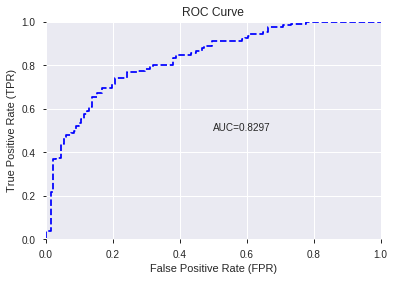

This function is available for GLM models only


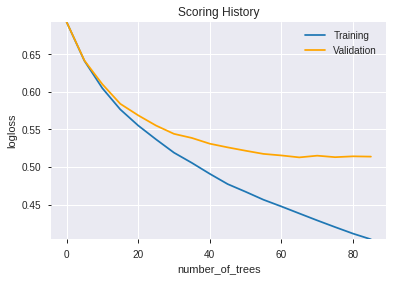

--2019-08-22 16:29:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.19.64
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.19.64|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

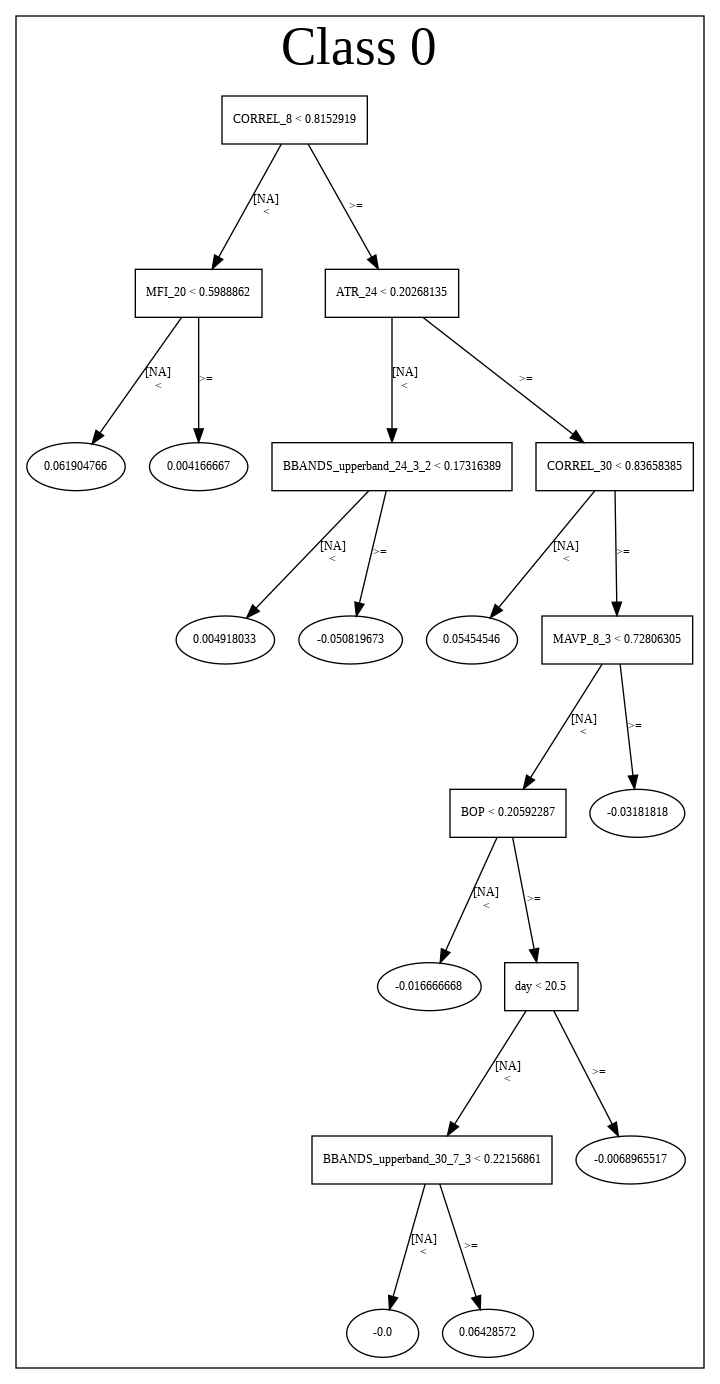

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_162856_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_162856_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_be46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'STOCHF_fastk',
 'CCI_8',
 'WILLR_8',
 'ULTOSC',
 'HT_PHASOR_quadrature',
 'WILLR_14',
 'SUB',
 'PLUS_DM_12',
 'PLUS_DI_8',
 'BETA_8',
 'WILLR_12',
 'MINUS_DI_8',
 'CCI_12',
 'CDLTAKURI',
 'CCI_20',
 'PLUS_DM_8',
 'MINUS_DI_12',
 'TRANGE',
 'CCI_24',
 'day',
 'SAREXT',
 'aroondown_8',
 'CCI_30',
 'AROONOSC_8',
 'aroondown_30',
 'month',
 'aroondown_20',
 'aroonup_8',
 'STOCHRSI_fastk',
 'dayofweek',
 'CDLRICKSHAWMAN',
 'weekday_name',
 'CDLDOJI',
 'HT_TRENDMODE',
 'CDLSPINNINGTOP',
 'weekday',
 'CDLBELTHOLD',
 'CDLLONGLEGGEDDOJI',
 'CDLSHOOTINGSTAR',
 'CDLHIGHWAVE',
 'CDLCLOSINGMARUBOZU']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

13

['PLUS_DI_8',
 'WILLR_8',
 'STOCHF_fastk',
 'ULTOSC',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER',
 'CDLSHOOTINGSTAR',
 'CDLTAKURI']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_162926_model_6  0.812519  0.536996              0.267939  0.428681  0.183768
1  DeepLearning_grid_1_AutoML_20190822_162926_model_8  0.811176  0.558415              0.285374  0.436949  0.190924
2  DeepLearning_grid_1_AutoML_20190822_162926_model_4  0.807084  0.539054              0.265221  0.426606  0.181992
3  DeepLearning_grid_1_AutoML_20190822_162926_model_5  0.804519  0.560845              0.289374  0.440668  0.194189
4               DeepLearning_1_AutoML_20190822_162926  0.803237  0.583747              0.285557  0.448932  0.201540
5  DeepLearning_grid_1_AutoML_20190822_162926_model_9  0.802992  0.546443              0.303908  0.432107  0.186716
6  DeepLearning_grid_1_AutoML_20190822_162926_model_3  0.798595  0.576710              0.261954  0.437963  0.191811
7  DeepLearning_grid_1_AutoML_20190822_162926_model_1  0.798107  0.565534              0.272489  0.431763  0.186419
8  DeepLearning_grid_1_AutoML_20190822_162926_model_2  0.792672  0.562499              0.305191  0.434435  0.188733
9  DeepLearning_grid_1_AutoML_20190822_162926_model_7  0.721527  0.559857              0.374412  0.441606  0.195016

variable  relative_importance  scaled_importance  percentage
0               ULTOSC             1.000000           1.000000    0.136838
1            PLUS_DI_8             0.977577           0.977577    0.133770
2     CDLDRAGONFLYDOJI             0.753257           0.753257    0.103074
3    CDLGRAVESTONEDOJI             0.694382           0.694382    0.095018
4            CDLTAKURI             0.680119           0.680119    0.093066
5         STOCHF_fastk             0.661080           0.661080    0.090461
6              WILLR_8             0.551174           0.551174    0.075422
7            CDLHAMMER             0.512337           0.512337    0.070107
8        CDLHANGINGMAN             0.437739           0.437739    0.059899
9          CDLBELTHOLD             0.379226           0.379226    0.051893
10  CDLCLOSINGMARUBOZU             0.275823           0.275823    0.037743
11     CDLSHOOTINGSTAR             0.212422           0.212422    0.029067
12   CDLINVERTEDHAMMER             0.172775           0.172775    0.023642

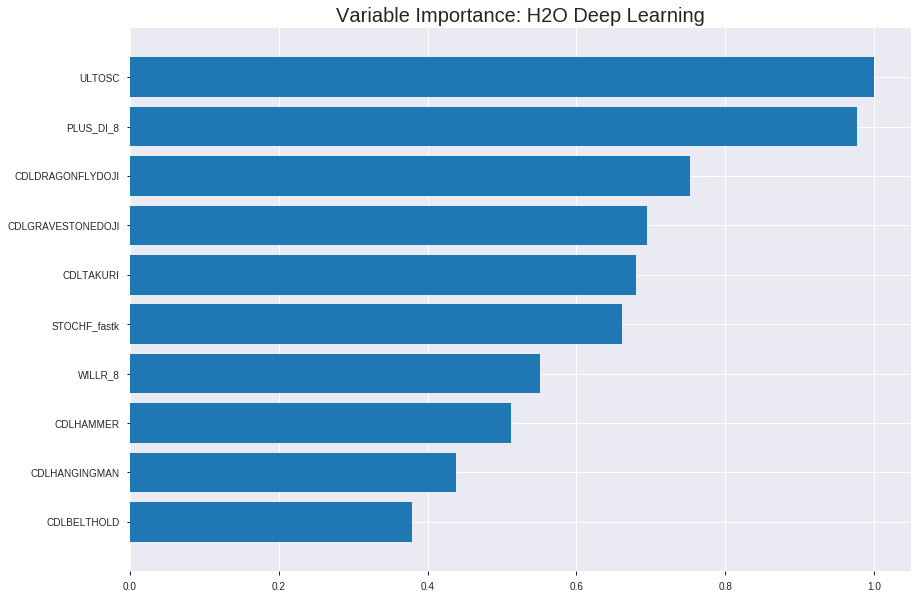

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_162926_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19461055989606074
RMSE: 0.4411468688498885
LogLoss: 0.566588633601963
Mean Per-Class Error: 0.3165531152174841
AUC: 0.7622071991786138
pr_auc: 0.7825621024957948
Gini: 0.5244143983572276
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43024338170788873: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      265  588   0.6893   (588.0/853.0)
1      43   891   0.046    (43.0/934.0)
Total  308  1479  0.3531   (631.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.430243     0.7385    296
max f2                       0.086783     0.863884  352
max f0point5                 0.546393     0.704002  187
max accuracy                 0.546393     0.68047   187
max precision                0.973885     1         0
max recall                   0.0129332    1         398
max specificity              0.973885     1         0
max absolute_mcc             0.615722     0.375728  124
max min_per_class_accuracy   0.523164     0.669165  208
max mean_per_class_accuracy  0.546393     0.683447  187

Gains/Lift Table: Avg response rate: 52.27 %, avg score: 52.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0100727                   0.971287           1.91328   1.91328            1                0.972688  1                           0.972688            0.0192719       0.0192719                  91.3276     91.3276
    2        0.0201455                   0.970103           1.80698   1.86013            0.944444         0.970641  0.972222                    0.971664            0.0182013       0.0374732                  80.6983     86.013
    3        0.0302182                   0.968848           1.91328   1.87785            1                0.969465  0.981481                    0.970931            0.0192719       0.0567452                  91.3276     87.7845
    4        0.040291                    0.967342           1.5944    1.80698            0.833333         0.968061  0.944444                    0.970214            0.01606         0.0728051                  59.4397     80.6983
    5        0.0503637                   0.966497           1.80698   1.80698            0.944444         0.966863  0.944444                    0.969544            0.0182013       0.0910064                  80.6983     80.6983
    6        0.100168                    0.947298           1.76279   1.78501            0.921348         0.959888  0.932961                    0.964743            0.0877944       0.178801                   76.2794     78.5012
    7        0.149972                    0.715174           1.7413    1.77049            0.910112         0.86836   0.925373                    0.932735            0.0867238       0.265525                   74.1296     77.0494
    8        0.200336                    0.630487           1.46685   1.69416            0.766667         0.663835  0.885475                    0.865134            0.0738758       0.3394                     46.6845     69.4158
    9        0.299944                    0.597495           1.20386   1.53133            0.629213         0.612097  0.800373                    0.781103            0.119914        0.459315                   20.3859     53.1335
    10       0.400112                    0.56094            1.05818   1.41288            0.553073         0.579249  0.738462                    0.730569            0.105996        0.56531                    5.81807     41.2881
    11       0.50028                     0.524555           0.98336   1.32688            0.513966         0.542607  0.693512                    0.692935            0.0985011       0.663812                   -1.66401    32.6881
    12       0.599888                    0.502273           0.999633  1.27254            0.522472         0.512636  0.665112                    0.662997            0.0995717       0.763383                   -0.0366913  27.2543
    13       0.700056                    0.480562           0.769586  1.20058            0.402235         0.490716  0.627498                    0.638346            0.0770878       0.840471                   -23.0414    20.0577
    14       0.799664                    0.445513           0.902894  1.1635             0.47191          0.465922  0.608118                    0.616869            0.0899358       0.930407                   -9.71056    16.3497
    15       0.899832                    0.0614676          0.555812  1.09585            0.290503         0.327653  0.572761                    0.584674            0.0556745       0.986081                   -44.4188    9.58504
    16       1                           0.0113068          0.138953  1                  0.0726257        0.033692  0.522664    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19382737981635645
RMSE: 0.4402583103319646
LogLoss: 0.583107454487453
Mean Per-Class Error: 0.28728991596638664
AUC: 0.7855289174493327
pr_auc: 0.7957451903451986
Gini: 0.5710578348986655
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47536028088805404: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      107  131  0.5504   (131.0/238.0)
1      25   247  0.0919   (25.0/272.0)
Total  132  378  0.3059   (156.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.47536      0.76      292
max f2                       0.410542     0.859477  342
max f0point5                 0.600772     0.741342  136
max accuracy                 0.531121     0.715686  226
max precision                0.973084     1         0
max recall                   0.0122498    1         398
max specificity              0.973084     1         0
max absolute_mcc             0.513402     0.429306  250
max min_per_class_accuracy   0.547285     0.705882  211
max mean_per_class_accuracy  0.531121     0.71271   226

Gains/Lift Table: Avg response rate: 53.33 %, avg score: 55.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117647                   0.971153           1.5625    1.5625             0.833333         0.972079   0.833333                    0.972079            0.0183824       0.0183824                  56.25      56.25
    2        0.0215686                   0.970531           1.5       1.53409            0.8              0.970759   0.818182                    0.971479            0.0147059       0.0330882                  50         53.4091
    3        0.0313725                   0.969593           1.875     1.64062            1                0.969917   0.875                       0.970991            0.0183824       0.0514706                  87.5       64.0625
    4        0.0411765                   0.968412           1.875     1.69643            1                0.969081   0.904762                    0.970536            0.0183824       0.0698529                  87.5       69.6429
    5        0.0509804                   0.966989           1.5       1.65865            0.8              0.967631   0.884615                    0.969977            0.0147059       0.0845588                  50         65.8654
    6        0.1                         0.951771           1.8       1.72794            0.96             0.960467   0.921569                    0.965316            0.0882353       0.172794                   80         72.7941
    7        0.15098                     0.904292           1.73077   1.7289             0.923077         0.929399   0.922078                    0.953188            0.0882353       0.261029                   73.0769    72.8896
    8        0.2                         0.672613           1.575     1.69118            0.84             0.75012    0.901961                    0.903416            0.0772059       0.338235                   57.5       69.1176
    9        0.3                         0.608596           1.36029   1.58088            0.72549          0.63532    0.843137                    0.814051            0.136029        0.474265                   36.0294    58.0882
    10       0.4                         0.581175           0.992647  1.43382            0.529412         0.592706   0.764706                    0.758715            0.0992647       0.573529                   -0.735294  43.3824
    11       0.5                         0.551429           1.17647   1.38235            0.627451         0.56712    0.737255                    0.720396            0.117647        0.691176                   17.6471    38.2353
    12       0.6                         0.520967           1.02941   1.32353            0.54902          0.534951   0.705882                    0.689488            0.102941        0.794118                   2.94118    32.3529
    13       0.7                         0.494253           0.808824  1.25               0.431373         0.506639   0.666667                    0.663367            0.0808824       0.875                      -19.1176   25
    14       0.8                         0.455934           0.551471  1.16268            0.294118         0.474747   0.620098                    0.63979             0.0551471       0.930147                   -44.8529   16.2684
    15       0.9                         0.0673337          0.404412  1.07843            0.215686         0.361932   0.575163                    0.608917            0.0404412       0.970588                   -59.5588   7.84314
    16       1                           0.0113504          0.294118  1                  0.156863         0.0334985  0.533333         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:34:05  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 16:34:08  2 min 53.054 sec  1069 obs/sec      1.34247   1             2399       0.571758         1.06621             -0.31032       0.740148        0.72307            1.80698          0.362059                         0.571545           1.05763               -0.312489        0.768599          0.792863             1.875              0.321569
    2019-08-22 16:34:15  3 min  0.662 sec  2175 obs/sec      10.9412   8             19552      0.452502         0.590244            0.179281       0.750712        0.772151           1.91328          0.376609                         0.452829           0.618907              0.176124         0.786919          0.801415             1.5625             0.288235
    2019-08-22 16:34:24  3 min  9.326 sec  2473 obs/sec      23.2289   17            41510      0.444583         0.58506             0.207755       0.755782        0.774049           1.80698          0.37493                          0.444236           0.621079              0.207093         0.787668          0.795691             1.5625             0.301961
    2019-08-22 16:34:33  3 min 18.199 sec  2632 obs/sec      36.859    27            65867      0.449907         0.588452            0.188667       0.752007        0.768164           1.70069          0.370453                         0.451892           0.611279              0.179528         0.778361          0.785808             1.5625             0.288235
    2019-08-22 16:34:40  3 min 24.926 sec  2820 obs/sec      49.0873   36            87719      0.442583         0.570836            0.21487        0.759998        0.780097           1.91328          0.36094                          0.440895           0.586829              0.218974         0.78719           0.794459             1.5625             0.286275
    2019-08-22 16:34:47  3 min 31.911 sec  2990 obs/sec      62.657    46            111968     0.441791         0.567821            0.217676       0.763034        0.771408           1.80698          0.353106                         0.441891           0.587986              0.215442         0.78661           0.798903             1.875              0.288235
    2019-08-22 16:34:53  3 min 38.608 sec  3132 obs/sec      76.2311   56            136225     0.441147         0.566589            0.219955       0.762207        0.782562           1.91328          0.353106                         0.440258           0.583107              0.221229         0.785529          0.795745             1.5625             0.305882
    2019-08-22 16:35:00  3 min 45.488 sec  3278 obs/sec      91.1987   67            162972     0.441069         0.565984            0.22023        0.764045        0.788398           1.91328          0.351987                         0.441674           0.583738              0.216212         0.784741          0.800761             1.5625             0.315686
    2019-08-22 16:35:07

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
ULTOSC              1                      1                    0.136838
PLUS_DI_8           0.977577               0.977577             0.13377
CDLDRAGONFLYDOJI    0.753257               0.753257             0.103074
CDLGRAVESTONEDOJI   0.694382               0.694382             0.0950178
CDLTAKURI           0.680119               0.680119             0.0930661
STOCHF_fastk        0.66108                0.66108              0.0904608
WILLR_8             0.551174               0.551174             0.0754215
CDLHAMMER           0.512337               0.512337             0.0701072
CDLHANGINGMAN       0.437739               0.437739             0.0598993
CDLBELTHOLD         0.379226               0.379226             0.0518926
CDLCLOSINGMARUBOZU  0.275823               0.275823             0.037743
CDLSHOOTINGSTAR     0.212422               0.212422             0.0290674
CDLINVERTEDHAMMER   0.172775               0.172775             0.0236422

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7421875)

('F1', 0.7434944237918216)

('auc', 0.8125190839694656)

('logloss', 0.5369963810989882)

('mean_per_class_error', 0.2610687022900764)

('rmse', 0.4286813722409708)

('mse', 0.18376771890640178)

deeplearning prediction progress: |███████████████████████████████████████| 100%


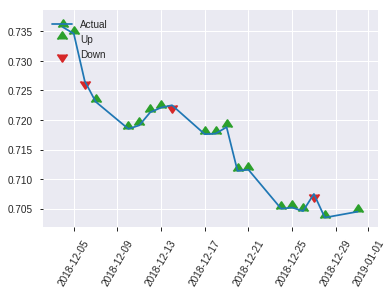


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18376771890640178
RMSE: 0.4286813722409708
LogLoss: 0.5369963810989882
Mean Per-Class Error: 0.2610687022900764
AUC: 0.8125190839694656
pr_auc: 0.8134797687583759
Gini: 0.6250381679389312
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5225973843172096: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      87   44   0.3359   (44.0/131.0)
1      25   100  0.2      (25.0/125.0)
Total  112  144  0.2695   (69.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.522597     0.743494  143
max f2                       0.357288     0.854167  219
max f0point5                 0.593689     0.766871  90
max accuracy                 0.593689     0.742188  90
max precision                0.972712     1         0
max recall                   0.0279254    1         241
max specificity              0.972712     1         0
max absolute_mcc             0.593689     0.499035  90
max min_per_class_accuracy   0.557771     0.717557  126
max mean_per_class_accuracy  0.593689     0.738931  90

Gains/Lift Table: Avg response rate: 48.83 %, avg score: 53.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.971218           2.048     2.048              1                0.972178   1                           0.972178            0.024           0.024                      104.8     104.8
    2        0.0234375                   0.970198           2.048     2.048              1                0.970523   1                           0.971351            0.024           0.048                      104.8     104.8
    3        0.03125                     0.969491           2.048     2.048              1                0.969817   1                           0.970967            0.016           0.064                      104.8     104.8
    4        0.0429688                   0.96814            2.048     2.048              1                0.968741   1                           0.97036             0.024           0.088                      104.8     104.8
    5        0.0507812                   0.967201           2.048     2.048              1                0.967432   1                           0.96991             0.016           0.104                      104.8     104.8
    6        0.101562                    0.947287           1.89046   1.96923            0.923077         0.961579   0.961538                    0.965744            0.096           0.2                        89.0462   96.9231
    7        0.152344                    0.887225           1.89046   1.94297            0.923077         0.914698   0.948718                    0.948729            0.096           0.296                      89.0462   94.2974
    8        0.203125                    0.631931           1.73292   1.89046            0.846154         0.683972   0.923077                    0.88254             0.088           0.384                      73.2923   89.0462
    9        0.300781                    0.606959           1.39264   1.72883            0.68             0.613906   0.844156                    0.795321            0.136           0.52                       39.264    72.8831
    10       0.402344                    0.576268           1.024     1.55091            0.5              0.592792   0.757282                    0.744197            0.104           0.624                      2.4       55.0913
    11       0.5                         0.556747           0.98304   1.44               0.48             0.566727   0.703125                    0.709535            0.096           0.72                       -1.696    44
    12       0.601562                    0.509302           0.866462  1.34317            0.423077         0.530598   0.655844                    0.679325            0.088           0.808                      -13.3538  34.3169
    13       0.699219                    0.481902           0.8192    1.26999            0.4              0.495772   0.620112                    0.653689            0.08            0.888                      -18.08    26.9989
    14       0.800781                    0.443468           0.551385  1.17885            0.269231         0.463275   0.57561                     0.629539            0.056           0.944                      -44.8615  17.8849
    15       0.898438                    0.0458561          0.4096    1.09523            0.2              0.273284   0.534783                    0.590816            0.04            0.984                      -59.04    9.52348
    16       1                           0.0122609          0.157538  1                  0.0769231        0.0279775  0.488281                    0.533652      

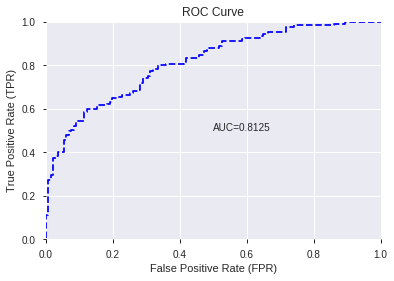

This function is available for GLM models only


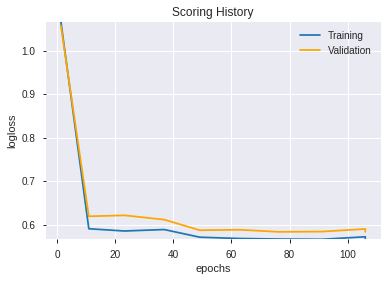

--2019-08-22 16:39:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.96.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.96.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


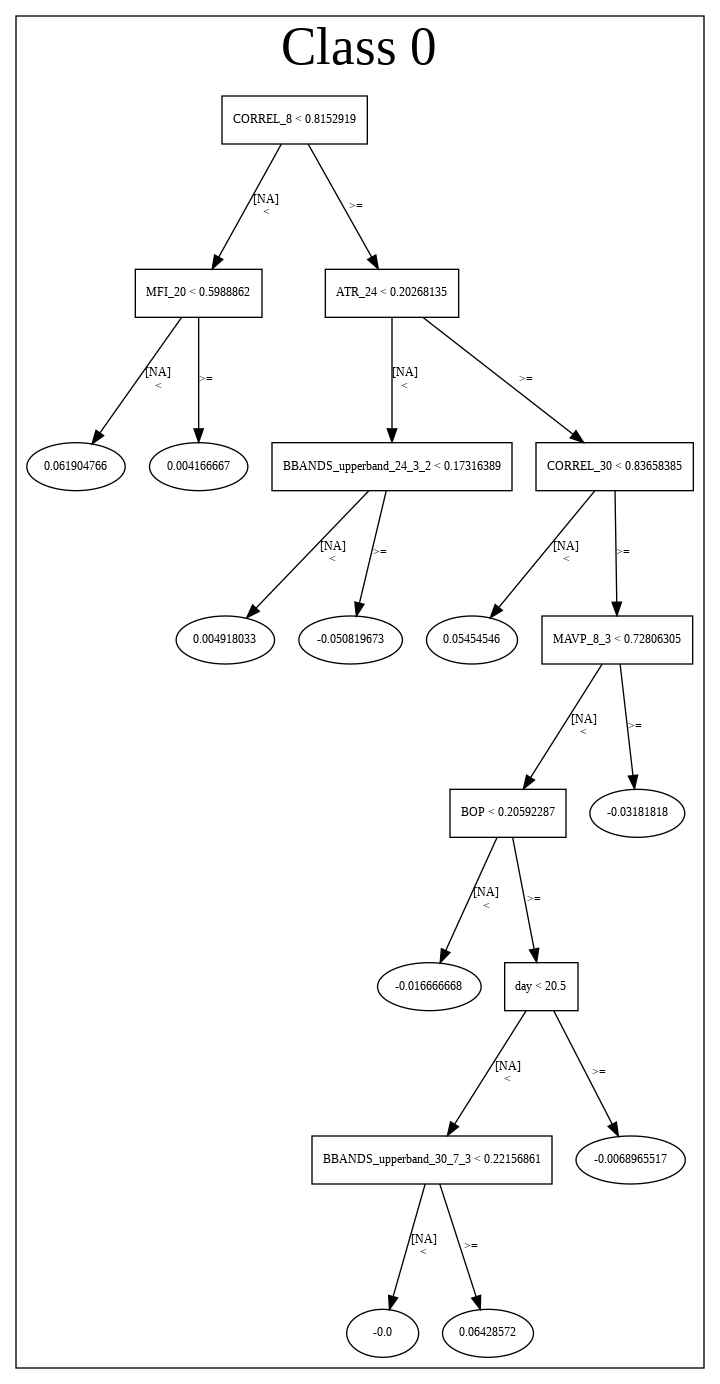

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_162926_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_162926_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_be46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['ULTOSC',
 'PLUS_DI_8',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'STOCHF_fastk',
 'WILLR_8',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLSHOOTINGSTAR',
 'CDLINVERTEDHAMMER']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_163923_model_1  0.79884  0.533065              0.295908  0.426995  0.182325

variable  relative_importance  scaled_importance  percentage
0     CDLDRAGONFLYDOJI             0.780596           1.000000    0.267449
1    CDLGRAVESTONEDOJI             0.588414           0.753800    0.201603
2            PLUS_DI_8             0.375675           0.481267    0.128714
3         STOCHF_fastk             0.355902           0.455936    0.121940
4               ULTOSC             0.262274           0.335992    0.089861
5      CDLSHOOTINGSTAR             0.141530           0.181311    0.048491
6            CDLTAKURI             0.118454           0.151748    0.040585
7          CDLBELTHOLD             0.075741           0.097030    0.025951
8            CDLHAMMER             0.065973           0.084516    0.022604
9        CDLHANGINGMAN             0.061957           0.079371    0.021228
10  CDLCLOSINGMARUBOZU             0.056094           0.071860    0.019219
11   CDLINVERTEDHAMMER             0.027114           0.034734    0.009290
12             WILLR_8             0.008948           0.011463    0.003066

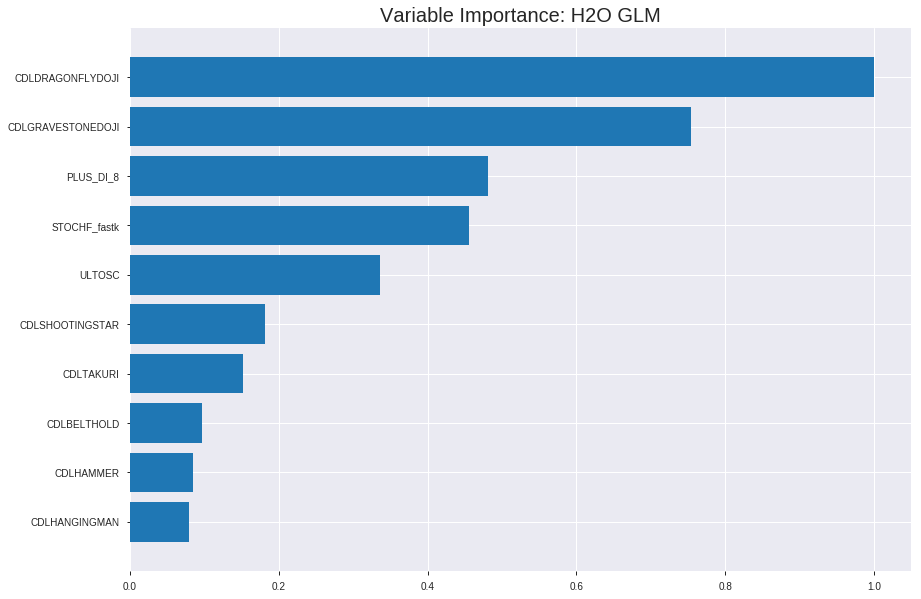

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_163923_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1964027275575473
RMSE: 0.4431734734362463
LogLoss: 0.5691955661098089
Null degrees of freedom: 1786
Residual degrees of freedom: 1773
Null deviance: 2473.635248547511
Residual deviance: 2034.3049532764571
AIC: 2062.304953276457
AUC: 0.7558873957891407
pr_auc: 0.7809035034006957
Gini: 0.5117747915782813
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39859742986829144: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      313  540   0.6331   (540.0/853.0)
1      81   853   0.0867   (81.0/934.0)
Total  394  1393  0.3475   (621.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398597     0.733133  284
max f2                       0.16791      0.862361  343
max f0point5                 0.558526     0.695103  172
max accuracy                 0.491136     0.681589  223
max precision                0.972146     1         0
max recall                   0.049224     1         394
max specificity              0.972146     1         0
max absolute_mcc             0.491136     0.361255  223
max min_per_class_accuracy   0.521247     0.672919  202
max mean_per_class_accuracy  0.516657     0.679404  205

Gains/Lift Table: Avg response rate: 52.27 %, avg score: 52.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100727                   0.955629           1.91328   1.91328            1                0.963223   1                           0.963223            0.0192719       0.0192719                  91.3276    91.3276
    2        0.0201455                   0.946161           1.91328   1.91328            1                0.950787   1                           0.957005            0.0192719       0.0385439                  91.3276    91.3276
    3        0.0302182                   0.940197           1.80698   1.87785            0.944444         0.942844   0.981481                    0.952285            0.0182013       0.0567452                  80.6983    87.7845
    4        0.040291                    0.935178           1.91328   1.8867             1                0.93814    0.986111                    0.948748            0.0192719       0.0760171                  91.3276    88.6703
    5        0.0503637                   0.931437           1.91328   1.89202            1                0.933595   0.988889                    0.945718            0.0192719       0.0952891                  91.3276    89.2018
    6        0.100168                    0.906303           1.7198    1.80639            0.898876         0.920138   0.944134                    0.932999            0.0856531       0.180942                   71.9799    80.6389
    7        0.149972                    0.760427           1.59081   1.7348             0.831461         0.860843   0.906716                    0.909037            0.0792291       0.260171                   59.0814    73.4799
    8        0.200336                    0.661644           1.4881    1.67278            0.777778         0.699359   0.874302                    0.856325            0.0749465       0.335118                   48.8104    67.2781
    9        0.299944                    0.600278           1.16086   1.50278            0.606742         0.629473   0.785448                    0.78099             0.115632        0.450749                   16.0864    50.2779
    10       0.400112                    0.558142           1.133     1.4102             0.592179         0.578904   0.737063                    0.730397            0.11349         0.56424                    13.3002    41.0205
    11       0.50028                     0.523605           0.994049  1.32688            0.519553         0.539826   0.693512                    0.692241            0.0995717       0.663812                   -0.595146  32.6881
    12       0.599888                    0.48698            1.01038   1.27433            0.52809          0.504661   0.666045                    0.661094            0.100642        0.764454                   1.03818    27.4328
    13       0.700056                    0.446335           0.833718  1.21128            0.435754         0.467223   0.633094                    0.633354            0.0835118       0.847966                   -16.6282   21.1283
    14       0.799664                    0.382773           0.741663  1.15279            0.38764          0.418002   0.602519                    0.606529            0.0738758       0.921842                   -25.8337   15.2786
    15       0.899832                    0.121025           0.619944  1.09347            0.324022         0.294234   0.571517                    0.571765            0.0620985       0.98394                    -38.0056   9.34707
    16       1                           0.0329656          0.16033   1                  0.0837989        0.0815738  0.522664  



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18840580899640985
RMSE: 0.43405737984327586
LogLoss: 0.5520214303210527
Null degrees of freedom: 509
Residual degrees of freedom: 496
Null deviance: 704.9746584600862
Residual deviance: 563.0618589274738
AIC: 591.0618589274738
AUC: 0.7905647553138903
pr_auc: 0.8104625131002131
Gini: 0.5811295106277805
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4843566176790695: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      133  105  0.4412   (105.0/238.0)
1      40   232  0.1471   (40.0/272.0)
Total  173  337  0.2843   (145.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.484357     0.761905  252
max f2                       0.12144      0.868167  361
max f0point5                 0.547766     0.741186  185
max accuracy                 0.520976     0.721569  218
max precision                0.973777     1         0
max recall                   0.0596164    1         392
max specificity              0.973777     1         0
max absolute_mcc             0.492044     0.4392    244
max min_per_class_accuracy   0.537334     0.705882  199
max mean_per_class_accuracy  0.520976     0.718225  218

Gains/Lift Table: Avg response rate: 53.33 %, avg score: 54.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.959163           1.875     1.875              1                0.965807   1                           0.965807            0.0220588       0.0220588                  87.5      87.5
    2        0.0215686                   0.951858           1.875     1.875              1                0.956139   1                           0.961413            0.0183824       0.0404412                  87.5      87.5
    3        0.0313725                   0.944467           1.875     1.875              1                0.946155   1                           0.956645            0.0183824       0.0588235                  87.5      87.5
    4        0.0411765                   0.941962           1.875     1.875              1                0.943045   1                           0.953407            0.0183824       0.0772059                  87.5      87.5
    5        0.0509804                   0.934452           1.5       1.80288            0.8              0.938625   0.961538                    0.950564            0.0147059       0.0919118                  50        80.2885
    6        0.1                         0.913534           1.65      1.72794            0.88             0.923362   0.921569                    0.93723             0.0808824       0.172794                   65        72.7941
    7        0.15098                     0.874504           1.80288   1.75325            0.961538         0.897069   0.935065                    0.923669            0.0919118       0.264706                   80.2885   75.3247
    8        0.2                         0.695833           1.5       1.69118            0.8              0.761978   0.901961                    0.884039            0.0735294       0.338235                   50        69.1176
    9        0.3                         0.620815           1.21324   1.53186            0.647059         0.652495   0.816993                    0.806857            0.121324        0.459559                   21.3235   53.1863
    10       0.4                         0.573672           1.21324   1.45221            0.647059         0.591812   0.77451                     0.753096            0.121324        0.580882                   21.3235   45.2206
    11       0.5                         0.539844           1.13971   1.38971            0.607843         0.557203   0.741176                    0.713917            0.113971        0.694853                   13.9706   38.9706
    12       0.6                         0.50859            0.882353  1.30515            0.470588         0.525092   0.696078                    0.682446            0.0882353       0.783088                   -11.7647  30.5147
    13       0.7                         0.467233           0.882353  1.24475            0.470588         0.487808   0.663866                    0.654641            0.0882353       0.871324                   -11.7647  24.4748
    14       0.8                         0.404072           0.625     1.16728            0.333333         0.434783   0.622549                    0.627159            0.0625          0.933824                   -37.5     16.7279
    15       0.9                         0.150251           0.477941  1.09069            0.254902         0.338233   0.581699                    0.595056            0.0477941       0.981618                   -52.2059  9.06863
    16       1                           0.0381578          0.183824  1                  0.0980392        0.0886552  0.533333                    0.544416   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 16:39:23  0.000 sec   2            .16E2     14            1.3686628939568246  1.36583922216741
     2019-08-22 16:39:23  0.015 sec   4            .98E1     14            1.360071240415372   1.3567355289433487
     2019-08-22 16:39:23  0.025 sec   6            .61E1     14            1.3474897717052505  1.3433738918849352
     2019-08-22 16:39:23  0.032 sec   8            .38E1     14            1.3299582710306503  1.3246871758693106
     2019-08-22 16:39:23  0.039 sec   10           .23E1     14            1.307162516633665   1.3002615260224306
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 16:39:23  0.142 sec   40           .44E-3    14            1.1383219286201574  1.1040439779568705
     2019-08-22 16:39:23  0.145 sec   41           .27E-3    14            1.1382844527188671  1.1040517261468963
     2019-08-22 16:39:23  0.153 sec   42           .17E-3    14            1.1382659065303056  1.1040579204891947
     2019-08-22 16:39:23  0.164 sec   43           .11E-3    14            1.138256950729919   1.10406328139363
     2019-08-22 16:39:23  0.168 sec   44           .66E-4    14            1.138252868147497   1.1040669907741545


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.71875)

('F1', 0.7475409836065574)

('auc', 0.7988396946564885)

('logloss', 0.5330649295192574)

('mean_per_class_error', 0.28690076335877857)

('rmse', 0.42699534817250967)

('mse', 0.18232502736096276)

glm prediction progress: |████████████████████████████████████████████████| 100%


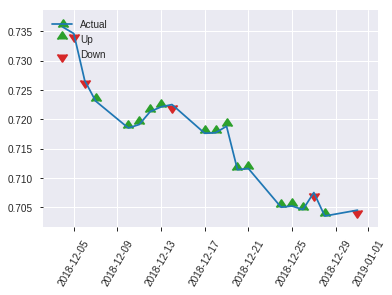


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.18232502736096276
RMSE: 0.42699534817250967
LogLoss: 0.5330649295192574
Null degrees of freedom: 255
Residual degrees of freedom: 242
Null deviance: 355.96216876159656
Residual deviance: 272.92924391385986
AIC: 300.92924391385986
AUC: 0.7988396946564885
pr_auc: 0.7985345934562431
Gini: 0.597679389312977
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44218238483878447: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   66   0.5038   (66.0/131.0)
1      11   114  0.088    (11.0/125.0)
Total  76   180  0.3008   (77.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.442182     0.747541  179
max f2                       0.175143     0.859917  220
max f0point5                 0.608127     0.766234  64
max accuracy                 0.608127     0.71875   64
max precision                0.956445     1         0
max recall                   0.105567     1         234
max specificity              0.956445     1         0
max absolute_mcc             0.608127     0.489473  64
max min_per_class_accuracy   0.541809     0.704     124
max mean_per_class_accuracy  0.608127     0.713099  64

Gains/Lift Table: Avg response rate: 48.83 %, avg score: 52.12 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.947795           2.048      2.048              1                0.953591  1                           0.953591            0.024           0.024                      104.8     104.8
    2        0.0234375                   0.939777           2.048      2.048              1                0.94188   1                           0.947735            0.024           0.048                      104.8     104.8
    3        0.03125                     0.93307            2.048      2.048              1                0.936517  1                           0.944931            0.016           0.064                      104.8     104.8
    4        0.0429688                   0.929944           2.048      2.048              1                0.930571  1                           0.941014            0.024           0.088                      104.8     104.8
    5        0.0507812                   0.923507           1.024      1.89046            0.5              0.928602  0.923077                    0.939105            0.008           0.096                      2.4       89.0462
    6        0.101562                    0.914855           2.048      1.96923            1                0.918583  0.961538                    0.928844            0.104           0.2                        104.8     96.9231
    7        0.152344                    0.877447           1.73292    1.89046            0.846154         0.900983  0.923077                    0.919557            0.088           0.288                      73.2923   89.0462
    8        0.203125                    0.653358           1.89046    1.89046            0.923077         0.708589  0.923077                    0.866815            0.096           0.384                      89.0462   89.0462
    9        0.300781                    0.59049            1.2288     1.67564            0.6              0.612207  0.818182                    0.78415             0.12            0.504                      22.88     67.5636
    10       0.402344                    0.560196           0.945231   1.49126            0.461538         0.573953  0.728155                    0.731091            0.096           0.6                        -5.47692  49.1262
    11       0.5                         0.533309           1.06496    1.408              0.52             0.550095  0.6875                      0.69574             0.104           0.704                      6.496     40.8
    12       0.601562                    0.488204           0.945231   1.32987            0.461538         0.510974  0.649351                    0.664546            0.096           0.8                        -5.47692  32.987
    13       0.699219                    0.444042           1.06496    1.29287            0.52             0.470384  0.631285                    0.637428            0.104           0.904                      6.496     29.2872
    14       0.800781                    0.389966           0.393846   1.17885            0.192308         0.416167  0.57561                     0.609366            0.04            0.944                      -60.6154  17.8849
    15       0.898438                    0.113949           0.49152    1.10414            0.24             0.258276  0.53913                     0.571204            0.048           0.992                      -50.848   10.4139
    16       1                           0.0460156          0.0787692  1                  0.0384615        0.079179  0.488281                    0.521233   

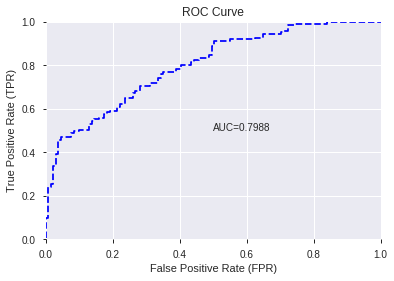

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


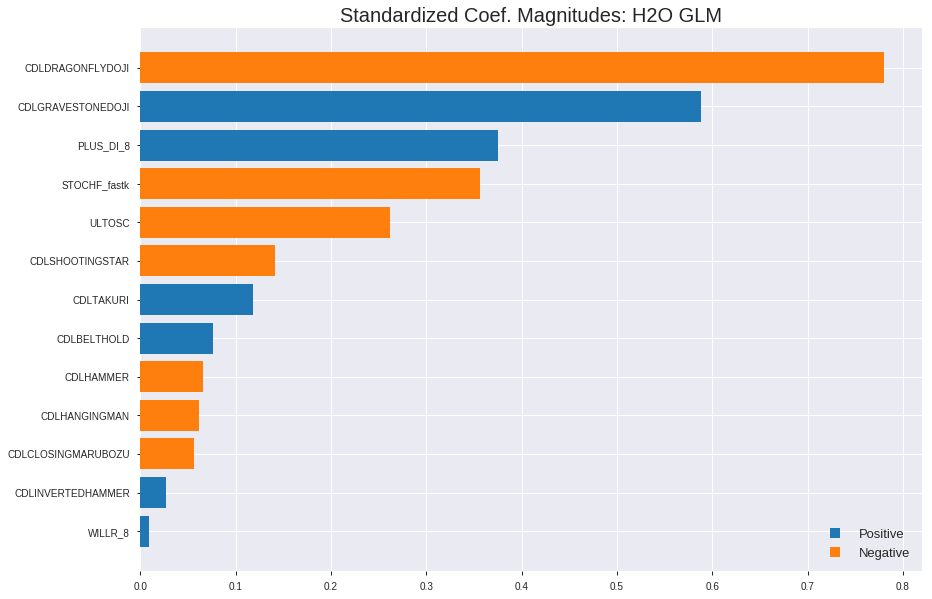

'log_likelihood'
--2019-08-22 16:39:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


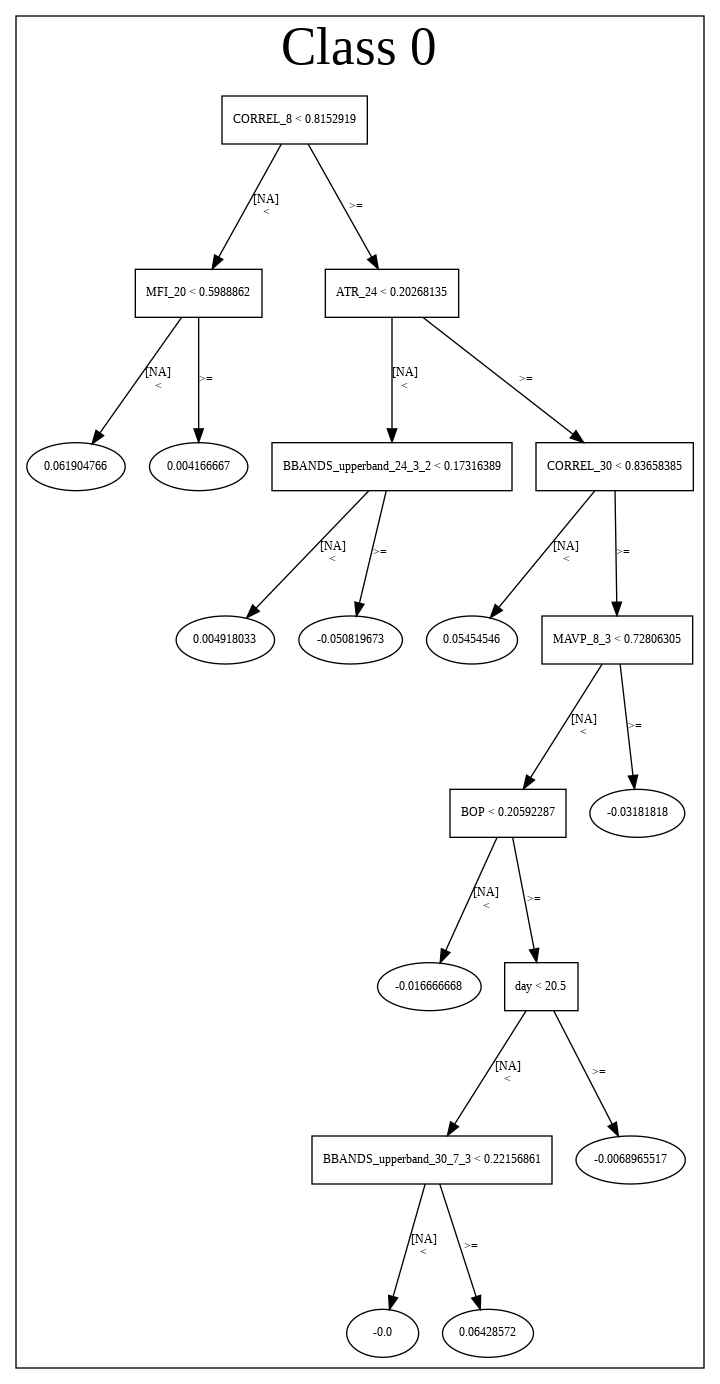

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_163923_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_163923_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_be46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'PLUS_DI_8',
 'STOCHF_fastk',
 'ULTOSC',
 'CDLSHOOTINGSTAR',
 'CDLTAKURI',
 'CDLBELTHOLD',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLCLOSINGMARUBOZU',
 'CDLINVERTEDHAMMER',
 'WILLR_8']

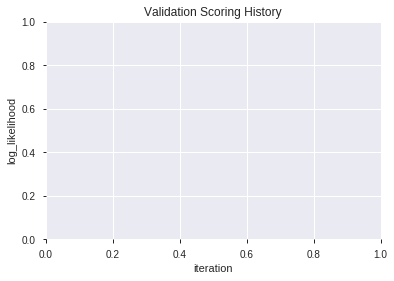

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_163934_model_2  0.805649  0.533102              0.259573  0.424441  0.180150
1  XGBoost_grid_1_AutoML_20190822_163934_model_6  0.801282  0.534742              0.333160  0.425734  0.181249
2  XGBoost_grid_1_AutoML_20190822_163934_model_1  0.801008  0.532043              0.271939  0.425003  0.180628
3               XGBoost_3_AutoML_20190822_163934  0.800427  0.533291              0.300641  0.425282  0.180865
4  XGBoost_grid_1_AutoML_20190822_163934_model_4  0.797802  0.541455              0.301191  0.427459  0.182721
5  XGBoost_grid_1_AutoML_20190822_163934_model_3  0.796519  0.536696              0.297740  0.426834  0.182188
6               XGBoost_2_AutoML_20190822_163934  0.794443  0.541680              0.280122  0.428930  0.183981
7  XGBoost_grid_1_AutoML_20190822_163934_model_7  0.784489  0.547549              0.311908  0.431876  0.186517
8               XGBoost_1_AutoML_20190822_163934  0.783084  0.551339              0.305924  0.434187  0.188518
9  XGBoost_grid_1_AutoML_20190822_163934_model_5  0.780519  0.561689              0.326809  0.438606  0.192376

variable  relative_importance  scaled_importance  percentage
0    CDLGRAVESTONEDOJI          1451.105347           1.000000    0.224222
1     CDLDRAGONFLYDOJI          1260.890137           0.868917    0.194830
2            PLUS_DI_8          1026.614014           0.707470    0.158630
3         STOCHF_fastk           912.103027           0.628557    0.140936
4               ULTOSC           880.197937           0.606571    0.136006
5              WILLR_8           533.085815           0.367365    0.082371
6            CDLTAKURI           272.922272           0.188079    0.042171
7          CDLBELTHOLD            76.508270           0.052724    0.011822
8   CDLCLOSINGMARUBOZU            26.529095           0.018282    0.004099
9        CDLHANGINGMAN            16.101025           0.011096    0.002488
10     CDLSHOOTINGSTAR            12.305590           0.008480    0.001901
11           CDLHAMMER             2.730219           0.001881    0.000422
12   CDLINVERTEDHAMMER             0.647000           0.000446    0.000100

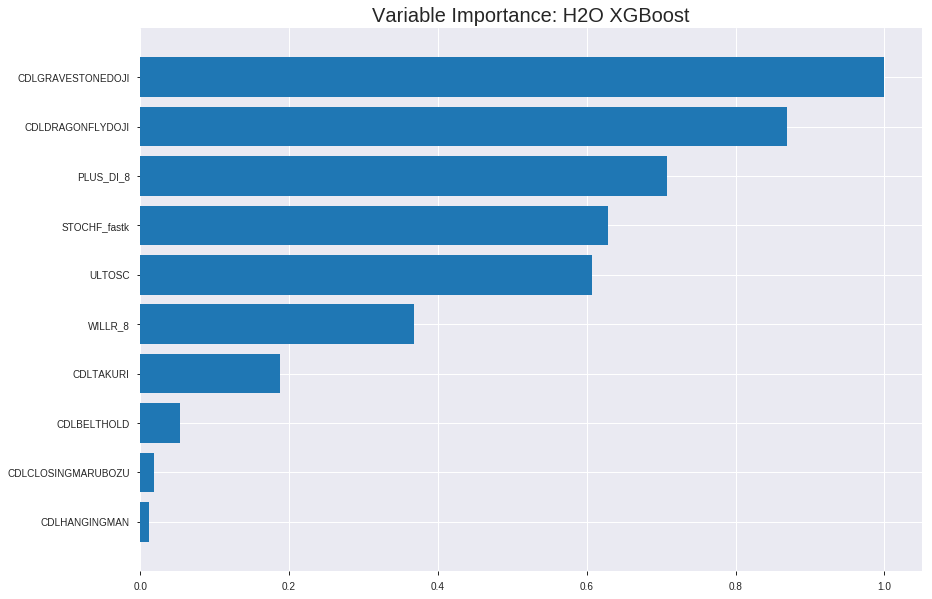

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_163934_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17458599235538308
RMSE: 0.41783488647476896
LogLoss: 0.5197653305964086
Mean Per-Class Error: 0.26792200847995873
AUC: 0.8249797289325244
pr_auc: 0.8405023126979613
Gini: 0.6499594578650487
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43813740213712055: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      487  366   0.4291   (366.0/853.0)
1      112  822   0.1199   (112.0/934.0)
Total  599  1188  0.2675   (478.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438137     0.774741  253
max f2                       0.366203     0.87225   297
max f0point5                 0.598275     0.762281  158
max accuracy                 0.438137     0.732513  253
max precision                0.934872     1         0
max recall                   0.0963258    1         393
max specificity              0.934872     1         0
max absolute_mcc             0.438137     0.477215  253
max min_per_class_accuracy   0.498657     0.724839  211
max mean_per_class_accuracy  0.547376     0.732078  183

Gains/Lift Table: Avg response rate: 52.27 %, avg score: 52.32 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.931108           1.91328    1.91328            1                0.933367  1                           0.933367            0.0192719       0.0192719                  91.3276   91.3276
    2        0.0201455                   0.924358           1.91328    1.91328            1                0.928077  1                           0.930722            0.0192719       0.0385439                  91.3276   91.3276
    3        0.0302182                   0.917666           1.91328    1.91328            1                0.921769  1                           0.927738            0.0192719       0.0578158                  91.3276   91.3276
    4        0.040291                    0.914681           1.91328    1.91328            1                0.915925  1                           0.924784            0.0192719       0.0770878                  91.3276   91.3276
    5        0.0503637                   0.910426           1.91328    1.91328            1                0.912693  1                           0.922366            0.0192719       0.0963597                  91.3276   91.3276
    6        0.100168                    0.878292           1.87028    1.8919             0.977528         0.895174  0.988827                    0.908846            0.0931478       0.189507                   87.0281   89.1899
    7        0.149972                    0.774719           1.59081    1.79191            0.831461         0.820823  0.936567                    0.879615            0.0792291       0.268737                   59.0814   79.1912
    8        0.200336                    0.704412           1.74321    1.77967            0.911111         0.739994  0.930168                    0.844514            0.0877944       0.356531                   74.3207   77.9668
    9        0.299944                    0.6413             1.42958    1.66341            0.747191         0.670861  0.869403                    0.786846            0.142398        0.498929                   42.9583   66.3408
    10       0.400112                    0.569961           1.17576    1.54132            0.614525         0.608081  0.805594                    0.742092            0.117773        0.616702                   17.5756   54.1325
    11       0.50028                     0.505079           0.98336    1.42961            0.513966         0.537406  0.747204                    0.701109            0.0985011       0.715203                   -1.66401  42.9607
    12       0.599888                    0.459391           0.935141   1.3475             0.488764         0.479099  0.704291                    0.664245            0.0931478       0.808351                   -6.48594  34.7503
    13       0.700056                    0.420953           0.940605   1.28928            0.49162          0.441571  0.673861                    0.632384            0.0942184       0.90257                    -5.93949  28.9282
    14       0.799664                    0.370285           0.60193    1.20366            0.314607         0.397039  0.629111                    0.603069            0.0599572       0.962527                   -39.807   20.3664
    15       0.899832                    0.161109           0.309972   1.10418            0.162011         0.298303  0.577114                    0.569143            0.0310493       0.993576                   -69.0028  10.4179
    16       1                           0.084331           0.0641322  1                  0.0335196        0.110848  0.522664                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1817430993291221
RMSE: 0.426313381597531
LogLoss: 0.5388566438492666
Mean Per-Class Error: 0.26234243697479
AUC: 0.8047145328719724
pr_auc: 0.8250451025374446
Gini: 0.6094290657439447
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4346463878949483: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      126  112  0.4706   (112.0/238.0)
1      36   236  0.1324   (36.0/272.0)
Total  162  348  0.2902   (148.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.434646     0.76129   269
max f2                       0.135558     0.862291  368
max f0point5                 0.603473     0.769231  157
max accuracy                 0.545449     0.735294  192
max precision                0.933312     1         0
max recall                   0.0946311    1         394
max specificity              0.933312     1         0
max absolute_mcc             0.545449     0.474623  192
max min_per_class_accuracy   0.51532      0.724265  206
max mean_per_class_accuracy  0.545449     0.737658  192

Gains/Lift Table: Avg response rate: 53.33 %, avg score: 54.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0137255                   0.930457           1.875     1.875              1                0.932246  1                           0.932246            0.0257353       0.0257353                  87.5      87.5
    2        0.0215686                   0.926442           1.875     1.875              1                0.928257  1                           0.930795            0.0147059       0.0404412                  87.5      87.5
    3        0.0313725                   0.917478           1.875     1.875              1                0.920202  1                           0.927485            0.0183824       0.0588235                  87.5      87.5
    4        0.0411765                   0.913194           1.875     1.875              1                0.915334  1                           0.924592            0.0183824       0.0772059                  87.5      87.5
    5        0.0509804                   0.91048            1.875     1.875              1                0.911804  1                           0.922133            0.0183824       0.0955882                  87.5      87.5
    6        0.1                         0.893976           1.725     1.80147            0.92             0.902837  0.960784                    0.912674            0.0845588       0.180147                   72.5      80.1471
    7        0.15098                     0.841269           1.65865   1.75325            0.884615         0.872126  0.935065                    0.898982            0.0845588       0.264706                   65.8654   75.3247
    8        0.2                         0.729904           1.8       1.76471            0.96             0.774766  0.941176                    0.868537            0.0882353       0.352941                   80        76.4706
    9        0.3                         0.677367           1.32353   1.61765            0.705882         0.704131  0.862745                    0.813735            0.132353        0.485294                   32.3529   61.7647
    10       0.4                         0.605403           1.28676   1.53493            0.686275         0.64415   0.818627                    0.771339            0.128676        0.613971                   28.6765   53.4926
    11       0.5                         0.521408           1.02941   1.43382            0.54902          0.564962  0.764706                    0.730063            0.102941        0.716912                   2.94118   43.3824
    12       0.6                         0.459103           0.661765  1.30515            0.352941         0.489249  0.696078                    0.689928            0.0661765       0.783088                   -33.8235  30.5147
    13       0.7                         0.419997           0.882353  1.24475            0.470588         0.44257   0.663866                    0.654591            0.0882353       0.871324                   -11.7647  24.4748
    14       0.8                         0.378122           0.625     1.16728            0.333333         0.39674   0.622549                    0.62236             0.0625          0.933824                   -37.5     16.7279
    15       0.9                         0.151844           0.404412  1.08252            0.215686         0.310178  0.577342                    0.587673            0.0404412       0.974265                   -59.5588  8.25163
    16       1                           0.0826996          0.257353  1                  0.137255         0.110994  0.533333                    0.540005            0.0257353   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:39:38  0.667 sec   0                  0.5              0.693147            0.5             0                  1                0.477336                         0.5                0.693147              0.5               0                    1                  0.466667
    2019-08-22 16:39:38  0.706 sec   5                  0.480434         0.654565            0.789432        0.699985           1.8954           0.326245                         0.479344           0.652472              0.805031          0.712392             1.71875            0.276471
    2019-08-22 16:39:38  0.745 sec   10                 0.466099         0.6264              0.792333        0.703609           1.8954           0.297706                         0.464381           0.623182              0.795083          0.707272             1.71875            0.260784
    2019-08-22 16:39:38  0.776 sec   15                 0.455928         0.606218            0.798465        0.741018           1.91328          0.334079                         0.455214           0.605021              0.798582          0.746617             1.71875            0.307843
    2019-08-22 16:39:38  0.814 sec   20                 0.448189         0.590209            0.800617        0.74431            1.91328          0.323447                         0.447565           0.589317              0.799563          0.751532             1.71196            0.272549
    2019-08-22 16:39:38  0.851 sec   25                 0.442295         0.577434            0.803039        0.751756           1.91328          0.326245                         0.441845           0.577091              0.802799          0.753742             1.71196            0.296078
    2019-08-22 16:39:38  0.886 sec   30                 0.437927         0.567546            0.805297        0.772394           1.91328          0.301063                         0.438033           0.568401              0.802699          0.768949             1.875              0.305882
    2019-08-22 16:39:38  0.926 sec   35                 0.434596         0.559655            0.805341        0.772562           1.91328          0.295467                         0.434781           0.560889              0.803958          0.769818             1.875              0.3
    2019-08-22 16:39:38  0.971 sec   40                 0.43195          0.553235            0.806126        0.773391           1.91328          0.318411                         0.432623           0.555577              0.802799          0.769128             1.875              0.298039
    2019-08-22 16:39:38  1.016 sec   45                 0.429631         0.547542            0.808414        0.79119            1.91328          0.318411                         0.430725           0.551002              0.80463           0.792706             1.875              0.301961
    2019-08-22 16:39:38  1.062 sec   50                 0.427899         0.543207            0.810549        0.810035           1.91328          0.312255                         0.429718           0.548413              0.805889          0.820374             1.875              0.3
    2019-08-22 16:39:38  1.129 sec   55                 0.426187         0.538887            0.812149        0.813539           1.91328          0.292669                         0.428732           0.545754              0.806352          0.820769   

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
CDLGRAVESTONEDOJI   1451.11                1                    0.224222
CDLDRAGONFLYDOJI    1260.89                0.868917             0.19483
PLUS_DI_8           1026.61                0.70747              0.15863
STOCHF_fastk        912.103                0.628557             0.140936
ULTOSC              880.198                0.606571             0.136006
WILLR_8             533.086                0.367365             0.0823713
CDLTAKURI           272.922                0.188079             0.0421714
CDLBELTHOLD         76.5083                0.0527241            0.0118219
CDLCLOSINGMARUBOZU  26.5291                0.018282             0.00409922
CDLHANGINGMAN       16.101                 0.0110957            0.0024879
CDLSHOOTINGSTAR     12.3056                0.00848015           0.00190143
CDLHAMMER           2.73022                0.00188148           0.000421868
CDLINVERTEDHAMMER   0.647                  0.000445867          9.99731e-05

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.73828125)

('F1', 0.7563636363636365)

('auc', 0.8056488549618321)

('logloss', 0.5331023474068618)

('mean_per_class_error', 0.2595725190839695)

('rmse', 0.42444058099312426)

('mse', 0.1801498067937809)

xgboost prediction progress: |████████████████████████████████████████████| 100%


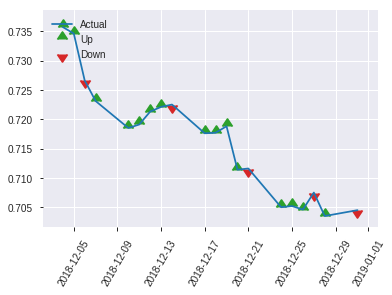


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1801498067937809
RMSE: 0.42444058099312426
LogLoss: 0.5331023474068618
Mean Per-Class Error: 0.2595725190839695
AUC: 0.8056488549618321
pr_auc: 0.7921172598942834
Gini: 0.6112977099236643
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44984370470046997: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      85   46   0.3511   (46.0/131.0)
1      21   104  0.168    (21.0/125.0)
Total  106  150  0.2617   (67.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449844     0.756364  149
max f2                       0.306656     0.857741  215
max f0point5                 0.605739     0.739958  86
max accuracy                 0.449844     0.738281  149
max precision                0.933438     1         0
max recall                   0.113144     1         233
max specificity              0.933438     1         0
max absolute_mcc             0.449844     0.487985  149
max min_per_class_accuracy   0.507908     0.717557  126
max mean_per_class_accuracy  0.449844     0.740427  149

Gains/Lift Table: Avg response rate: 48.83 %, avg score: 51.30 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.928017           2.048      2.048              1                0.931354  1                           0.931354            0.024           0.024                      104.8     104.8
    2        0.0234375                   0.926063           2.048      2.048              1                0.926756  1                           0.929055            0.024           0.048                      104.8     104.8
    3        0.03125                     0.915713           1.024      1.792              0.5              0.920279  0.875                       0.926861            0.008           0.056                      2.4       79.2
    4        0.0429688                   0.910022           2.048      1.86182            1                0.912526  0.909091                    0.922951            0.024           0.08                       104.8     86.1818
    5        0.0507812                   0.901297           2.048      1.89046            1                0.905488  0.923077                    0.920265            0.016           0.096                      104.8     89.0462
    6        0.101562                    0.877194           1.89046    1.89046            0.923077         0.892795  0.923077                    0.90653             0.096           0.192                      89.0462   89.0462
    7        0.152344                    0.791855           1.89046    1.89046            0.923077         0.845763  0.923077                    0.886274            0.096           0.288                      89.0462   89.0462
    8        0.203125                    0.722411           1.57538    1.81169            0.769231         0.74631   0.884615                    0.851283            0.08            0.368                      57.5385   81.1692
    9        0.300781                    0.628935           1.31072    1.64904            0.64             0.665551  0.805195                    0.790981            0.128           0.496                      31.072    64.9039
    10       0.402344                    0.561437           1.26031    1.55091            0.615385         0.598694  0.757282                    0.742442            0.128           0.624                      26.0308   55.0913
    11       0.5                         0.505681           0.98304    1.44               0.48             0.536099  0.703125                    0.702141            0.096           0.72                       -1.696    44
    12       0.601562                    0.447117           1.18154    1.39636            0.576923         0.469122  0.681818                    0.6628              0.12            0.84                       18.1538   39.6364
    13       0.699219                    0.40385            0.4096     1.25855            0.2              0.421519  0.614525                    0.629102            0.04            0.88                       -59.04    25.8547
    14       0.800781                    0.351422           0.708923   1.18884            0.346154         0.378346  0.580488                    0.597298            0.072           0.952                      -29.1077  18.8839
    15       0.898438                    0.122012           0.4096     1.10414            0.2              0.247685  0.53913                     0.559297            0.04            0.992                      -59.04    10.4139
    16       1                           0.0872097          0.0787692  1                  0.0384615        0.103125  0.488281                    0.512967   

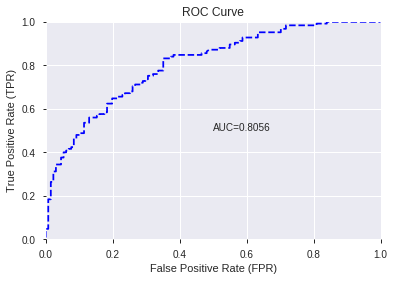

This function is available for GLM models only


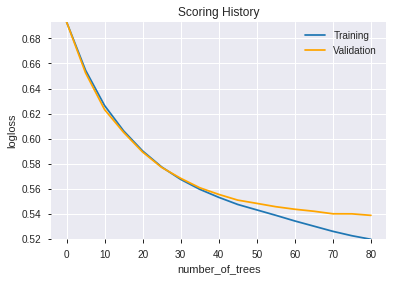

--2019-08-22 16:39:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

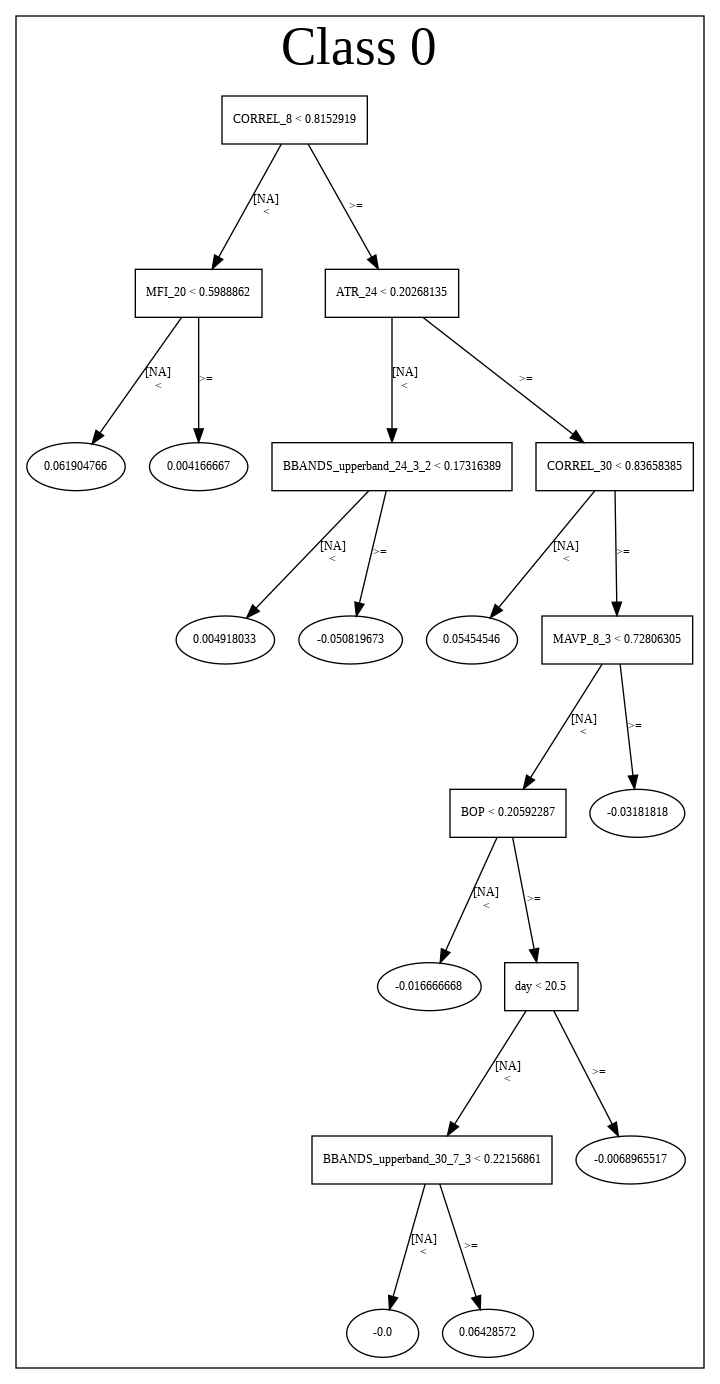

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_163934_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_163934_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_be46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'PLUS_DI_8',
 'STOCHF_fastk',
 'ULTOSC',
 'WILLR_8',
 'CDLTAKURI',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLHANGINGMAN',
 'CDLSHOOTINGSTAR',
 'CDLHAMMER',
 'CDLINVERTEDHAMMER']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

53

['BBANDS_lowerband_14_7_5',
 'BBANDS_upperband_24_5_3',
 'BBANDS_lowerband_24_5_5',
 'BBANDS_lowerband_30_0_5',
 'BBANDS_lowerband_30_5_4',
 'aroondown_8',
 'aroonup_8',
 'DX_8',
 'PLUS_DI_8',
 'RSI_8',
 'AROONOSC_12',
 'CCI_12',
 'ROCP_12',
 'WILLR_12',
 'CCI_14',
 'MACDFIX_hist_14',
 'MINUS_DI_14',
 'MOM_14',
 'WILLR_14',
 'aroondown_20',
 'MINUS_DI_20',
 'ROC_20',
 'ROCR_20',
 'ROCR100_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'DX_24',
 'MACDFIX_24',
 'PLUS_DI_24',
 'PLUS_DM_24',
 'PLUS_DI_30',
 'ROC_30',
 'ROCP_30',
 'WILLR_30',
 'MACD_hist',
 'MACDEXT_hist',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'NATR_20',
 'TRANGE',
 'HT_DCPERIOD',
 'HT_PHASOR_quadrature',
 'CDLDOJISTAR',
 'CDLGRAVESTONEDOJI',
 'CDLRICKSHAWMAN',
 'CDLTAKURI',
 'LINEARREG_SLOPE_8',
 'CORREL_12',
 'LINEARREG_SLOPE_12',
 'VAR_12',
 'LINEARREG_SLOPE_14']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_164103_model_9  0.805588  0.541523              0.283573  0.430266  0.185129
1               DeepLearning_1_AutoML_20190822_164103  0.796092  0.611296              0.271939  0.453815  0.205948
2  DeepLearning_grid_1_AutoML_20190822_164103_model_5  0.783786  0.573732              0.301740  0.436521  0.190551
3  DeepLearning_grid_1_AutoML_20190822_164103_model_7  0.782595  0.654913              0.330260  0.462354  0.213772
4  DeepLearning_grid_1_AutoML_20190822_164103_model_8  0.771053  0.589647              0.299023  0.445908  0.198834
5  DeepLearning_grid_1_AutoML_20190822_164103_model_6  0.769252  0.559834              0.315176  0.435352  0.189531
6  DeepLearning_grid_1_AutoML_20190822_164103_model_3  0.756519  0.760869              0.304122  0.519052  0.269415
7  DeepLearning_grid_1_AutoML_20190822_164103_model_4  0.752061  0.669077              0.284489  0.476618  0.227165
8  DeepLearning_grid_1_AutoML_20190822_164103_model_2  0.736000  0.897811              0.371145  0.541116  0.292806
9  DeepLearning_grid_1_AutoML_20190822_164103_model_1  0.728916  0.920050              0.299573  0.534550  0.285743

variable  relative_importance  scaled_importance  percentage
0         CDLGRAVESTONEDOJI             1.000000           1.000000    0.045894
1                 CDLTAKURI             0.958379           0.958379    0.043984
2            CDLRICKSHAWMAN             0.868029           0.868029    0.039837
3                 PLUS_DI_8             0.757291           0.757291    0.034755
4                    TRANGE             0.637134           0.637134    0.029241
5              STOCHF_fastk             0.558201           0.558201    0.025618
6                    CCI_12             0.477312           0.477312    0.021906
7                      DX_8             0.467358           0.467358    0.021449
8                     DX_24             0.459691           0.459691    0.021097
9               CDLDOJISTAR             0.459033           0.459033    0.021067
10                aroonup_8             0.454867           0.454867    0.020876
11              HT_DCPERIOD             0.433018           0.433018    0.019873
12                   CCI_24             0.430995           0.430995    0.019780
13             aroondown_20             0.424024           0.424024    0.019460
14              MINUS_DI_14             0.419676           0.419676    0.019261
15                   CCI_14             0.409536           0.409536    0.018795
16     HT_PHASOR_quadrature             0.402697           0.402697    0.018481
17                CORREL_12             0.402679           0.402679    0.018480
18               PLUS_DI_24             0.398398           0.398398    0.018284
19                 WILLR_14             0.385074           0.385074    0.017673
20              MINUS_DI_20             0.383758           0.383758    0.017612
21                 WILLR_12             0.382395           0.382395    0.017550
22                   VAR_12             0.372422           0.372422    0.017092
23                  ROCP_12             0.370666           0.370666    0.017011
24               PLUS_DM_24             0.365444           0.365444    0.016772
25               PLUS_DI_30             0.360012           0.360012    0.016522
26  BBANDS_lowerband_24_5_5             0.358251           0.358251    0.016442
27                 WILLR_20             0.357128           0.357128    0.016390
28  BBANDS_lowerband_30_5_4             0.354487           0.354487    0.016269
29  BBANDS_upperband_24_5_3             0.354199           0.354199    0.016256
30              STOCH_slowk             0.352009           0.352009    0.016155
31             MACDEXT_hist             0.351742           0.351742    0.016143
32               ROCR100_20             0.348320           0.348320    0.015986
33                  NATR_20             0.347616           0.347616    0.015953
34             STOCHF_fastd             0.337525           0.337525    0.015490
35  BBANDS_lowerband_30_0_5             0.337179           0.337179    0.015474
36                    RSI_8             0.336536           0.336536    0.015445
37        LINEARREG_SLOPE_8             0.334992           0.334992    0.015374
38                  ROCR_20             0.334900           0.334900    0.015370
39              aroondown_8             0.323412           0.323412    0.014843
40                  ROCP_30             0.322728           0.322728    0.014811
41  BBANDS_lowerband_14_7_5             0.321957           0.321957    0.014776
42                   ROC_30             0.316837           0.316837    0.014541
43                   ROC_20             0.316132           0.316132    0.014509
44                   CMO_24             0.308037           0.308037    0.014137
45       LINEARREG_SLOPE_12             0.302904           0.302904    0.013901
46              AROONOSC_12             0.301763           0.301763    0.013849
47                MACD_hist             0.300041           0.300041    0.013770
48               MACDFIX_24             0.291302           0.291302    0.013369
49       LINEARREG_

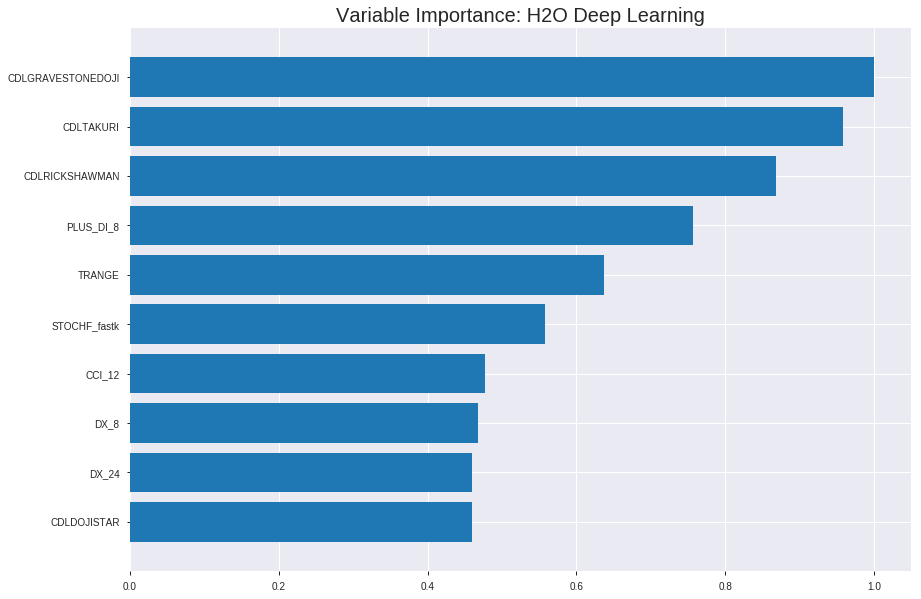

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_164103_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1663204967093781
RMSE: 0.40782410020666765
LogLoss: 0.48996539351567353
Mean Per-Class Error: 0.25940753255294957
AUC: 0.83430128203519
pr_auc: 0.8505878010971144
Gini: 0.6686025640703801
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4697747352205796: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      383  470   0.551    (470.0/853.0)
1      47   887   0.0503   (47.0/934.0)
Total  430  1357  0.2893   (517.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469775     0.774334  248
max f2                       0.220321     0.880611  313
max f0point5                 0.575722     0.770477  172
max accuracy                 0.535722     0.737549  199
max precision                0.995162     1         0
max recall                   0.0207499    1         392
max specificity              0.995162     1         0
max absolute_mcc             0.535722     0.48376   199
max min_per_class_accuracy   0.526423     0.726846  209
max mean_per_class_accuracy  0.535722     0.740592  199

Gains/Lift Table: Avg response rate: 52.27 %, avg score: 54.56 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.990704           1.91328    1.91328            1                0.992499   1                           0.992499            0.0192719       0.0192719                  91.3276   91.3276
    2        0.0201455                   0.988281           1.80698    1.86013            0.944444         0.989526   0.972222                    0.991013            0.0182013       0.0374732                  80.6983   86.013
    3        0.0302182                   0.985448           1.91328    1.87785            1                0.986805   0.981481                    0.98961             0.0192719       0.0567452                  91.3276   87.7845
    4        0.040291                    0.981353           1.91328    1.8867             1                0.982738   0.986111                    0.987892            0.0192719       0.0760171                  91.3276   88.6703
    5        0.0503637                   0.978194           1.91328    1.89202            1                0.979856   0.988889                    0.986285            0.0192719       0.0952891                  91.3276   89.2018
    6        0.100168                    0.960359           1.89178    1.8919             0.988764         0.970439   0.988827                    0.978406            0.0942184       0.189507                   89.1779   89.1899
    7        0.149972                    0.919695           1.78429    1.85616            0.932584         0.94403    0.970149                    0.96699             0.0888651       0.278373                   78.4291   85.6164
    8        0.200336                    0.829952           1.61566    1.7957             0.844444         0.882269   0.938547                    0.945691            0.0813704       0.359743                   61.5655   79.5701
    9        0.299944                    0.623549           1.46183    1.68483            0.764045         0.715001   0.880597                    0.869081            0.14561         0.505353                   46.1829   68.4825
    10       0.400112                    0.546062           1.18645    1.56006            0.620112         0.574263   0.815385                    0.795274            0.118844        0.624197                   18.6445   56.0056
    11       0.50028                     0.5272             0.940605   1.43603            0.49162          0.535142   0.750559                    0.743189            0.0942184       0.718415                   -5.93949  43.6027
    12       0.599888                    0.521118           0.967387   1.35821            0.505618         0.52394    0.709888                    0.706784            0.0963597       0.814775                   -3.26131  35.8212
    13       0.700056                    0.513499           0.876473   1.28928            0.458101         0.518259   0.673861                    0.679809            0.0877944       0.90257                    -12.3527  28.9282
    14       0.799664                    0.354105           0.655673   1.21036            0.342697         0.464785   0.63261                     0.653025            0.0653105       0.96788                    -34.4327  21.0358
    15       0.899832                    0.0780339          0.256529   1.10418            0.134078         0.195192   0.577114                    0.60206             0.0256959       0.993576                   -74.3471  10.4179
    16       1                           0.00486949         0.0641322  1                  0.0335196        0.0387531  0.522664  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.17885137759841144
RMSE: 0.42290823779918435
LogLoss: 0.5262171824907814
Mean Per-Class Error: 0.25551470588235303
AUC: 0.8080279906080079
pr_auc: 0.8349026740296378
Gini: 0.6160559812160158
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5059053084104912: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      94   144  0.605    (144.0/238.0)
1      15   257  0.0551   (15.0/272.0)
Total  109  401  0.3118   (159.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.505905     0.763744  291
max f2                       0.266547     0.875081  339
max f0point5                 0.548319     0.79023   183
max accuracy                 0.548319     0.735294  183
max precision                0.993238     1         0
max recall                   0.0529431    1         384
max specificity              0.993238     1         0
max absolute_mcc             0.548319     0.502976  183
max min_per_class_accuracy   0.526326     0.709559  229
max mean_per_class_accuracy  0.548319     0.744485  183

Gains/Lift Table: Avg response rate: 53.33 %, avg score: 56.65 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.98511            1.875      1.875              1                0.987725   1                           0.987725            0.0220588       0.0220588                  87.5      87.5
    2        0.0215686                   0.982201           1.875      1.875              1                0.983736   1                           0.985912            0.0183824       0.0404412                  87.5      87.5
    3        0.0313725                   0.978617           1.875      1.875              1                0.980001   1                           0.984065            0.0183824       0.0588235                  87.5      87.5
    4        0.0411765                   0.976974           1.875      1.875              1                0.978061   1                           0.982635            0.0183824       0.0772059                  87.5      87.5
    5        0.0509804                   0.974193           1.875      1.875              1                0.975878   1                           0.981336            0.0183824       0.0955882                  87.5      87.5
    6        0.1                         0.949298           1.725      1.80147            0.92             0.963262   0.960784                    0.972476            0.0845588       0.180147                   72.5      80.1471
    7        0.15098                     0.907814           1.65865    1.75325            0.884615         0.927107   0.935065                    0.957157            0.0845588       0.264706                   65.8654   75.3247
    8        0.2                         0.813831           1.725      1.74632            0.92             0.866323   0.931373                    0.934894            0.0845588       0.349265                   72.5      74.6324
    9        0.3                         0.586084           1.58088    1.69118            0.843137         0.686666   0.901961                    0.852151            0.158088        0.507353                   58.0882   69.1176
    10       0.4                         0.541636           1.06618    1.53493            0.568627         0.559833   0.818627                    0.779072            0.106618        0.613971                   6.61765   53.4926
    11       0.5                         0.526606           0.919118   1.41176            0.490196         0.532288   0.752941                    0.729715            0.0919118       0.705882                   -8.08824  41.1765
    12       0.6                         0.522635           0.625      1.28064            0.333333         0.524583   0.683007                    0.695526            0.0625          0.768382                   -37.5     28.0637
    13       0.7                         0.518169           0.882353   1.22374            0.470588         0.520232   0.652661                    0.670484            0.0882353       0.856618                   -11.7647  22.3739
    14       0.8                         0.498287           0.882353   1.18107            0.470588         0.513555   0.629902                    0.650868            0.0882353       0.944853                   -11.7647  18.1066
    15       0.9                         0.197863           0.477941   1.10294            0.254902         0.368655   0.588235                    0.619511            0.0477941       0.992647                   -52.2059  10.2941
    16       1                           0.022882           0.0735294  1                  0.0392157        0.0898704  0.533333                


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:50:41  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 16:50:43  3 min 44.609 sec  489 obs/sec       0.634583  1             1134       0.463492         0.616844            0.138932       0.726373        0.740151           1.91328          0.3615                           0.489749           0.681296              0.036301         0.78254           0.808943             1.875              0.311765
    2019-08-22 16:51:00  4 min  1.778 sec  467 obs/sec       4.50028   7             8042       0.43987          0.567561            0.224466       0.784272        0.804115           1.80698          0.312815                         0.442268           0.573564              0.214102         0.800011          0.822142             1.875              0.282353
    2019-08-22 16:51:23  4 min 25.318 sec  539 obs/sec       11.6044   18            20737      0.426847         0.531023            0.269708       0.794918        0.813766           1.91328          0.312255                         0.440169           0.562273              0.221547         0.805997          0.829057             1.875              0.292157
    2019-08-22 16:51:48  4 min 50.108 sec  605 obs/sec       20.6351   32            36875      0.422659         0.522643            0.283965       0.801459        0.820737           1.91328          0.313374                         0.431829           0.546375              0.250766         0.812724          0.831252             1.875              0.305882
    2019-08-22 16:52:11  5 min 13.303 sec  646 obs/sec       29.6452   46            52976      0.420574         0.518422            0.291014       0.802065        0.823225           1.91328          0.312815                         0.425885           0.532765              0.27125          0.808098          0.823904             1.5625             0.319608
    2019-08-22 16:52:35  5 min 37.045 sec  667 obs/sec       38.5596   60            68906      0.418068         0.513667            0.299439       0.811598        0.827848           1.91328          0.289871                         0.422237           0.527547              0.283682         0.814369          0.826078             1.5625             0.284314
    2019-08-22 16:52:59  6 min  1.614 sec  695 obs/sec       48.8657   76            87323      0.416148         0.509766            0.305859       0.821441        0.838934           1.91328          0.295467                         0.426651           0.536942              0.268624         0.80663           0.828247             1.875              0.303922
    2019-08-22 16:53:23  6 min 25.266 sec  720 obs/sec       59.1651   92            105728     0.411211         0.498612            0.32223        0.829585        0.842736           1.91328          0.287633                         0.424577           0.532462              0.275718         0.805394          0.828699             1.875              0.307843
    2019-08-22 16:53:47

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLGRAVESTONEDOJI   1.0                    1.0                  0.04589388521132672
CDLTAKURI           0.9583792090415955     0.9583792090415955   0.043983745408677076
CDLRICKSHAWMAN      0.8680292367935181     0.8680292367935181   0.03983723415347726
PLUS_DI_8           0.7572910785675049     0.7572910785675049   0.03475502983133887
TRANGE              0.6371337175369263     0.6371337175369263   0.029240541696905556
---                 ---                    ---                  ---
MACDFIX_24          0.2913024127483368     0.2913024127483368   0.013368999492454686
LINEARREG_SLOPE_14  0.28884029388427734    0.28884029388427734  0.0132560032919309
MACDFIX_hist_14     0.2878216803073883     0.2878216803073883   0.013209255157358456
MOM_14              0.28540533781051636    0.28540533781051636  0.013098359812175765
WILLR_30            0.2792401909828186     0.2792401909828186   0.012815417271354428


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.734375)

('F1', 0.7286245353159851)

('auc', 0.805587786259542)

('logloss', 0.5415231362277013)

('mean_per_class_error', 0.26925190839694657)

('rmse', 0.43026618311292714)

('mse', 0.18512898833056696)

deeplearning prediction progress: |███████████████████████████████████████| 100%


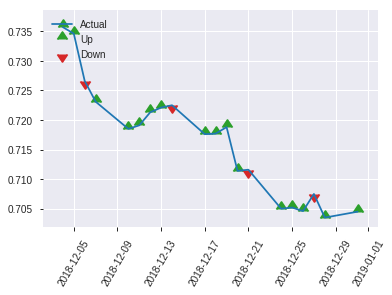


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18512898833056696
RMSE: 0.43026618311292714
LogLoss: 0.5415231362277013
Mean Per-Class Error: 0.26925190839694657
AUC: 0.805587786259542
pr_auc: 0.7911055909253328
Gini: 0.6111755725190839
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.518163438902859: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      85   46   0.3511   (46.0/131.0)
1      27   98   0.216    (27.0/125.0)
Total  112  144  0.2852   (73.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.518163     0.728625  143
max f2                       0.400751     0.857947  195
max f0point5                 0.528209     0.761099  86
max accuracy                 0.528209     0.734375  86
max precision                0.988628     1         0
max recall                   0.173969     1         213
max specificity              0.988628     1         0
max absolute_mcc             0.528209     0.48703   86
max min_per_class_accuracy   0.520671     0.704     119
max mean_per_class_accuracy  0.528209     0.730748  86

Gains/Lift Table: Avg response rate: 48.83 %, avg score: 52.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.974129           1.36533   1.36533            0.666667         0.981493   0.666667                    0.981493            0.016           0.016                      36.5333   36.5333
    2        0.0234375                   0.967923           2.048     1.70667            1                0.970105   0.833333                    0.975799            0.024           0.04                       104.8     70.6667
    3        0.03125                     0.960296           2.048     1.792              1                0.963725   0.875                       0.972781            0.016           0.056                      104.8     79.2
    4        0.0429688                   0.95277            2.048     1.86182            1                0.956165   0.909091                    0.968249            0.024           0.08                       104.8     86.1818
    5        0.0507812                   0.951301           2.048     1.89046            1                0.951463   0.923077                    0.965667            0.016           0.096                      104.8     89.0462
    6        0.101562                    0.926783           1.89046   1.89046            0.923077         0.943013   0.923077                    0.95434             0.096           0.192                      89.0462   89.0462
    7        0.152344                    0.831142           1.89046   1.89046            0.923077         0.890317   0.923077                    0.932999            0.096           0.288                      89.0462   89.0462
    8        0.203125                    0.624891           1.89046   1.89046            0.923077         0.720523   0.923077                    0.87988             0.096           0.384                      89.0462   89.0462
    9        0.300781                    0.534109           1.31072   1.70223            0.64             0.564433   0.831169                    0.777462            0.128           0.512                      31.072    70.2234
    10       0.402344                    0.524032           1.10277   1.55091            0.538462         0.526953   0.757282                    0.714227            0.112           0.624                      10.2769   55.0913
    11       0.5                         0.519352           0.90112   1.424              0.44             0.521541   0.695312                    0.676593            0.088           0.712                      -9.888    42.4
    12       0.640625                    0.517941           0.796444  1.28624            0.388889         0.518239   0.628049                    0.641832            0.112           0.824                      -20.3556  28.6244
    13       0.699219                    0.513779           0.955733  1.25855            0.466667         0.515582   0.614525                    0.631253            0.056           0.88                       -4.42667  25.8547
    14       0.800781                    0.454593           0.708923  1.18884            0.346154         0.496482   0.580488                    0.61416             0.072           0.952                      -29.1077  18.8839
    15       0.898438                    0.159418           0.49152   1.11304            0.24             0.30953    0.543478                    0.581048            0.048           1                          -50.848   11.3043
    16       1                           0.0142568          0         1                  0                0.0749094  0.488281                    0.529

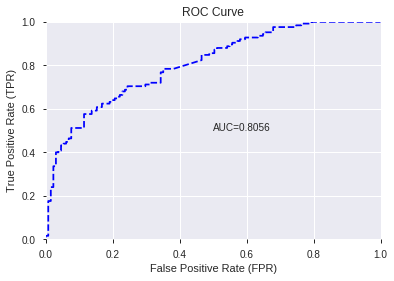

This function is available for GLM models only


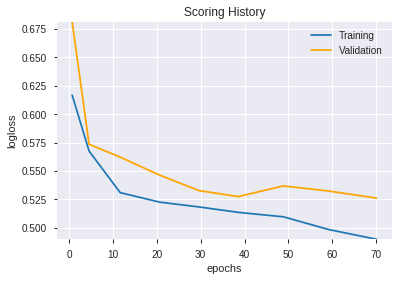

--2019-08-22 16:53:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


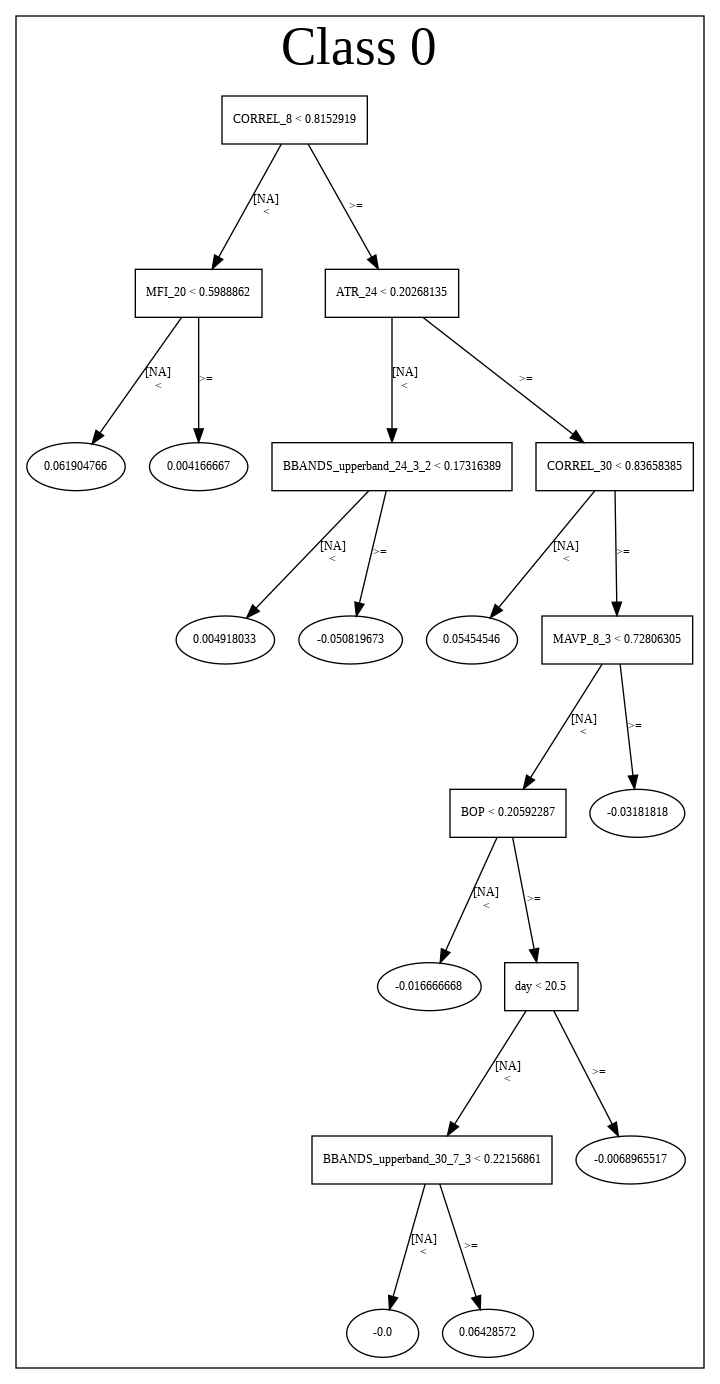

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_164103_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_164103_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_be46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'CDLRICKSHAWMAN',
 'PLUS_DI_8',
 'TRANGE',
 'STOCHF_fastk',
 'CCI_12',
 'DX_8',
 'DX_24',
 'CDLDOJISTAR',
 'aroonup_8',
 'HT_DCPERIOD',
 'CCI_24',
 'aroondown_20',
 'MINUS_DI_14',
 'CCI_14',
 'HT_PHASOR_quadrature',
 'CORREL_12',
 'PLUS_DI_24',
 'WILLR_14',
 'MINUS_DI_20',
 'WILLR_12',
 'VAR_12',
 'ROCP_12',
 'PLUS_DM_24',
 'PLUS_DI_30',
 'BBANDS_lowerband_24_5_5',
 'WILLR_20',
 'BBANDS_lowerband_30_5_4',
 'BBANDS_upperband_24_5_3',
 'STOCH_slowk',
 'MACDEXT_hist',
 'ROCR100_20',
 'NATR_20',
 'STOCHF_fastd',
 'BBANDS_lowerband_30_0_5',
 'RSI_8',
 'LINEARREG_SLOPE_8',
 'ROCR_20',
 'aroondown_8',
 'ROCP_30',
 'BBANDS_lowerband_14_7_5',
 'ROC_30',
 'ROC_20',
 'CMO_24',
 'LINEARREG_SLOPE_12',
 'AROONOSC_12',
 'MACD_hist',
 'MACDFIX_24',
 'LINEARREG_SLOPE_14',
 'MACDFIX_hist_14',
 'MOM_14',
 'WILLR_30']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse      mse
0  GLM_grid_1_AutoML_20190822_165403_model_1  0.815817  0.520536              0.284458  0.41876  0.17536

variable  relative_importance  scaled_importance  percentage
0                    CCI_12             0.713631           1.000000    0.079960
1         CDLGRAVESTONEDOJI             0.596184           0.835423    0.066800
2                 CDLTAKURI             0.545372           0.764222    0.061107
3                  WILLR_14             0.451027           0.632017    0.050536
4                     RSI_8             0.440874           0.617790    0.049398
5                    CCI_24             0.419997           0.588535    0.047059
6              STOCHF_fastk             0.402943           0.564638    0.045148
7                 PLUS_DI_8             0.373013           0.522698    0.041795
8               MINUS_DI_14             0.362767           0.508339    0.040647
9                 aroonup_8             0.325380           0.455950    0.036458
10                 WILLR_12             0.292473           0.409837    0.032771
11               MACDFIX_24             0.228830           0.320656    0.025640
12              AROONOSC_12             0.228312           0.319930    0.025582
13             aroondown_20             0.213042           0.298532    0.023871
14          MACDFIX_hist_14             0.209270           0.293246    0.023448
15                 WILLR_20             0.206944           0.289988    0.023187
16        LINEARREG_SLOPE_8             0.205794           0.288376    0.023059
17               PLUS_DI_30             0.183668           0.257371    0.020579
18                  NATR_20             0.180720           0.253240    0.020249
19                MACD_hist             0.166740           0.233651    0.018683
20       LINEARREG_SLOPE_14             0.160189           0.224470    0.017949
21  BBANDS_lowerband_14_7_5             0.142874           0.200207    0.016009
22                   CCI_14             0.139796           0.195894    0.015664
23              MINUS_DI_20             0.134184           0.188030    0.015035
24               PLUS_DI_24             0.127654           0.178880    0.014303
25               PLUS_DM_24             0.119098           0.166890    0.013345
26     HT_PHASOR_quadrature             0.098289           0.137731    0.011013
27  BBANDS_upperband_24_5_3             0.098176           0.137572    0.011000
28              aroondown_8             0.091701           0.128499    0.010275
29                   TRANGE             0.087019           0.121939    0.009750
30             MACDEXT_hist             0.080839           0.113278    0.009058
31                   MOM_14             0.076369           0.107015    0.008557
32                 WILLR_30             0.070151           0.098302    0.007860
33                   ROC_20             0.067736           0.094918    0.007590
34               ROCR100_20             0.066918           0.093772    0.007498
35                  ROCR_20             0.066796           0.093601    0.007484
36                   CMO_24             0.053607           0.075118    0.006006
37                  ROCP_12             0.051663           0.072394    0.005789
38       LINEARREG_SLOPE_12             0.050194           0.070336    0.005624
39                    DX_24             0.045304           0.063484    0.005076
40  BBANDS_lowerband_30_5_4             0.041297           0.057869    0.004627
41             STOCHF_fastd             0.040284           0.056449    0.004514
42  BBANDS_lowerband_30_0_5             0.040170           0.056290    0.004501
43              STOCH_slowk             0.039372           0.055171    0.004411
44           CDLRICKSHAWMAN             0.036502           0.051150    0.004090
45  BBANDS_lowerband_24_5_5             0.034877           0.048872    0.003908
46                CORREL_12             0.032838           0.046016    0.003679
47              CDLDOJISTAR             0.025138           0.035225    0.002817
48                   VAR_12             0.021641           0.030325    0.002425
49                 

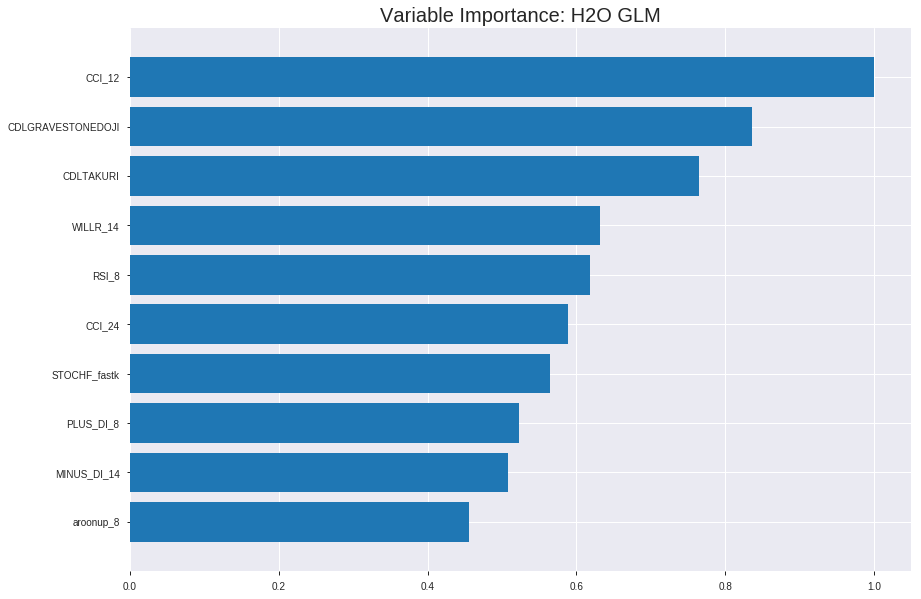

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_165403_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18086444452281644
RMSE: 0.4252816061421143
LogLoss: 0.5340691566533037
Null degrees of freedom: 1786
Residual degrees of freedom: 1733
Null deviance: 2473.635248547511
Residual deviance: 1908.7631658789069
AIC: 2016.7631658789069
AUC: 0.801384331908292
pr_auc: 0.8143339381133128
Gini: 0.6027686638165839
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3732060266062452: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      393  460   0.5393   (460.0/853.0)
1      87   847   0.0931   (87.0/934.0)
Total  480  1307  0.3061   (547.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.373206     0.755913  273
max f2                       0.221847     0.866097  331
max f0point5                 0.564241     0.745508  175
max accuracy                 0.557021     0.720201  178
max precision                0.983763     1         0
max recall                   0.0426334    1         389
max specificity              0.983763     1         0
max absolute_mcc             0.557021     0.446665  178
max min_per_class_accuracy   0.522114     0.715123  195
max mean_per_class_accuracy  0.557021     0.722675  178

Gains/Lift Table: Avg response rate: 52.27 %, avg score: 52.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.966183           1.91328   1.91328            1                0.973707   1                           0.973707            0.0192719       0.0192719                  91.3276   91.3276
    2        0.0201455                   0.958097           1.80698   1.86013            0.944444         0.961637   0.972222                    0.967672            0.0182013       0.0374732                  80.6983   86.013
    3        0.0302182                   0.94955            1.91328   1.87785            1                0.953012   0.981481                    0.962785            0.0192719       0.0567452                  91.3276   87.7845
    4        0.040291                    0.9426             1.80698   1.86013            0.944444         0.945309   0.972222                    0.958416            0.0182013       0.0749465                  80.6983   86.013
    5        0.0503637                   0.936619           1.80698   1.8495             0.944444         0.93963    0.966667                    0.954659            0.0182013       0.0931478                  80.6983   84.95
    6        0.100168                    0.895608           1.7413    1.7957             0.910112         0.914551   0.938547                    0.934717            0.0867238       0.179872                   74.1296   79.5701
    7        0.149972                    0.823963           1.7413    1.77763            0.910112         0.868718   0.929104                    0.912799            0.0867238       0.266595                   74.1296   77.7634
    8        0.200336                    0.740447           1.55188   1.72088            0.811111         0.775116   0.899441                    0.878186            0.0781585       0.344754                   55.188    72.088
    9        0.299944                    0.654238           1.33284   1.59202            0.696629         0.692342   0.83209                     0.816469            0.132762        0.477516                   33.2844   59.2017
    10       0.400112                    0.592324           1.25058   1.50654            0.653631         0.622747   0.787413                    0.767971            0.125268        0.602784                   25.0577   50.6538
    11       0.50028                     0.528745           1.0368    1.41249            0.541899         0.560443   0.738255                    0.726419            0.103854        0.706638                   3.68033   41.2486
    12       0.599888                    0.467019           0.978136  1.34036            0.511236         0.49905    0.70056                     0.688665            0.0974304       0.804069                   -2.18644  34.0364
    13       0.700056                    0.399934           0.726831  1.25258            0.379888         0.433835   0.654676                    0.652203            0.0728051       0.876874                   -27.3169  25.2577
    14       0.799664                    0.30603            0.698668  1.18358            0.365169         0.355934   0.618614                    0.615299            0.0695931       0.946467                   -30.1332  18.358
    15       0.899832                    0.129101           0.384793  1.09466            0.201117         0.22595    0.572139                    0.571957            0.0385439       0.985011                   -61.5207  9.46605
    16       1                           0.0022649          0.149642  1                  0.0782123        0.0798479  0.522664                    0.522



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18069158218742126
RMSE: 0.42507832476782587
LogLoss: 0.5355006269325504
Null degrees of freedom: 509
Residual degrees of freedom: 456
Null deviance: 704.9746584600862
Residual deviance: 546.2106394712014
AIC: 654.2106394712014
AUC: 0.8008526940187839
pr_auc: 0.8141886662296721
Gini: 0.6017053880375678
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40767532875838564: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      118  120  0.5042   (120.0/238.0)
1      30   242  0.1103   (30.0/272.0)
Total  148  362  0.2941   (150.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.407675     0.763407  272
max f2                       0.138856     0.868726  360
max f0point5                 0.689392     0.753348  121
max accuracy                 0.502242     0.729412  226
max precision                0.988451     1         0
max recall                   0.0632272    1         385
max specificity              0.988451     1         0
max absolute_mcc             0.502242     0.455333  226
max min_per_class_accuracy   0.564446     0.716912  196
max mean_per_class_accuracy  0.547451     0.726366  204

Gains/Lift Table: Avg response rate: 53.33 %, avg score: 54.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.975024           1.5625    1.5625             0.833333         0.982266   0.833333                    0.982266            0.0183824       0.0183824                  56.25     56.25
    2        0.0215686                   0.9643             1.875     1.70455            1                0.969964   0.909091                    0.976674            0.0183824       0.0367647                  87.5      70.4545
    3        0.0313725                   0.952281           1.875     1.75781            1                0.958813   0.9375                      0.971093            0.0183824       0.0551471                  87.5      75.7812
    4        0.0411765                   0.946484           1.875     1.78571            1                0.948671   0.952381                    0.965754            0.0183824       0.0735294                  87.5      78.5714
    5        0.0509804                   0.935757           1.875     1.80288            1                0.941454   0.961538                    0.961081            0.0183824       0.0919118                  87.5      80.2885
    6        0.1                         0.909751           1.65      1.72794            0.88             0.923636   0.921569                    0.942726            0.0808824       0.172794                   65        72.7941
    7        0.15098                     0.877988           1.80288   1.75325            0.961538         0.896416   0.935065                    0.927089            0.0919118       0.264706                   80.2885   75.3247
    8        0.2                         0.779164           1.8       1.76471            0.96             0.828691   0.941176                    0.902972            0.0882353       0.352941                   80        76.4706
    9        0.3                         0.690814           1.32353   1.61765            0.705882         0.72668    0.862745                    0.844208            0.132353        0.485294                   32.3529   61.7647
    10       0.4                         0.632609           0.919118  1.44301            0.490196         0.663159   0.769608                    0.798946            0.0919118       0.577206                   -8.08824  44.3015
    11       0.5                         0.569029           1.21324   1.39706            0.647059         0.603201   0.745098                    0.759797            0.121324        0.698529                   21.3235   39.7059
    12       0.6                         0.496993           1.02941   1.33578            0.54902          0.532989   0.712418                    0.721996            0.102941        0.801471                   2.94118   33.5784
    13       0.7                         0.418487           0.772059  1.25525            0.411765         0.459251   0.669468                    0.684461            0.0772059       0.878676                   -22.7941  25.5252
    14       0.8                         0.307725           0.588235  1.17188            0.313725         0.371029   0.625                       0.645282            0.0588235       0.9375                     -41.1765  17.1875
    15       0.9                         0.153239           0.441176  1.09069            0.235294         0.234459   0.581699                    0.599635            0.0441176       0.981618                   -55.8824  9.06863
    16       1                           0.021421           0.183824  1                  0.0980392        0.0925252  0.533333                    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 16:54:03  0.000 sec   2            .16E2     54            1.3736209218501207  1.3714563938178321
     2019-08-22 16:54:03  0.022 sec   4            .97E1     54            1.3675102294867025  1.3652285775028432
     2019-08-22 16:54:03  0.037 sec   6            .6E1      54            1.35820704700924    1.3557687944909884
     2019-08-22 16:54:03  0.062 sec   8            .37E1     54            1.3444438461782264  1.3418054034361786
     2019-08-22 16:54:03  0.085 sec   10           .23E1     54            1.3249748648965065  1.3221012415266258
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 16:54:04  0.307 sec   38           .29E-2    54            1.0647426961642266  1.0716339833410982
     2019-08-22 16:54:04  0.318 sec   40           .18E-2    54            1.0615151830388245  1.0733907217621441
     2019-08-22 16:54:04  0.330 sec   42           .11E-2    54            1.0585298754804588  1.0755326263837501
     2019-08-22 16:54:04  0.343 sec   44           .71E-3    54            1.0558218207109367  1.0780218805333963
     2019-08-22 16:54:04  0.355 sec   46           .44E-3    54            1.053576131811029   1.0806684526595753


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.73828125)

('F1', 0.7549668874172186)

('auc', 0.8158167938931298)

('logloss', 0.5205363533140512)

('mean_per_class_error', 0.2625038167938931)

('rmse', 0.4187599658702024)

('mse', 0.1753599090156131)

glm prediction progress: |████████████████████████████████████████████████| 100%


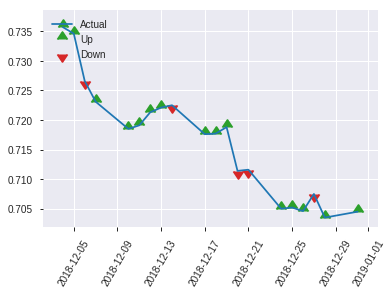


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1753599090156131
RMSE: 0.4187599658702024
LogLoss: 0.5205363533140512
Null degrees of freedom: 255
Residual degrees of freedom: 202
Null deviance: 355.96216876159656
Residual deviance: 266.5146128967943
AIC: 374.5146128967943
AUC: 0.8158167938931298
pr_auc: 0.7953764646614323
Gini: 0.6316335877862596
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3523206344620415: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      68   63   0.4809   (63.0/131.0)
1      11   114  0.088    (11.0/125.0)
Total  79   177  0.2891   (74.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.352321     0.754967  176
max f2                       0.109443     0.857339  228
max f0point5                 0.562024     0.748373  83
max accuracy                 0.491308     0.738281  117
max precision                0.981678     1         0
max recall                   0.109443     1         228
max specificity              0.981678     1         0
max absolute_mcc             0.491308     0.476318  117
max min_per_class_accuracy   0.47393      0.72      125
max mean_per_class_accuracy  0.491308     0.737496  117

Gains/Lift Table: Avg response rate: 48.83 %, avg score: 47.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.960758           2.048     2.048              1                0.975159   1                           0.975159            0.024           0.024                      104.8     104.8
    2        0.0234375                   0.952421           1.36533   1.70667            0.666667         0.955998   0.833333                    0.965579            0.016           0.04                       36.5333   70.6667
    3        0.03125                     0.946258           2.048     1.792              1                0.951898   0.875                       0.962159            0.016           0.056                      104.8     79.2
    4        0.0429688                   0.930108           2.048     1.86182            1                0.937433   0.909091                    0.955415            0.024           0.08                       104.8     86.1818
    5        0.0507812                   0.925708           2.048     1.89046            1                0.927668   0.923077                    0.951147            0.016           0.096                      104.8     89.0462
    6        0.101562                    0.899276           1.89046   1.89046            0.923077         0.91306    0.923077                    0.932103            0.096           0.192                      89.0462   89.0462
    7        0.152344                    0.825745           1.73292   1.83795            0.846154         0.86359    0.897436                    0.909266            0.088           0.28                       73.2923   83.7949
    8        0.203125                    0.687787           1.89046   1.85108            0.923077         0.739237   0.903846                    0.866758            0.096           0.376                      89.0462   85.1077
    9        0.300781                    0.580963           1.2288    1.64904            0.6              0.632087   0.805195                    0.790566            0.12            0.496                      22.88     64.9039
    10       0.402344                    0.519893           1.33908   1.5708             0.653846         0.550083   0.76699                     0.729862            0.136           0.632                      33.9077   57.0796
    11       0.5                         0.469906           0.98304   1.456              0.48             0.494239   0.710938                    0.683842            0.096           0.728                      -1.696    45.6
    12       0.601562                    0.414215           0.945231  1.36977            0.461538         0.443366   0.668831                    0.643242            0.096           0.824                      -5.47692  36.9766
    13       0.699219                    0.339084           0.90112   1.30431            0.44             0.378464   0.636872                    0.606262            0.088           0.912                      -9.888    30.4313
    14       0.800781                    0.232774           0.472615  1.19883            0.230769         0.281336   0.585366                    0.565052            0.048           0.96                       -52.7385  19.8829
    15       0.898438                    0.0929834          0.4096    1.11304            0.2              0.163517   0.543478                    0.521407            0.04            1                          -59.04    11.3043
    16       1                           0.0164184          0         1                  0                0.0559275  0.488281                    0.47413

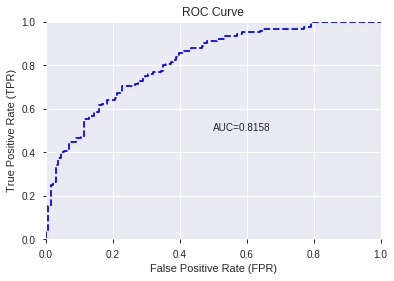

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


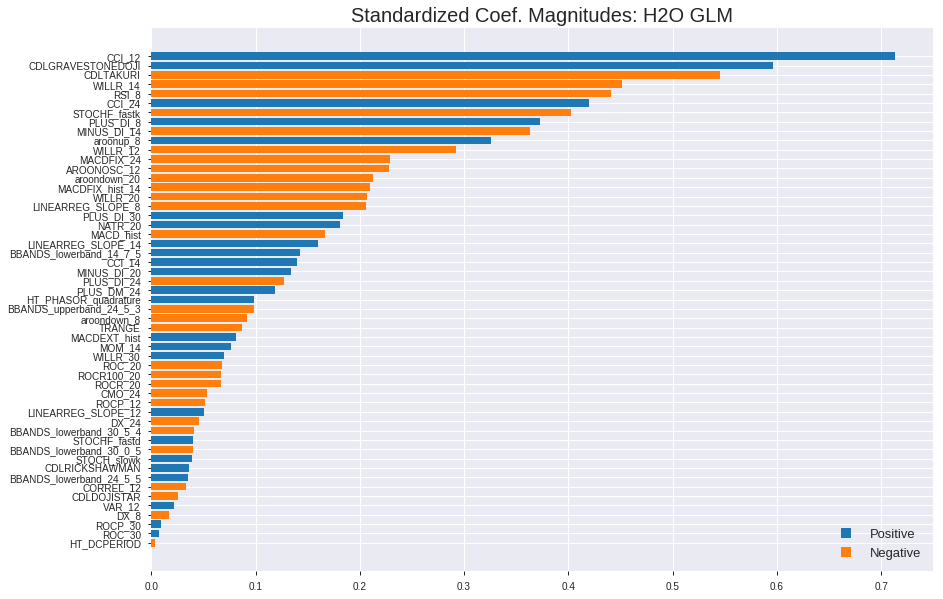

'log_likelihood'
--2019-08-22 16:54:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.88.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.88.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


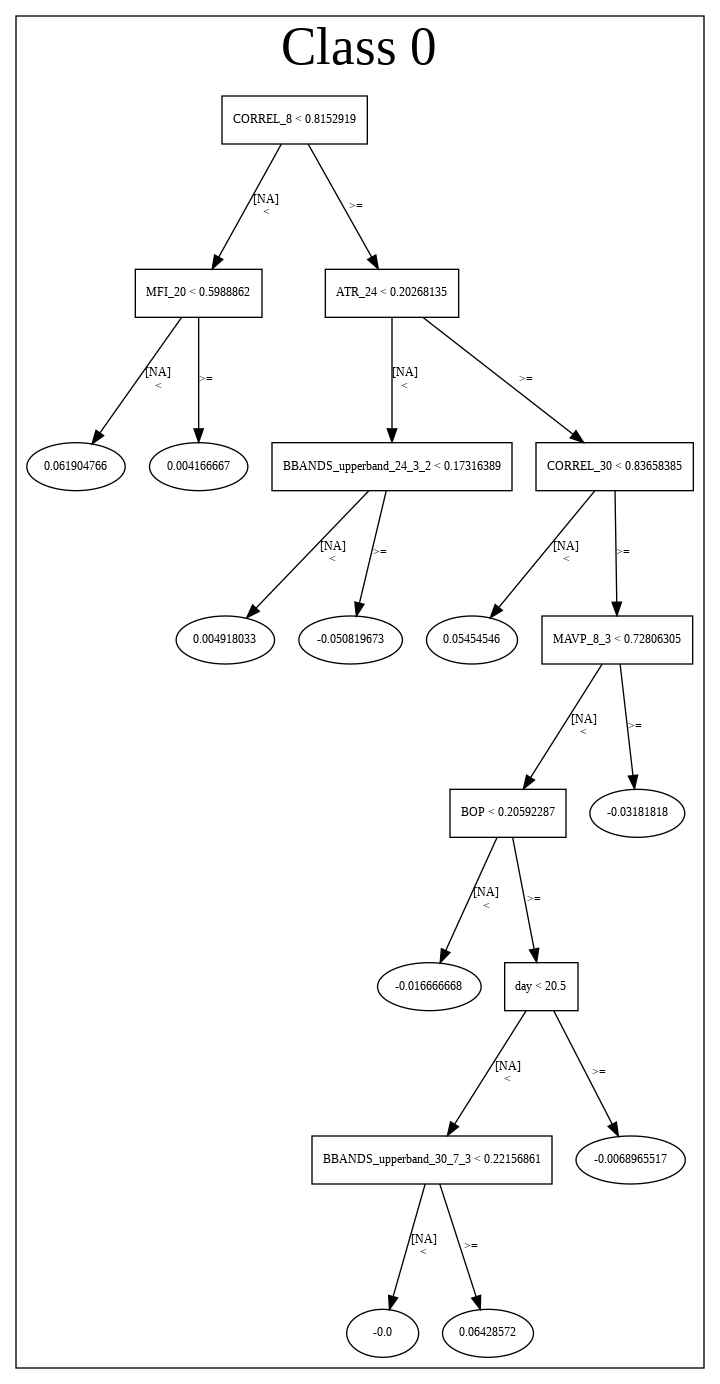

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_165403_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_165403_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_be46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CCI_12',
 'CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'WILLR_14',
 'RSI_8',
 'CCI_24',
 'STOCHF_fastk',
 'PLUS_DI_8',
 'MINUS_DI_14',
 'aroonup_8',
 'WILLR_12',
 'MACDFIX_24',
 'AROONOSC_12',
 'aroondown_20',
 'MACDFIX_hist_14',
 'WILLR_20',
 'LINEARREG_SLOPE_8',
 'PLUS_DI_30',
 'NATR_20',
 'MACD_hist',
 'LINEARREG_SLOPE_14',
 'BBANDS_lowerband_14_7_5',
 'CCI_14',
 'MINUS_DI_20',
 'PLUS_DI_24',
 'PLUS_DM_24',
 'HT_PHASOR_quadrature',
 'BBANDS_upperband_24_5_3',
 'aroondown_8',
 'TRANGE',
 'MACDEXT_hist',
 'MOM_14',
 'WILLR_30',
 'ROC_20',
 'ROCR100_20',
 'ROCR_20',
 'CMO_24',
 'ROCP_12',
 'LINEARREG_SLOPE_12',
 'DX_24',
 'BBANDS_lowerband_30_5_4',
 'STOCHF_fastd',
 'BBANDS_lowerband_30_0_5',
 'STOCH_slowk',
 'CDLRICKSHAWMAN',
 'BBANDS_lowerband_24_5_5',
 'CORREL_12',
 'CDLDOJISTAR',
 'VAR_12',
 'DX_8',
 'ROCP_30',
 'ROC_30',
 'HT_DCPERIOD']

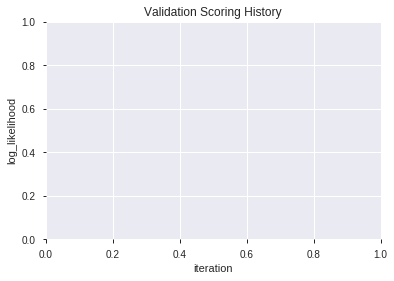

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_165415_model_1  0.822229  0.519803              0.270107  0.416715  0.173651
1               XGBoost_1_AutoML_20190822_165415  0.822107  0.521005              0.262290  0.416452  0.173433
2  XGBoost_grid_1_AutoML_20190822_165415_model_5  0.819969  0.522607              0.255756  0.417417  0.174237
3               XGBoost_3_AutoML_20190822_165415  0.819115  0.523083              0.267023  0.418503  0.175145
4  XGBoost_grid_1_AutoML_20190822_165415_model_2  0.817710  0.523188              0.293008  0.418267  0.174947
5  XGBoost_grid_1_AutoML_20190822_165415_model_6  0.816305  0.523292              0.277191  0.419140  0.175678
6  XGBoost_grid_1_AutoML_20190822_165415_model_3  0.816244  0.527722              0.263756  0.419595  0.176060
7  XGBoost_grid_1_AutoML_20190822_165415_model_7  0.815756  0.522864              0.249588  0.418465  0.175113
8               XGBoost_2_AutoML_20190822_165415  0.812397  0.534152              0.253771  0.422339  0.178370
9  XGBoost_grid_1_AutoML_20190822_165415_model_4  0.812275  0.527052              0.281191  0.420656  0.176951

variable  relative_importance  scaled_importance  percentage
0         CDLGRAVESTONEDOJI          1885.085693           1.000000    0.190506
1                 CDLTAKURI          1718.092896           0.911414    0.173630
2              STOCHF_fastk           771.533142           0.409283    0.077971
3                    CCI_12           445.492859           0.236325    0.045021
4                  WILLR_14           307.155273           0.162940    0.031041
5                 PLUS_DI_8           249.856949           0.132544    0.025250
6               aroondown_8           240.040771           0.127337    0.024258
7                 aroonup_8           206.263962           0.109419    0.020845
8      HT_PHASOR_quadrature           200.125748           0.106163    0.020225
9                  WILLR_30           191.718460           0.101703    0.019375
10             MACDEXT_hist           191.160782           0.101407    0.019319
11                    RSI_8           189.175491           0.100354    0.019118
12                   CCI_14           184.699265           0.097979    0.018666
13                     DX_8           179.036530           0.094975    0.018093
14                   ROC_20           156.632645           0.083090    0.015829
15                 WILLR_12           155.022919           0.082237    0.015667
16                 WILLR_20           153.556198           0.081458    0.015518
17               PLUS_DM_24           147.761108           0.078384    0.014933
18              HT_DCPERIOD           142.747543           0.075725    0.014426
19               PLUS_DI_30           139.886078           0.074207    0.014137
20  BBANDS_upperband_24_5_3           138.279358           0.073354    0.013974
21               MACDFIX_24           135.724518           0.071999    0.013716
22                  NATR_20           133.058655           0.070585    0.013447
23                   CCI_24           116.292709           0.061691    0.011752
24                   ROC_30           115.359299           0.061196    0.011658
25       LINEARREG_SLOPE_14            99.912933           0.053002    0.010097
26                   TRANGE            98.648476           0.052331    0.009969
27  BBANDS_lowerband_24_5_5            92.067940           0.048840    0.009304
28        LINEARREG_SLOPE_8            85.760902           0.045494    0.008667
29  BBANDS_lowerband_14_7_5            80.656631           0.042787    0.008151
30           CDLRICKSHAWMAN            70.340515           0.037314    0.007109
31                  ROCP_12            67.700027           0.035914    0.006842
32                   VAR_12            59.804775           0.031725    0.006044
33       LINEARREG_SLOPE_12            59.600185           0.031617    0.006023
34              MINUS_DI_14            59.534935           0.031582    0.006017
35          MACDFIX_hist_14            59.409199           0.031515    0.006004
36              MINUS_DI_20            55.965797           0.029689    0.005656
37  BBANDS_lowerband_30_0_5            53.973862           0.028632    0.005455
38                CORREL_12            47.598026           0.025250    0.004810
39                    DX_24            47.246761           0.025063    0.004775
40               PLUS_DI_24            46.727467           0.024788    0.004722
41                   MOM_14            45.842403           0.024318    0.004633
42                   CMO_24            44.103107           0.023396    0.004457
43              STOCH_slowk            38.802895           0.020584    0.003921
44              AROONOSC_12            38.676376           0.020517    0.003909
45                  ROCP_30            35.995857           0.019095    0.003638
46             aroondown_20            29.726879           0.015770    0.003004
47  BBANDS_lowerband_30_5_4            27.896469           0.014799    0.002819
48             STOCHF_fastd            21.180006           0.011236    0.002140
49                M

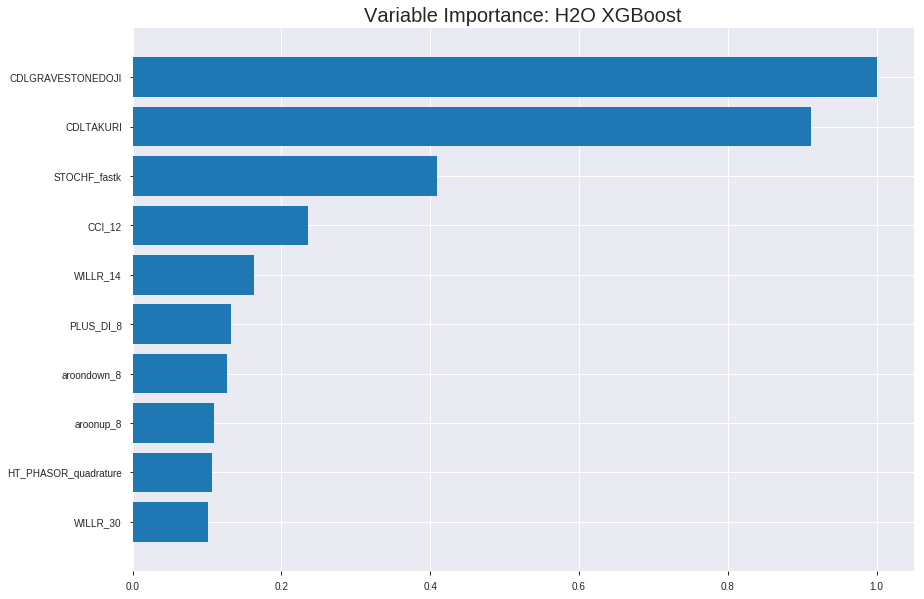

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_165415_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13247675191807812
RMSE: 0.36397355936671844
LogLoss: 0.422563533408992
Mean Per-Class Error: 0.14638409342514525
AUC: 0.9280025655765896
pr_auc: 0.9355374618457528
Gini: 0.8560051311531791
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48330022229088676: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      673  180   0.211    (180.0/853.0)
1      92   842   0.0985   (92.0/934.0)
Total  765  1022  0.1522   (272.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.4833       0.860941  215
max f2                       0.420135     0.900224  247
max f0point5                 0.58722      0.876355  163
max accuracy                 0.526534     0.852826  193
max precision                0.968122     1         0
max recall                   0.132706     1         357
max specificity              0.968122     1         0
max absolute_mcc             0.526534     0.706508  193
max min_per_class_accuracy   0.515904     0.850107  198
max mean_per_class_accuracy  0.526534     0.853616  193

Gains/Lift Table: Avg response rate: 52.27 %, avg score: 52.22 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.957069           1.91328    1.91328            1                0.960827   1                           0.960827            0.0192719       0.0192719                  91.3276   91.3276
    2        0.0201455                   0.95072            1.91328    1.91328            1                0.953143   1                           0.956985            0.0192719       0.0385439                  91.3276   91.3276
    3        0.0302182                   0.945812           1.91328    1.91328            1                0.948119   1                           0.95403             0.0192719       0.0578158                  91.3276   91.3276
    4        0.040291                    0.937633           1.91328    1.91328            1                0.942062   1                           0.951038            0.0192719       0.0770878                  91.3276   91.3276
    5        0.0503637                   0.931697           1.91328    1.91328            1                0.93503    1                           0.947836            0.0192719       0.0963597                  91.3276   91.3276
    6        0.100168                    0.891931           1.91328    1.91328            1                0.9158     1                           0.931908            0.0952891       0.191649                   91.3276   91.3276
    7        0.149972                    0.800176           1.87028    1.899              0.977528         0.840184   0.992537                    0.901447            0.0931478       0.284797                   87.0281   89.8998
    8        0.200336                    0.742435           1.8495     1.88655            0.966667         0.773641   0.986034                    0.869317            0.0931478       0.377944                   84.95     88.6554
    9        0.299944                    0.66788            1.79504    1.85616            0.938202         0.699848   0.970149                    0.813038            0.178801        0.556745                   79.504    85.6164
    10       0.400112                    0.594949           1.49642    1.7661             0.782123         0.631702   0.923077                    0.767641            0.149893        0.706638                   49.6417   76.6101
    11       0.50028                     0.524314           1.29333    1.67144            0.675978         0.55847    0.873602                    0.72576             0.12955         0.836188                   29.3332   67.1442
    12       0.599888                    0.463243           0.741663   1.51706            0.38764          0.49302    0.79291                     0.687114            0.0738758       0.910064                   -25.8337  51.7057
    13       0.700056                    0.39026            0.49168    1.37034            0.256983         0.428329   0.716227                    0.650086            0.0492505       0.959315                   -50.832   37.034
    14       0.799664                    0.310844           0.311714   1.23847            0.162921         0.35576    0.647306                    0.613424            0.0310493       0.990364                   -68.8286  23.8475
    15       0.899832                    0.137156           0.0855096  1.11013            0.0446927        0.229131   0.580224                    0.570645            0.00856531      0.998929                   -91.449   11.0129
    16       1                           0.0309304          0.0106887  1                  0.00558659       0.0869972  0.522664  



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.17571512808355405
RMSE: 0.41918388337763424
LogLoss: 0.5245750547591639
Mean Per-Class Error: 0.26207983193277307
AUC: 0.815411826495304
pr_auc: 0.8272643415374972
Gini: 0.6308236529906079
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4168301224708557: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      128  110  0.4622   (110.0/238.0)
1      33   239  0.1213   (33.0/272.0)
Total  161  349  0.2804   (143.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.41683      0.769726  267
max f2                       0.263673     0.869277  325
max f0point5                 0.584359     0.76959   156
max accuracy                 0.521722     0.737255  199
max precision                0.961006     1         0
max recall                   0.0671245    1         386
max specificity              0.961006     1         0
max absolute_mcc             0.550202     0.475672  179
max min_per_class_accuracy   0.521722     0.731618  199
max mean_per_class_accuracy  0.540974     0.73792   187

Gains/Lift Table: Avg response rate: 53.33 %, avg score: 52.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.948574           1.5625    1.5625             0.833333         0.953904   0.833333                    0.953904            0.0183824       0.0183824                  56.25     56.25
    2        0.0215686                   0.94349            1.875     1.70455            1                0.945049   0.909091                    0.949879            0.0183824       0.0367647                  87.5      70.4545
    3        0.0313725                   0.93943            1.875     1.75781            1                0.940618   0.9375                      0.946985            0.0183824       0.0551471                  87.5      75.7812
    4        0.0411765                   0.934881           1.875     1.78571            1                0.937525   0.952381                    0.944733            0.0183824       0.0735294                  87.5      78.5714
    5        0.0509804                   0.93203            1.875     1.80288            1                0.933116   0.961538                    0.942499            0.0183824       0.0919118                  87.5      80.2885
    6        0.1                         0.89004            1.725     1.76471            0.92             0.913451   0.941176                    0.92826             0.0845588       0.176471                   72.5      76.4706
    7        0.15098                     0.817394           1.65865   1.7289             0.884615         0.85878    0.922078                    0.904799            0.0845588       0.261029                   65.8654   72.8896
    8        0.2                         0.770747           1.8       1.74632            0.96             0.7944     0.931373                    0.87774             0.0882353       0.349265                   80        74.6324
    9        0.3                         0.653529           1.43382   1.64216            0.764706         0.712721   0.875817                    0.822734            0.143382        0.492647                   43.3824   64.2157
    10       0.4                         0.577817           1.17647   1.52574            0.627451         0.616377   0.813725                    0.771145            0.117647        0.610294                   17.6471   52.5735
    11       0.5                         0.527473           1.06618   1.43382            0.568627         0.551767   0.764706                    0.727269            0.106618        0.716912                   6.61765   43.3824
    12       0.6                         0.474178           0.882353  1.34191            0.470588         0.498784   0.715686                    0.689188            0.0882353       0.805147                   -11.7647  34.1912
    13       0.7                         0.406615           0.772059  1.2605             0.411765         0.44036    0.672269                    0.653641            0.0772059       0.882353                   -22.7941  26.0504
    14       0.8                         0.30468            0.698529  1.19026            0.372549         0.362207   0.634804                    0.617212            0.0698529       0.952206                   -30.1471  19.0257
    15       0.9                         0.125768           0.294118  1.09069            0.156863         0.214304   0.581699                    0.572445            0.0294118       0.981618                   -70.5882  9.06863
    16       1                           0.0346755          0.183824  1                  0.0980392        0.0823377  0.533333                    0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:54:19  0.015 sec   0                  0.5              0.693147            0.5             0                  1                0.477336                         0.5                0.693147              0.5               0                    1                  0.466667
    2019-08-22 16:54:19  0.081 sec   5                  0.47251          0.639146            0.826204        0.835872           1.91328          0.270285                         0.474006           0.642054              0.79791           0.791164             1.6875             0.27451
    2019-08-22 16:54:19  0.121 sec   10                 0.453957         0.602628            0.831765        0.847352           1.91328          0.259093                         0.455667           0.605985              0.802969          0.826489             1.875              0.282353
    2019-08-22 16:54:19  0.161 sec   15                 0.441052         0.576109            0.836832        0.845749           1.91328          0.260213                         0.444098           0.582224              0.805564          0.825113             1.875              0.278431
    2019-08-22 16:54:19  0.213 sec   20                 0.430417         0.553764            0.848903        0.85616            1.91328          0.254617                         0.437566           0.567919              0.807619          0.825595             1.875              0.268627
    2019-08-22 16:54:19  0.262 sec   25                 0.422415         0.536373            0.857949        0.868756           1.91328          0.231673                         0.433024           0.557639              0.811488          0.82726              1.875              0.270588
    2019-08-22 16:54:19  0.313 sec   30                 0.416193         0.522394            0.865121        0.874439           1.91328          0.223279                         0.430017           0.550164              0.811504          0.828117             1.875              0.272549
    2019-08-22 16:54:19  0.363 sec   35                 0.411256         0.511243            0.871424        0.881316           1.91328          0.220481                         0.428403           0.545574              0.810731          0.828087             1.875              0.280392
    2019-08-22 16:54:20  0.416 sec   40                 0.406922         0.501517            0.876901        0.886836           1.91328          0.20873                          0.427445           0.542872              0.809519          0.827636             1.875              0.280392
    2019-08-22 16:54:20  0.468 sec   45                 0.399071         0.486539            0.8882          0.893423           1.91328          0.191382                         0.424659           0.53681               0.813102          0.831096             1.875              0.276471
    2019-08-22 16:54:20  0.521 sec   50                 0.393064         0.475199            0.895369        0.903866           1.91328          0.181309                         0.424412           0.535768              0.810376          0.829092             1.875              0.288235
    2019-08-22 16:54:20  0.573 sec   55                 0.386592         0.463177            0.903093        0.911943           1.91328          0.171796                         0.421426           0.529417              0.814122          0.

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  --------------------
CDLGRAVESTONEDOJI        1885.085693359375      1.0                   0.19050578489611636
CDLTAKURI                1718.0928955078125     0.911413683505301     0.17362957914123797
STOCHF_fastk             771.5331420898438      0.4092827953698536    0.07797074017641055
CCI_12                   445.49285888671875     0.2363249906654453    0.04502127783728803
WILLR_14                 307.1552734375         0.16293968731475783   0.031040953022625713
---                      ---                    ---                   ---
aroondown_20             29.726879119873047     0.015769510757305333  0.003004183024248203
BBANDS_lowerband_30_5_4  27.896469116210938     0.014798515109675028  0.002819202736265679
STOCHF_fastd             21.18000602722168      0.011235566691653787  0.002140440451346166
MACD_hist                19.82305145263672      0.010515729615087385  0.002003307324077558
ROCR_20                  14.408143997192383     0.007643230250989761  0.001456079578106545


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.75390625)

('F1', 0.7569444444444445)

('auc', 0.8222290076335879)

('logloss', 0.5198029124688455)

('mean_per_class_error', 0.2474198473282443)

('rmse', 0.4167150520360133)

('mse', 0.17365143459337726)

xgboost prediction progress: |████████████████████████████████████████████| 100%


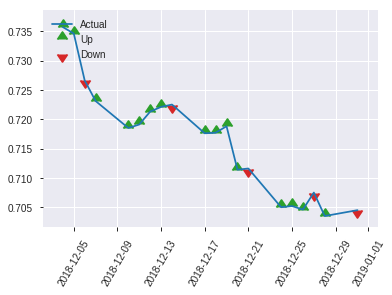


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.17365143459337726
RMSE: 0.4167150520360133
LogLoss: 0.5198029124688455
Mean Per-Class Error: 0.2474198473282443
AUC: 0.8222290076335879
pr_auc: 0.8035764496577479
Gini: 0.6444580152671757
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4143032729625702: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      77   54   0.4122   (54.0/131.0)
1      16   109  0.128    (16.0/125.0)
Total  93   163  0.2734   (70.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.414303     0.756944  162
max f2                       0.202158     0.85554   212
max f0point5                 0.607128     0.779626  88
max accuracy                 0.529041     0.753906  109
max precision                0.953073     1         0
max recall                   0.0897122    1         238
max specificity              0.953073     1         0
max absolute_mcc             0.607128     0.517605  88
max min_per_class_accuracy   0.487424     0.728     125
max mean_per_class_accuracy  0.523435     0.75258   111

Gains/Lift Table: Avg response rate: 48.83 %, avg score: 49.15 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.941182           2.048      2.048              1                0.947593   1                           0.947593            0.024           0.024                      104.8     104.8
    2        0.0234375                   0.930904           2.048      2.048              1                0.935339   1                           0.941466            0.024           0.048                      104.8     104.8
    3        0.03125                     0.922045           1.024      1.792              0.5              0.923765   0.875                       0.937041            0.008           0.056                      2.4       79.2
    4        0.0429688                   0.903109           1.36533    1.67564            0.666667         0.911201   0.818182                    0.929994            0.016           0.072                      36.5333   67.5636
    5        0.0507812                   0.892069           2.048      1.73292            1                0.892592   0.846154                    0.92424             0.016           0.088                      104.8     73.2923
    6        0.101562                    0.860912           2.048      1.89046            1                0.875885   0.923077                    0.900062            0.104           0.192                      104.8     89.0462
    7        0.152344                    0.792034           1.89046    1.89046            0.923077         0.823129   0.923077                    0.874418            0.096           0.288                      89.0462   89.0462
    8        0.203125                    0.733867           1.73292    1.85108            0.846154         0.765503   0.903846                    0.847189            0.088           0.376                      73.2923   85.1077
    9        0.300781                    0.635051           1.55648    1.75543            0.76             0.685162   0.857143                    0.794583            0.152           0.528                      55.648    75.5429
    10       0.402344                    0.557389           1.18154    1.61056            0.576923         0.600191   0.786408                    0.745513            0.12            0.648                      18.1538   61.0563
    11       0.5                         0.481168           0.8192     1.456              0.4              0.514707   0.710938                    0.700434            0.08            0.728                      -18.08    45.6
    12       0.601562                    0.426764           1.024      1.38306            0.5              0.457004   0.675325                    0.659335            0.104           0.832                      2.4       38.3065
    13       0.699219                    0.358513           0.73728    1.29287            0.36             0.399528   0.631285                    0.623049            0.072           0.904                      -26.272   29.2872
    14       0.800781                    0.265667           0.393846   1.17885            0.192308         0.312791   0.57561                     0.583699            0.04            0.944                      -60.6154  17.8849
    15       0.898438                    0.114742           0.49152    1.10414            0.24             0.171724   0.53913                     0.538919            0.048           0.992                      -50.848   10.4139
    16       1                           0.0306355          0.0787692  1                  0.0384615        0.0721021  0.488281           

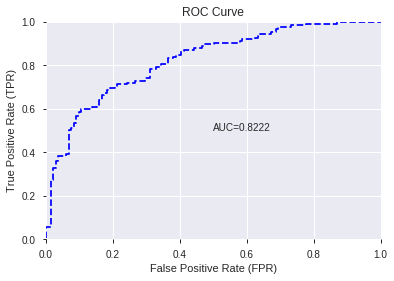

This function is available for GLM models only


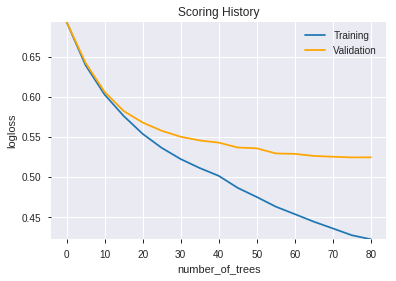

--2019-08-22 16:54:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.98.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.98.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.j

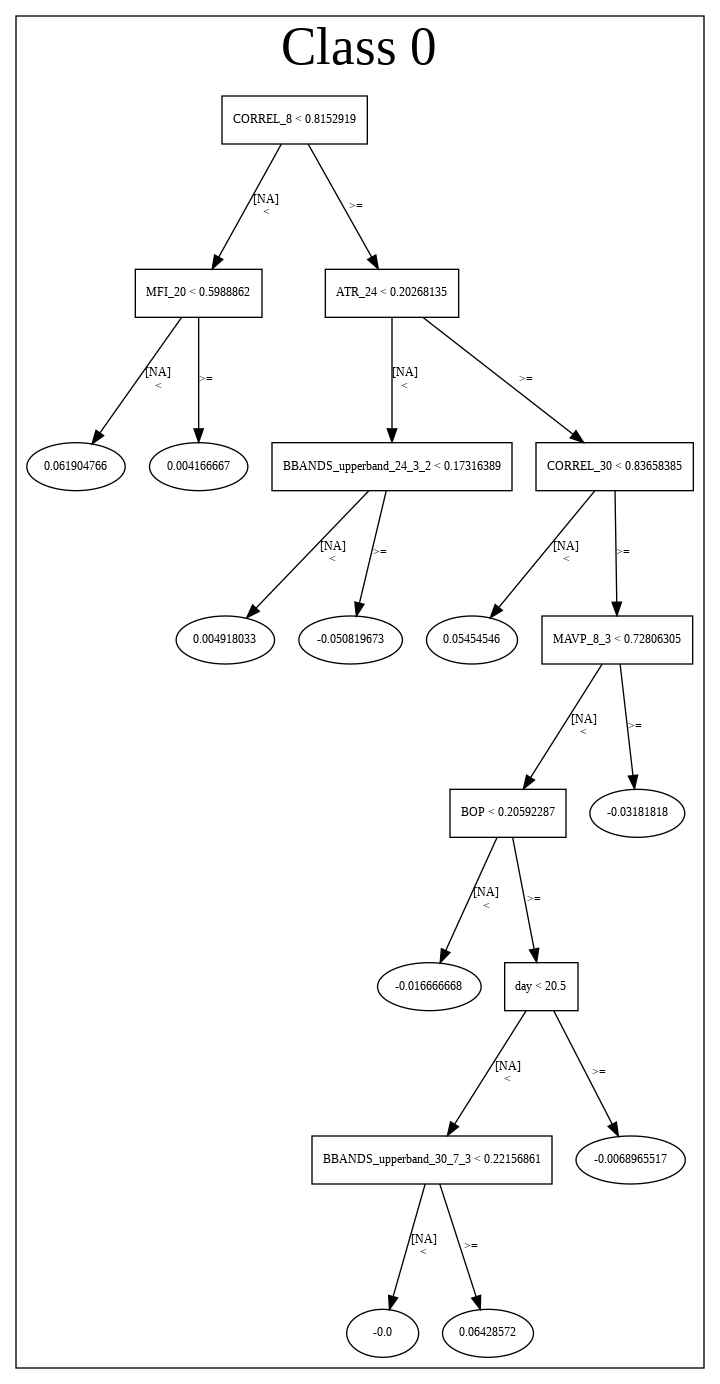

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_165415_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_165415_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_be46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'STOCHF_fastk',
 'CCI_12',
 'WILLR_14',
 'PLUS_DI_8',
 'aroondown_8',
 'aroonup_8',
 'HT_PHASOR_quadrature',
 'WILLR_30',
 'MACDEXT_hist',
 'RSI_8',
 'CCI_14',
 'DX_8',
 'ROC_20',
 'WILLR_12',
 'WILLR_20',
 'PLUS_DM_24',
 'HT_DCPERIOD',
 'PLUS_DI_30',
 'BBANDS_upperband_24_5_3',
 'MACDFIX_24',
 'NATR_20',
 'CCI_24',
 'ROC_30',
 'LINEARREG_SLOPE_14',
 'TRANGE',
 'BBANDS_lowerband_24_5_5',
 'LINEARREG_SLOPE_8',
 'BBANDS_lowerband_14_7_5',
 'CDLRICKSHAWMAN',
 'ROCP_12',
 'VAR_12',
 'LINEARREG_SLOPE_12',
 'MINUS_DI_14',
 'MACDFIX_hist_14',
 'MINUS_DI_20',
 'BBANDS_lowerband_30_0_5',
 'CORREL_12',
 'DX_24',
 'PLUS_DI_24',
 'MOM_14',
 'CMO_24',
 'STOCH_slowk',
 'AROONOSC_12',
 'ROCP_30',
 'aroondown_20',
 'BBANDS_lowerband_30_5_4',
 'STOCHF_fastd',
 'MACD_hist',
 'ROCR_20']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.754
GLM             0.766
XGBoost         0.770
dtype: float64

DeepLearning    GLM  XGBoost
All          0.746  0.766    0.762
DLF          0.746  0.766    0.770
Fwe          0.742  0.719    0.738
RFE          0.734  0.738    0.754
XGBF         0.754  0.766    0.770





F1


DeepLearning    0.760
GLM             0.763
XGBoost         0.780
dtype: float64

DeepLearning    GLM  XGBoost
All          0.743  0.751    0.780
DLF          0.760  0.763    0.759
Fwe          0.743  0.748    0.756
RFE          0.729  0.755    0.757
XGBF         0.752  0.763    0.759





auc


DeepLearning    0.829
GLM             0.828
XGBoost         0.835
dtype: float64

DeepLearning    GLM  XGBoost
All          0.815  0.824    0.835
DLF          0.823  0.828    0.830
Fwe          0.813  0.799    0.806
RFE          0.806  0.816    0.822
XGBF         0.829  0.828    0.830





logloss


DeepLearning    0.618
GLM             0.533
XGBoost         0.533
dtype: float64

DeepLearning    GLM  XGBoost
All          0.618  0.519    0.498
DLF          0.528  0.509    0.510
Fwe          0.537  0.533    0.533
RFE          0.542  0.521    0.520
XGBF         0.544  0.509    0.510





mean_per_class_error


DeepLearning    0.269
GLM             0.287
XGBoost         0.260
dtype: float64

DeepLearning    GLM  XGBoost
All          0.255  0.238    0.236
DLF          0.255  0.235    0.231
Fwe          0.261  0.287    0.260
RFE          0.269  0.263    0.247
XGBF         0.247  0.235    0.231





rmse


DeepLearning    0.465
GLM             0.427
XGBoost         0.424
dtype: float64

DeepLearning    GLM  XGBoost
All          0.465  0.413    0.409
DLF          0.422  0.413    0.412
Fwe          0.429  0.427    0.424
RFE          0.430  0.419    0.417
XGBF         0.426  0.413    0.412





mse


DeepLearning    0.216
GLM             0.182
XGBoost         0.180
dtype: float64

DeepLearning    GLM  XGBoost
All          0.216  0.171    0.167
DLF          0.179  0.171    0.170
Fwe          0.184  0.182    0.180
RFE          0.185  0.175    0.174
XGBF         0.182  0.171    0.170

{'F1':       DeepLearning    GLM  XGBoost
 All          0.743    NaN      NaN
 DLF          0.760    NaN      NaN
 DLF            NaN  0.763      NaN
 DLF            NaN    NaN    0.759
 All            NaN  0.751      NaN
 All            NaN    NaN    0.780
 XGBF         0.752    NaN      NaN
 XGBF           NaN  0.763      NaN
 XGBF           NaN    NaN    0.759
 Fwe          0.743    NaN      NaN
 Fwe            NaN  0.748      NaN
 Fwe            NaN    NaN    0.756
 RFE          0.729    NaN      NaN
 RFE            NaN  0.755      NaN
 RFE            NaN    NaN    0.757,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.746    NaN      NaN
 DLF          0.746    NaN      NaN
 DLF            NaN  0.766      NaN
 DLF            NaN    NaN    0.770
 All            NaN  0.766      NaN
 All            NaN    NaN    0.762
 XGBF         0.754    NaN      NaN
 XGBF           NaN  0.766      NaN
 XGBF           NaN    NaN    0.770
 Fwe          0.742    NaN      NaN
 Fwe     